## Load libraries

In [1]:
library(dplyr) #for arrange/sort functions
library(stringr) #string manipulation functions
library(xlsx) #for writing to excel workbooks
library(ggplot2) #plotting package
library(ggpubr) #for arranging ggplots
library(randomForest) #for performing randomforest 
library(ggrepel) #text and label functions for ggplot2
library(gridExtra) #for arranging plots in grid format
library(grid) #for creating and drawing rectangles around tables in ggplot2
library(gtable) #other table functions for ggplot2
library(MASS) #for lda function
library(reshape2) #for correlation heatmap

Warning message:
“package ‘dplyr’ was built under R version 4.0.2”

Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message:
“package ‘ggplot2’ was built under R version 4.0.2”
Warning message in (function (kind = NULL, normal.kind = NULL, sample.kind = NULL) :
“non-uniform 'Rounding' sampler used”
Warning message:
“package ‘ggpubr’ was built under R version 4.0.2”
Warning message:
“package ‘randomForest’ was built under R version 4.0.2”
randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine


Warning message:
“package ‘ggrepel’ was built under R version 4.0.2”
Warning message:
“package ‘gridExtra’ was built under R version 4.0.2”

Attachin

## Upload appropriate Perl converted data file

In [2]:
isomer_all <- read.csv("~/Desktop/MMC_all.csv", header = TRUE) #read in perl converted data file 
old_data <- read.csv("~/Desktop/FMA_olddata.csv", header = TRUE) #old FMA data
old_old_data <- read.csv("~/Desktop/FMA_oldold.csv", header = TRUE) #old old FMA data

## Change settings

In [3]:
type <- "MMC"                           #isomer type
normal = "ioncurrent"                 #type of normalization, will change for replicate t-tests
ion_threshold <- 1                     #threshold in percent, 0.3/10 for FA/FMA, 1/10 for MMC
max_threshold <- 50                     #Number of spectra which must reach percent threshold
mean_threshold <- 120                   #mean threshold per voltage
replace_zero <- 120                     #what to replace zero abundance with once final ions are selectd
rep_num <- 20                           #for t-test analysis
weeks <- 8                              #number of weeks
card <- 32                              #number of cards in dataset (assumes triplicate data)
card.names <- paste0(isomer_all[,2], "-", substr(isomer_all[,3],1,nchar(isomer_all[,3])-1)) #combines volume with Card # for Card Name

## Select which analysis/analyses to perform

In [4]:
print_excel_data = FALSE #replace saved excel dataset
sameday = FALSE      #Analyze data generated on the same day
ttest = FALSE        #perform replicate unequal variance t-tests/create ROC curves
anova = FALSE            #perform multi-way ANOVA
week_plots = FALSE      #plot changing data over time
growing_plots = FALSE   #plots changing data over time as a growing data set (Week 1, Weeks 1-2, Weeks 1-3, etc)
PCA_LDA = FALSE         #perform PCA followed by LDA
LDA = FALSE             #perform only LDA
lda_threshold = FALSE   #calculate LDA error rates based on differing thresholds, rather than maximum posterior probabilitiy
random_forest = FALSE   #perform random forest algorithm
test_set = FALSE        #analyze using test vs training sets (80/20), also if sameday is true, use each card as a test set
default_rf_confusion = FALSE  #Use the default random forest confusion matrix for plotting
threshold_rf_confusion = FALSE  #Use thresholds for inconclusive/error rates for random forest
test_old_data = FALSE       #Test old FMA data against full dataset (Random forest)
test_oldold_data = FALSE    #Test very original FMA data (from different method, original insulator cap)
correlation = TRUE         #plot correlation heatmap of variables
rf_cv = FALSE          #cross-validation analysis of random forest, plot error rate based on reducing variables
compare_methods = FALSE   #compare and plot importance of variables based on different methods
compare_plot = FALSE   #plot success/inconclusive/error rates for t-test/LDA/RF

## File Names

In [5]:
file_dataset <- paste(getwd(), "/Documents/UvA/Pub1_data/", type, "_", ion_threshold,"_reduced.xlsx", sep="") #name for saved .xlsx file of dataset

if(!sameday){
    file_ttest <- paste(getwd(), "/Documents/UvA/Pub1_excel/", type,"_t-test_",ion_threshold,".xlsx", sep="") #name for saved .xlsx file of replicate t-test results
    roc_curves <- paste(getwd(), "/Documents/UvA/Pub1_plots/ttests/",type,"-",ion_threshold,"_ROC.pdf", sep="") #name for saved individual ROC curves, not same day
    average_roc_curve <- paste(getwd(), "/Documents/UvA/Pub1_plots/ttests/average/",type,"-",ion_threshold,"_ROC_average.pdf", sep="") #name for saved average ROC curve
    file_ttest_threshold <- paste(getwd(), "/Documents/UvA/Pub1_excel/t-test_threshold.xlsx", sep="") #name for saved .xlsx file of t-test with error rates based on threshold
    max_ttest <- paste(getwd(),"/Documents/UvA/Pub1_excel/max_ttest.xlsx", sep="") #Save highest success and lowest error rate data with associated normalization of 20 replicates
    lda_loocv_plot <- paste(getwd(), "/Documents/UvA/Pub1_plots/LDA/loocv/",type, "-", ion_threshold, "-", normal, ".pdf",sep="") #save LDA plot with loocv error rate
    lda_test_plot <- paste(getwd(), "/Documents/UvA/Pub1_plots/LDA/Testset/",type, "-", ion_threshold, "-", normal, "_testset.pdf",sep="") #save LDA plot with test set error rate
    lda_file <- paste(getwd(), "/Documents/UvA/Pub1_excel/LDA_threshold.xlsx",sep="") #excel datafile with success/inconclusive/error rate based on changing LDA posterior probability thresholds
    lda_threshold_plot <- paste(getwd(), "/Documents/UvA/Pub1_plots/LDA/loocv/",type, "-", ion_threshold, "-", normal, "_threshold.pdf",sep="") #lda plot without loocv listed on plot
    lda_threshold_plot_test <- paste(getwd(), "/Documents/UvA/Pub1_plots/LDA/Testset/",type, "-", ion_threshold, "-", normal, "_threshold.pdf",sep="") #lda plot of training set with test sets without error rate listed
    compare_plot_file <- paste(getwd(), "/Documents/UvA/Pub1_plots/Comparison/",type,"-",ion_threshold,"-", normal,"_comparison.pdf", sep="") #plot comparison of results for different methods
    compare_plot_file_test <- paste(getwd(), "/Documents/UvA/Pub1_plots/Comparison/",type,"-",ion_threshold,"-", normal,"_comparison_testset.pdf", sep="") #plot comparison of results for different methods
    lda_file_lr <- paste(getwd(), "/Documents/UvA/Pub1_excel/LDA_LR.xlsx",sep="") #excel datafile with success/inconclusive/error rate based on changing LDA posterior probability thresholds
    lda_file_lr2 <- paste(getwd(), "/Documents/UvA/Pub1_excel/LDA_LR2.xlsx",sep="") #excel datafile with success/inconclusive/error rate based on changing LDA posterior probability thresholds
}

if(sameday){
    file_ttest <- paste(getwd(), "/Documents/UvA/Pub1_excel/", type,"_t-test_",ion_threshold,"_sameday.xlsx", sep="") #name for saved .xlsx file of replicate t-test results
    roc_curves <- paste(getwd(), "/Documents/UvA/Pub1_plots/ttests/",type,"-",ion_threshold,"_ROC_sameday.pdf", sep="") #name for saved individual ROC curves, same day
    average_roc_curve <- paste(getwd(), "/Documents/UvA/Pub1_plots/ttests/average/",type,"-",ion_threshold,"_ROC_sameday_average.pdf", sep="") #name for saved average ROC curves - same day
    file_ttest_threshold <- paste(getwd(), "/Documents/UvA/Pub1_excel/t-test_threshold_sameday.xlsx", sep="") #name for saved .xlsx file of t-test with error rates based on threshold, same day
    max_ttest <- paste(getwd(),"/Documents/UvA/Pub1_excel/max_ttest_sameday.xlsx", sep="") #Save highest success and lowest error rate data with associated normalization of 20 replicates, same day
    lda_loocv_plot <- paste(getwd(), "/Documents/UvA/Pub1_plots/LDA/Sameday/loocv/",type, "-", ion_threshold, "-", normal, ".pdf",sep="") #save LDA plots with loocv error rate, same day
    lda_test_plot <- paste(getwd(), "/Documents/UvA/Pub1_plots/LDA/Sameday/Testset/",type, "-", ion_threshold, "-", normal, "_testset.pdf",sep="") #save LDA plot with test set error rate, same day
    lda_file <- paste(getwd(), "/Documents/UvA/Pub1_excel/LDA_threshold_sameday.xlsx",sep="") #excel datafile with success/inconclusive/error rate based on changing LDA posterior probability thresholds, same day
    lda_threshold_plot <- paste(getwd(), "/Documents/UvA/Pub1_plots/LDA/Sameday/loocv/",type, "-", ion_threshold, "-", normal, "_threshold.pdf",sep="") #lda plots without loocv listed on plots, same day
    lda_threshold_plot_test <- paste(getwd(), "/Documents/UvA/Pub1_plots/LDA/Sameday/Testset/",type, "-", ion_threshold, "-", normal, "_threshold.pdf",sep="") #lda plots of sameday training sets with test sets without error rate listed
    compare_plot_file <- paste(getwd(), "/Documents/UvA/Pub1_plots/Comparison/sameday/",type,"-",ion_threshold,"-", normal,"_comparison_sameday.pdf", sep="")  #plot comparison of results for different methods
    compare_plot_file_test <- paste(getwd(), "/Documents/UvA/Pub1_plots/Comparison/sameday/",type,"-",ion_threshold,"-", normal,"_comparison_sameday_testset.pdf", sep="")  #plot comparison of results for different methods
    lda_file_lr <- paste(getwd(), "/Documents/UvA/Pub1_excel/LDA_LR_sameday.xlsx",sep="") #excel datafile with success/inconclusive/error rate based on changing LDA posterior probability thresholds
    lda_file_lr2 <- paste(getwd(), "/Documents/UvA/Pub1_excel/LDA_LR2_sameday.xlsx",sep="") #excel datafile with success/inconclusive/error rate based on changing LDA posterior probability thresholds
}

file_anova <- paste(getwd(), "/Documents/UvA/Pub1_excel/ANOVA.xlsx", sep="") #name for saved .xlsx file of ANOVA
file_weekly <- paste(getwd(), "/Documents/UvA/Pub1_plots/Week-to-week/",type,"-",ion_threshold,"-",normal,".pdf", sep="") #name for week to week plots
file_growing <- paste(getwd(), "/Documents/UvA/Pub1_plots/Growing_dataset/",type,"-",ion_threshold,"-",normal,"_growing.pdf", sep="") #name for growing dataset plots
rf_plot_name <- paste(getwd(), "/Documents/UvA/Pub1_plots/RF/Importance/",type,"-",ion_threshold,"-",normal,"_RF_importance.pdf", sep="") #name for RF variable importance plots
rf_plot_name_combined <- paste(getwd(), "/Documents/UvA/Pub1_plots/RF/",type,"-",ion_threshold,"-",normal,"_RF_combined.pdf", sep="") #name for RF variable importance combined with top 6 ion distributions plots and error rate tables
rf_sameday_file <- paste(getwd(), "/Documents/UvA/Pub1_excel/RF_sameday.xlsx", sep="")  #random forest success/inconclusive/error for same day (oob and test set)
rf_plot_name_combined_test <- paste(getwd(), "/Documents/UvA/Pub1_plots/RF/Testset/",type,"-",ion_threshold,"-",normal,"_RF_testset.pdf", sep="") #name for RF variable importance combined with top 6 ion distributions plots and error rate tables, for 80/20 test set
rf_olddata <- paste(getwd(), "/Documents/UvA/Pub1_excel/RF_olddata.xlsx", sep="") #random forest success/inconclusive/error for old FMA data
rf_oldold_data <- paste(getwd(), "/Documents/UvA/Pub1_excel/RF_oldold_data.xlsx", sep="") #random forest success/inconclusive/error for original FMA data
pca_file <- paste(getwd(), "/Documents/UvA/Pub1_plots/PCA/",type, "-", ion_threshold, "-", normal, ".pdf",sep="") #saved solely PCA plots
pca_test_file <- paste(getwd(), "/Documents/UvA/Pub1_plots/PCA/",type, "-", ion_threshold, "-", normal, "_testset.pdf",sep="") #saved training set PCA plots
pcalda_loocv_plot <- paste(getwd(), "/Documents/UvA/Pub1_plots/PCA_LDA/loocv/",type, "-", ion_threshold, "-", normal, ".pdf",sep="") #saved PCA/LDA plots with loocv error rate
pcalda_test_plot <- paste(getwd(), "/Documents/UvA/Pub1_plots/PCA_LDA/Testset/",type, "-", ion_threshold, "-", normal, "_testset.pdf",sep="") #saved PCA/LDA plots of training set data with test set shown and with test set error rate
pcalda_threshold_plot <- paste(getwd(), "/Documents/UvA/Pub1_plots/PCA_LDA/loocv/",type, "-", ion_threshold, "-", normal, "_threshold.pdf",sep="") #saved full dataset PCA/LDA without loocv error rate shown
pcalda_threshold_plot_test <- paste(getwd(), "/Documents/UvA/Pub1_plots/PCA_LDA/Testset/",type, "-", ion_threshold, "-", normal, "_threshold.pdf",sep="") #saved PCA/LDA plots of training set data with test set shown, without test set error rate
pcalda_file <- paste(getwd(), "/Documents/UvA/Pub1_excel/PCA_LDA_threshold.xlsx",sep="") #success/inconclusive/error rate workbook for PCA/LDA
corr_file_full <- paste(getwd(), "/Documents/UvA/Pub1_plots/Correlation/",type, "-", ion_threshold, "-", normal, ".pdf",sep="") #plot for correlation heatmap (only full dataset)
corr_file_all <- paste(getwd(), "/Documents/UvA/Pub1_plots/Correlation/",type, "-", ion_threshold, "-", normal, "_all.pdf",sep="") #plots for correlation heatmaps (full dataset, and isomer pairs)
rfcv_file <- paste(getwd(), "/Documents/UvA/Pub1_plots/RF/CV/",type,"-",ion_threshold,"-",normal,"_RF_combined.pdf", sep="") #plot of random forest cross-validation results showing error rate based on reducing variables
comparison_file <-paste(getwd(), "/Documents/UvA/Pub1_plots/Comparison/Axis-adjust/",type,"-",ion_threshold,"-", normal,"_comparison.pdf", sep="") #plots of comparing variable importance based on method used (axis-adjust - with y-axis for t-test adjusted to min=0/35)
file_distribution <- paste(getwd(), "/Documents/UvA/Pub1_plots/Distribution/",type,"-",ion_threshold,"-", normal,"_distribution.pdf", sep="") #distribution plots of 6 most important variables based on ANOVA

## Normalization Function


In [6]:
normalize <- function(data, normal){                        #create function to normalize data based on desired method
    n_30 <- sum(grepl("30V", colnames(data)))               #count how many 30V variables are retained
    n_60 <- sum(grepl("60V", colnames(data)))               #count how many 60V variables are retained
    n_90 <- sum(grepl("90V", colnames(data)))               #count how many 90V variables are retained
    
sum_30 <- vector(length=n_30)                               #create vector to store data to use for normalization
sum_60 <- vector(length=n_60)                               #create vector to store data to use for normalization
sum_90 <- vector(length=n_90)                               #create vector to store data to use for normalization

my_data_normal <- data                                      #create copy of data matrix to store normalized data

for (j in 1:nrow(data)) {                                   #for every row in the data matrix
    if(normal == "vectorlength") {                          #if "vectorlength" is chosen, data is normalized to a unit vector per voltage
      for (k in 1:n_30) {                                   #for each 30V m/z
        sum_30[k] <- data[j,k]*data[j,k]                    #in sum_30 vector, insert square of abundance of the given sample at the given m/z
      }
      
      for(k in 1:n_60){                                     #for each 60V m/z
        sum_60[k] <- data[j,k+n_30]*data[j,k+n_30]          #in sum_60 vector, insert square of abundance of the given sample at the given m/z
      }
      
      for(k in 1:n_90){                                     #for each 90V m/z
        sum_90[k] <- data[j,k+n_30+n_60]*data[j,k+n_30+n_60]#in sum_90 vector, insert square of abundance of the given sample at the given m/z
      }
      
      divisor_30 <- sqrt(sum(sum_30))                       #the 30V divisor for the jth sample is the square root of the sum of the squares that are stored in the sum_30 vector
      divisor_60 <- sqrt(sum(sum_60))                       #the 60V divisor for the jth sample is the square root of the sum of the squares that are stored in the sum_60 vector
      divisor_90 <- sqrt(sum(sum_90))                       #the 90V divisor for the jth sample is the square root of the sum of the squares that are stored in the sum_90 vector
    }
    
    if (normal == "ioncurrent") {                           #if ioncurrent is selected, abundances are normalized by the total ion current of all selected m/z ions for the given voltage
      for (k in 1:n_30) {                                   #for each 30V m/z
        sum_30[k] <- data[j,k]                              #in sum_30 vector, insert the abundance for each sample at the given m/z
      }
      
      for(k in 1:n_60){                                     #for each 60V m/z
        sum_60[k] <- data[j,k+n_30]                         #in sum_60 vector, insert the abundance for each sample at the given m/z
      }
      
      for(k in 1:n_90){                                     #for each 90V m/z
        sum_90[k] <- data[j,k+n_30+n_60]                    #in sum_90 vector, insert the abundance for each sample at the given m/z
      }
      
      divisor_30 <- sum(sum_30)                             #the 30V divisor for the jth sample is the sum of the abundances of all selected 30V 
      divisor_60 <- sum(sum_60)                             #the 60V divisor for the jth sample is the sum of the abundances of all selected 60V
      divisor_90 <- sum(sum_90)                             #the 90V divisor for the jth sample is the sum of the abundances of all selected 90V
    }
    
    for (k in 1:n_30){                                      #for each 30V m/z
      my_data_normal[j,k] <-data[j,k]/divisor_30            #divide abundance by stored 30V divisor and store in my_data_normal
    }
    
    for(k in 1:n_60){                                       #for each 60V m/z
      my_data_normal[j,k+n_30] <- data[j,k+n_30]/divisor_60 #divide abundance by stored 60V divisor and store in my_data_normal
    }
    
    for(k in 1:n_90){                                       #for each 90V m/z
      my_data_normal[j,k+n_30+n_60] <- data[j,k+n_30+n_60]/divisor_90 #divide abundance by stored 90V divisor and store in my_data_normal
    }
  }

return(my_data_normal)
    }



## Begin to clean dataset

In [7]:
isomer_data <- isomer_all[,-(1:5)]                                   #remove date, volume, card #, voltage, Label (Isomer ID)
colnames(isomer_data) <- str_replace(colnames(isomer_data),"X.", "") #remove X. from Colnames (introduced by < in header)
number_of_spectra <- nrow(isomer_data)/3                             #number of spectra per isomer
isomer_data[is.na(isomer_data)] <- 0                                 #replace any NAs with 0
dim(isomer_data)  #print initial dimensions of data, number of rows should be number of analyzed samples * 3 (3 voltages)
head(isomer_data)

[1]  864 4557

,66.100,66.125,66.150,66.175,66.200,66.225,66.250,66.275,66.300,66.325,⋯,179.775,179.800,179.825,179.850,179.875,179.900,179.925,179.950,179.975,180.000
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


## Remove all-zero columns

In [8]:
detect_zero <- function(data) {                        #create a function to detect 0's in each m/z bins
    return(length(which(data==0)))                     #count how many indices in a given data vector are equal to 0
}

zero_vector <- apply(isomer_data, MARGIN = 2, FUN = detect_zero) #apply the detect_zero function to all columns in isomer_data

removed_ions <- which(zero_vector == nrow(isomer_data))#ID which bins have no signal in any spectra
isomer_data <- isomer_data[,-removed_ions]             #remove bins with all zero signal
dim(isomer_data)         #show dimensions of reduced isomer dataset
head(isomer_data)

[1] 864 377

,67.075,69.075,77.050,78.050,79.075,81.075,83.100,85.125,86.075,88.025,⋯,179.575,179.600,179.625,179.650,179.675,179.700,179.725,179.950,179.975,180.000
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,0.000,0.000,0,0,0,0,0,0,⋯,581.8716,0.000,817.3448,0,0,0,0,0,0,0
2,0,0,0.000,0.000,0,0,0,0,0,0,⋯,0.0000,0.000,0.0000,0,0,0,0,0,0,0
3,0,0,0.000,0.000,0,0,0,0,0,0,⋯,0.0000,0.000,0.0000,0,0,0,0,0,0,0
4,0,0,0.000,0.000,0,0,0,0,0,0,⋯,0.0000,3375.654,0.0000,0,0,0,0,0,0,0
5,0,0,0.000,0.000,0,0,0,0,0,0,⋯,0.0000,0.000,0.0000,0,0,0,0,0,0,0
6,0,0,715.513,397.541,0,0,0,0,0,0,⋯,0.0000,0.000,0.0000,0,0,0,0,0,0,0


## Create vector to identify max abundance in each spectrum

In [9]:
max_times_percent <- function(X, ion_threshold){      #Create a function to identify the maximum abundance in a single voltage spectrum and multiply by the ion threshold percentage. This gives a threshold over which a given number of spectra in a m/z bin must be over in order to be retained 
  max(X) * (ion_threshold/100)       
}
threshold_max <- apply(isomer_data, MARGIN = 1, FUN = max_times_percent, ion_threshold = ion_threshold) #store the thresholds in a vector to later test how many spectra in a m/z bin reach their respective thresholds 

head(threshold_max) #show the first six threshold

[1]  780.2056 1243.0283  988.5082 1347.1469 2456.0044 2100.1285

## Create vector to determine how many spectra reach the abundance threshold
#### Reduce data to only ions for which the number of spectra over the abundance threshold is over the set "max threshold"

In [10]:
sum_if_greater <- function(X, threshold_max){   #create a function count how many spectra in a given m/z bin are over their respective spectrum thresholds
    sum(X>threshold_max)
}

threshold_vector <- apply(isomer_data, MARGIN = 2, FUN = sum_if_greater, threshold_max = threshold_max) #create a vector containing the number of spectra in each m/z bin that meet their threshold

selected_ions <- which(threshold_vector>max_threshold)  #create a vector of ions whose number of spectra over the abundance threshold is more than the set number required
colnames(isomer_data[selected_ions]) #print the names of the selected ions

[1] "91.075"  "103.075" "104.075" "115.075" "117.075" "119.100" "120.100"
 [8] "128.075" "129.075" "130.075" "131.075" "144.100" "144.525" "145.100"
[15] "145.525" "146.100" "147.100" "158.100" "160.125" "160.650" "161.125"
[22] "161.525" "161.950" "162.375" "178.125" "178.600" "178.700" "179.125"
[29] "179.150" "179.600"

## Add voltage and label information to data and separate based on voltage

In [11]:
isomer_reduced <- cbind(isomer_all[,4:5],isomer_data[,selected_ions])  #combine the selected ions with Isomer label and voltage info
isomer_30 <- isomer_reduced[which(isomer_reduced[,1]==30),]            #separate out the 30V spectra
isomer_60 <- isomer_reduced[which(isomer_reduced[,1]==60),]            #separate out the 60V spectra
isomer_90 <- isomer_reduced[which(isomer_reduced[,1]==90),]            #separate out the 90V spectra
head(isomer_30)      #show the first six rows of the 30V data

,Voltage,Label,91.075,103.075,104.075,115.075,117.075,119.100,120.100,128.075,⋯,161.125,161.525,161.950,162.375,178.125,178.600,178.700,179.125,179.150,179.600
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,30,2,0,0,0,0,0,0,0,0,⋯,837.8622,0,0,0,78020.56,69.0075,341.6535,0,9506.857,0.0000
4,30,2,0,0,0,0,0,0,0,0,⋯,2262.9369,0,0,0,134714.69,0.0000,3692.2464,0,20429.713,3375.6543
7,30,2,0,0,0,0,0,0,0,0,⋯,2603.8632,0,0,0,136243.80,2849.3325,0.0000,0,21320.685,3220.4176
10,30,2,0,0,0,0,0,0,0,0,⋯,2182.7152,0,0,0,112591.42,0.0000,3150.1617,0,16719.820,1925.6371
13,30,2,0,0,0,0,0,0,0,0,⋯,1789.8380,0,0,0,92424.11,0.0000,2544.2587,0,13759.496,1390.7823
16,30,2,0,0,0,0,0,0,0,0,⋯,955.9178,0,0,0,69943.14,399.7002,754.4546,0,9246.327,702.0115


## Reduce 30V data 
- Based on ions whose average abundance in voltage is over mean threshold
- Remove remaining ions where over 2/3 have 0 signal
- Replace remaining 0 abundance with centroiding threshold from instrument
- Remove fringe data (ions whose bin is less than 1 mass unit higher than main ion value
- Remove likely isotopes

In [12]:
selected_ions_2 <- which(colMeans(isomer_30[,-(1:2)])>mean_threshold)+2 #determine ions whose mean abundance is over a threshold
isomer_30_temp <- isomer_30[,selected_ions_2]     #temporarily store only those ions over the mean abundance threshold
print(head(isomer_30_temp))
removed_ions_2 <- which(colSums(isomer_30_temp==0)>(2*number_of_spectra/3)) #determine remaining ions where over 2/3 have zero signal

if(length(removed_ions_2)!=0){              #if there are any ions that don't meet the 2/3 threshold
  isomer_30_temp <- cbind(isomer_30[,1:2],isomer_30_temp[,-removed_ions_2])   #replace isomer_30_temp with label and voltage info and 30V data with ions removed that don't reach the 2/3 threshold
} else {
  isomer_30_temp <- cbind(isomer_30[,1:2],isomer_30_temp) #if there are no ions to be removed, combine isomer_30_temp with label and voltage info
}
print(head(isomer_30_temp))
isomer_30_temp[isomer_30_temp==0] <- replace_zero #replace zero with centroiding threshold from instrument

to_remove_30 <- vector()                      #determine ions whose bin is less than 1 mass unit greater (fringe)
for (i in 1:(ncol(isomer_30_temp)-3)){        #for 1 to number of columns of isomer_30_temp-3 (to account for first two columns being label/voltage info)
  to_remove_30 <- append(to_remove_30,which(as.integer(colnames(isomer_30_temp[,-(1:2)])[-(1:i)]) <= as.integer(colnames(isomer_30_temp[,-(1:2)])[i])+0.9)+i+2)
} #find column names that, when rounded down to the nearest integer, are less than 0.9 amu greater than the column(s) preceding them

if(length(to_remove_30)!=0){  #if there are any fringe ions 
  isomer_30_temp <- isomer_30_temp[,-to_remove_30] #remove fringe ions
}
print(head(isomer_30_temp))
to_remove_30a<-vector()    #determine ions which are 1-2 mass units greater (possible isotopes) 
for (i in 1:(ncol(isomer_30_temp)-3)){   #for 1 to number of columns of isomer_30_temp-3 (to account for first two columns being label/voltage
  to_remove_30a <- append(to_remove_30a,which(as.integer(colnames(isomer_30_temp[,-(1:2)])[-(1:i)]) <= as.integer(colnames(isomer_30_temp[,-(1:2)])[i])+1)+i+2)
} #find column names that, when rounded down to the nearest integer, are less than 1 amu greater than the column(s) preceding them

for(i in 1:length(to_remove_30a)){ #if ions determined above are not suspected isotopes, remove them from to remove vector
  if(mean(isomer_30_temp[,to_remove_30a[i]]/isomer_30_temp[,to_remove_30a[i]-1],na.rm = TRUE) < 0.011 | mean(isomer_30_temp[,to_remove_30a[i]]/isomer_30_temp[,to_remove_30a[i]-1],na.rm = TRUE) > (as.integer(colnames(isomer_30_temp)[to_remove_30a[i]])/1000)) {#if the mean proportion of the suspected isotope to the preceding ion abundance is less than 0.011 or more than the (as integer) bin divided by 1000 ex: 109 checks form 10.9%)
    to_remove_30a[i] <- NA
  }
}
to_remove_30a <- na.omit(to_remove_30a) #remove m/z values that do not appear consistent with isotopes

isomer_30_final <- isomer_30_temp[,-to_remove_30a] #final 30V data, remove isotope m/z values

head(isomer_30_final) #first six rows of remaining variables

    144.100   145.100   147.100   160.125   161.125   178.125   178.600
1  197.4658  758.7410  337.8579  6554.400  837.8622  78020.56   69.0075
4  211.5715  988.7890  871.7720 19068.542 2262.9369 134714.69    0.0000
7  273.4706 1189.3594 1003.4518 21684.975 2603.8632 136243.80 2849.3325
10   0.0000  734.6217  944.7598 17907.608 2182.7152 112591.42    0.0000
13 211.8780 1010.5049  763.2858 14934.255 1789.8380  92424.11    0.0000
16 203.3659  796.0944  351.1679  6817.436  955.9178  69943.14  399.7002
     178.700 179.125   179.150   179.600
1   341.6535       0  9506.857    0.0000
4  3692.2464       0 20429.713 3375.6543
7     0.0000       0 21320.685 3220.4176
10 3150.1617       0 16719.820 1925.6371
13 2544.2587       0 13759.496 1390.7823
16  754.4546       0  9246.327  702.0115
   Voltage Label  144.100   145.100   147.100   160.125   161.125   178.125
1       30     2 197.4658  758.7410  337.8579  6554.400  837.8622  78020.56
4       30     2 211.5715  988.7890  871.7720 19068.542 2

,Voltage,Label,144.100,145.100,147.100,160.125,178.125
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,30,2,197.4658,758.7410,337.8579,6554.400,78020.56
4,30,2,211.5715,988.7890,871.7720,19068.542,134714.69
7,30,2,273.4706,1189.3594,1003.4518,21684.975,136243.80
10,30,2,120.0000,734.6217,944.7598,17907.608,112591.42
13,30,2,211.8780,1010.5049,763.2858,14934.255,92424.11
16,30,2,203.3659,796.0944,351.1679,6817.436,69943.14


## 60V data selection
    Same as above

In [13]:
selected_ions_3 <- which(colMeans(isomer_60[,-(1:2)])>mean_threshold)+2  #determine ions whose mean abundance is over a threshold
isomer_60_temp <- isomer_60[,selected_ions_3]       #temporarily store only those ions over the mean abundance threshold
print(head(isomer_60_temp))
removed_ions_3 <- which(colSums(isomer_60_temp==0)>(2*number_of_spectra/3))  #determine remaining ions where over 2/3 have zero signal

if(length(removed_ions_3)!=0){                    #if there are any ions that don't meet the 2/3 threshold
  isomer_60_temp <- cbind(isomer_60[,1:2],isomer_60_temp[,-removed_ions_3]) #replace isomer_60_temp with label and voltage info and 60V data with ions removed that don't reach the 2/3 threshold
} else{
  isomer_60_temp <- cbind(isomer_60[,1:2],isomer_60_temp)    #if there are no ions to be removed, combine isomer_60_temp with label and voltage info
}
print(head(isomer_60_temp))
isomer_60_temp[isomer_60_temp==0] <- replace_zero #replace zero with centroiding threshold from instrument

to_remove_60 <- vector()       #determine ions whose bin is less than 1 mass unit greater (fringe)
for (i in 1:(ncol(isomer_60_temp)-3)){       #for 1 to number of columns of isomer_30_temp-3 (to account for first two columns being label/voltage info)
  to_remove_60 <- append(to_remove_60,which(as.integer(colnames(isomer_60_temp[,-(1:2)])[-(1:i)]) <= as.integer(colnames(isomer_60_temp[,-(1:2)])[i])+0.9)+i+2)
} #find column names that, when rounded down to the nearest integer, are less than 0.9 amu greater than the column(s) preceding them

if(length(to_remove_60)!=0){ #if there are any fringe ions 
  isomer_60_temp <- isomer_60_temp[,-to_remove_60] #remove fringe ions
}
print(head(isomer_60_temp))
to_remove_60a<-vector() #determine ions which are 1-2 mass units greater (possible isotopes)
for (i in 1:(ncol(isomer_60_temp)-3)){ #for 1 to number of columns of isomer_30_temp-3 (to account for first two columns being label/voltage
  to_remove_60a <- append(to_remove_60a,which(as.integer(colnames(isomer_60_temp[,-(1:2)])[-(1:i)]) <= as.integer(colnames(isomer_60_temp[,-(1:2)])[i])+1)+i+2)
}#find column names that, when rounded down to the nearest integer, are less than 1 amu greater than the column(s) preceding them

for(i in 1:length(to_remove_60a)){ #if ions determined above are not suspected isotopes, remove them from to remove vector
  if(mean(isomer_60_temp[,to_remove_60a[i]]/isomer_60_temp[,to_remove_60a[i]-1],na.rm = TRUE) < 0.011 | mean(isomer_60_temp[,to_remove_60a[i]]/isomer_60_temp[,to_remove_60a[i]-1],na.rm = TRUE) > (as.integer(colnames(isomer_60_temp)[to_remove_60a[i]])/1000)) {#if the mean proportion of the suspected isotope to the preceding ion abundance is less than 0.011 or more than the (as integer) bin divided by 1000 ex: 109 checks form 10.9%)
    to_remove_60a[i] <- NA
  }
}
to_remove_60a <- na.omit(to_remove_60a) #remove m/z values that do not appear consistent with isotopes

isomer_60_final <- isomer_60_temp[,-to_remove_60a]#final 60V data, remove isotope m/z values
head(isomer_60_final) #first six rows of remaining variables

     117.075   119.100   120.100   129.075   130.075  144.100   145.100
2     0.0000  3289.350  324.4030  473.5685  305.2114 1477.537  33880.72
5   573.2611 11338.035 1079.5931 1344.2233  742.2585 4574.902  93577.68
8   491.0855  9133.576  974.1046 1209.0045  666.3449 4107.978  84569.48
11 1008.8507 15952.145 1536.2462 1780.1830 1024.4288 6262.763 112609.72
14  760.6085 12274.956 1166.2605 1483.8032  861.4155 4754.718  92705.90
17  310.5475  4999.912  466.3307  610.7088  321.0905 1590.733  36663.08
     145.525   146.100   147.100  158.100  160.125  160.650  161.125  161.525
2     0.0000  3661.384  6414.692 293.9151 124302.8 2868.951 14679.10  379.663
5   395.1348  9530.167 12707.005 652.4884 245600.4 7058.919 33989.29 3876.558
8   309.7883  8496.871 11236.179 490.6500 217562.7 6061.488 26148.42 4507.565
11 1959.1777 13572.273 15648.532 826.3781 279473.8 9817.685 38364.09 4577.672
14  439.5904 10341.810 11962.549 637.1099 230949.4 6608.409 32392.26 3880.060
17    0.0000  4011.202  7251

,Voltage,Label,117.075,119.100,129.075,130.075,144.100,145.100,147.100,158.100,160.125,178.125
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2,60,2,120.0000,3289.350,473.5685,305.2114,1477.537,33880.72,6414.692,293.9151,124302.8,60978.18
5,60,2,573.2611,11338.035,1344.2233,742.2585,4574.902,93577.68,12707.005,652.4884,245600.4,60235.90
8,60,2,491.0855,9133.576,1209.0045,666.3449,4107.978,84569.48,11236.179,490.6500,217562.7,46749.51
11,60,2,1008.8507,15952.145,1780.1830,1024.4288,6262.763,112609.72,15648.532,826.3781,279473.8,60778.70
14,60,2,760.6085,12274.956,1483.8032,861.4155,4754.718,92705.90,11962.549,637.1099,230949.4,54736.81
17,60,2,310.5475,4999.912,610.7088,321.0905,1590.733,36663.08,7251.622,315.7402,129655.8,49654.03


## 90V data selection
    Same as above

In [14]:
selected_ions_4 <- which(colMeans(isomer_90[,-(1:2)])>mean_threshold)+2 #determine ions whose mean abundance is over a threshold
isomer_90_temp <- isomer_90[,selected_ions_4]  #temporarily store only those ions over the mean abundance threshold
print(head(isomer_90_temp))
removed_ions_4 <- which(colSums(isomer_90_temp==0)>(2*number_of_spectra/3))  #determine remaining ions where over 2/3 have zero signal

if(length(removed_ions_4)!=0){   #if there are any ions that don't meet the 2/3 threshold
  isomer_90_temp <- cbind(isomer_90[,1:2],isomer_90_temp[,-removed_ions_4]) #replace isomer_30_temp with label and voltage info and 30V data with ions removed that don't reach the 2/3 threshold
} else{
  isomer_90_temp <- cbind(isomer_90[,1:2],isomer_90_temp)  #if there are no ions to be removed, combine isomer_30_temp with label and voltage info
}
print(head(isomer_90_temp))
isomer_90_temp[isomer_90_temp==0] <- replace_zero #replace zero with centroiding threshold from instrument

to_remove_90 <- vector()  #determine ions whose bin is less than 1 mass unit greater (fringe)
for (i in 1:(ncol(isomer_90_temp)-3)){  #for 1 to number of columns of isomer_30_temp-3 (to account for first two columns being label/voltage info)
  to_remove_90 <- append(to_remove_90,which(as.integer(colnames(isomer_90_temp[,-(1:2)])[-(1:i)]) <= as.integer(colnames(isomer_90_temp[,-(1:2)])[i])+0.9)+i+2)
} #find column names that, when rounded down to the nearest integer, are less than 0.9 amu greater than the column(s) preceding them

if(length(to_remove_90)!=0){ #if there are any fringe ions 
  isomer_90_temp <- isomer_90_temp[,-to_remove_90] #remove fringe ions
}
print(head(isomer_90_temp))
to_remove_90a<-vector() #determine ions which are 1-2 mass units greater (possible isotopes) 
for (i in 1:(ncol(isomer_90_temp)-3)){ #for 1 to number of columns of isomer_30_temp-3 (to account for first two columns being label/voltage
  to_remove_90a <- append(to_remove_90a,which(as.integer(colnames(isomer_90_temp[,-(1:2)])[-(1:i)]) <= as.integer(colnames(isomer_90_temp[,-(1:2)])[i])+1)+i+2)
} #find column names that, when rounded down to the nearest integer, are less than 1 amu greater than the column(s) preceding them

for(i in 1:length(to_remove_90a)){ #if ions determined above are not suspected isotopes, remove them from to remove vector
  if(mean(isomer_90_temp[,to_remove_90a[i]]/isomer_90_temp[,to_remove_90a[i]-1],na.rm = TRUE) < 0.011 | mean(isomer_90_temp[,to_remove_90a[i]]/isomer_90_temp[,to_remove_90a[i]-1],na.rm = TRUE) > (as.integer(colnames(isomer_90_temp)[to_remove_90a[i]])/1000)) {#if the mean proportion of the suspected isotope to the preceding ion abundance is less than 0.011 or more than the (as integer) bin divided by 1000 ex: 109 checks form 10.9%)
    to_remove_90a[i] <- NA
  }
}
to_remove_90a <- na.omit(to_remove_90a) #remove m/z values that do not appear consistent with isotopes

isomer_90_final <- isomer_90_temp[,-to_remove_90a]  #final 90V data, remove isotope m/z values
head(isomer_90_final)

      91.075   103.075   104.075   115.075  117.075   119.100   120.100
3      0.000  902.2444  734.8469  674.2198 2316.837  7247.591  798.6468
6   9322.019 2715.8973 2215.7197 2080.1530 6322.497 15601.507 1556.0234
9   8276.892 2583.9775 2119.9373 2142.7480 5887.231 13076.683 1326.6991
12 18442.988 3775.0935 3097.4790 2957.1360 8474.161 19591.307 1855.6508
15 10731.497 2573.6233 1927.3245 1820.2471 5934.103 14846.142 1478.3038
18  3179.332 1052.2126  880.5395  686.3222 2716.274  7995.523  814.7088
     128.075  129.075   130.075  131.075   144.100    144.525   145.100
3   849.1387 1076.453  4817.328  618.057  46277.98   66.07179  98850.82
6  2386.7891 2445.372 13596.529 2250.276 134238.27 3245.99303 210012.85
9  2219.2657 2137.268 12926.491 2039.657 128124.16 2810.66326 188283.42
12 3183.4949 3424.399 18598.008 3600.011 182178.67 5823.46183 257596.85
15 2153.6288 2356.968 12280.427 2476.347 119874.79 2579.14485 190236.93
18  967.8953 1145.794  5051.124 1160.508  47823.23    0.00000 10

,Voltage,Label,91.075,103.075,104.075,115.075,117.075,119.100,128.075,129.075,130.075,131.075,144.100,145.100,147.100,158.100,160.125,178.125
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,90,2,120.000,902.2444,734.8469,674.2198,2316.837,7247.591,849.1387,1076.453,4817.328,618.057,46277.98,98850.82,1958.952,914.8364,39102.38,5417.777
6,90,2,9322.019,2715.8973,2215.7197,2080.1530,6322.497,15601.507,2386.7891,2445.372,13596.529,2250.276,134238.27,210012.85,2696.287,2310.5685,54851.66,2778.576
9,90,2,8276.892,2583.9775,2119.9373,2142.7480,5887.231,13076.683,2219.2657,2137.268,12926.491,2039.657,128124.16,188283.42,2257.793,2139.7251,44578.41,2069.776
12,90,2,18442.988,3775.0935,3097.4790,2957.1360,8474.161,19591.307,3183.4949,3424.399,18598.008,3600.011,182178.67,257596.85,2695.804,3105.2918,55552.28,1854.086
15,90,2,10731.497,2573.6233,1927.3245,1820.2471,5934.103,14846.142,2153.6288,2356.968,12280.427,2476.347,119874.79,190236.93,2885.591,2080.6920,48736.96,2207.522
18,90,2,3179.332,1052.2126,880.5395,686.3222,2716.274,7995.523,967.8953,1145.794,5051.124,1160.508,47823.23,100115.89,1713.778,880.4556,34698.25,3986.762


## Combine all voltages
- Save finished dataset if desired
- Determine number of ions of each voltage included in final dataset

In [15]:
all_isomers <- cbind(isomer_30_final[,-1], isomer_60_final[,-(1:2)], isomer_90_final[,-(1:2)]) #combine all three voltages, plus one column of label information

if(print_excel_data) {   #if desired, print the final dataset to an excel file
write.xlsx(all_isomers, file_dataset, append = FALSE, showNA = FALSE, row.names = FALSE)
}

n_30 <- ncol(isomer_30_final) - 2   #determine number of 30V m/z ions
n_60 <- ncol(isomer_60_final) - 2   #determine number of 60V m/z ions
n_90 <- ncol(isomer_90_final) - 2   #determine number of 90V m/z ions

print(paste0(n_30, " 30V ions"))    #print number of 30V m/z ions
print(paste0(n_60, " 60V ions"))    #print number of 60V m/z ions
print(paste0(n_90, " 90V ions"))    #print number of 90V m/z ions

[1] "5 30V ions"
[1] "10 60V ions"
[1] "16 90V ions"


## Add voltage information to column names

In [16]:
if(length(unique(colnames(all_isomers))) < n_30+n_60+n_90+1){    #if there are duplicate column names (voltage info, not yet added)
for (i in 1:length(colnames(all_isomers))){                  #add voltage information to column names
  if(i>1 & i<= (1+n_30)){ #if column number is between 1 and (1+ number of 30V variables)-inclusive
    colnames(all_isomers)[i] <- paste(colnames(all_isomers)[i],"30V") #add " 30V" to column name
  }
  if (i>(n_30+1) & i<= (1+ n_30 + n_60)){ #if column number is between (1+ number of 30V variables) and (1+ number of 30 and 60V variables) - inclusive
  colnames(all_isomers)[i] <- paste(colnames(all_isomers)[i],"60V") #add " 60V" to column name
  }
  if (i> (1 + n_30 + n_60)){  #if column is greater than 1+ number of 30 and 60V variables
    colnames(all_isomers)[i] <- paste(colnames(all_isomers)[i],"90V") #add " 90V" to column name
  }
}
}

colnames(all_isomers) #print column names

[1] "Label"       "144.100 30V" "145.100 30V" "147.100 30V" "160.125 30V"
 [6] "178.125 30V" "117.075 60V" "119.100 60V" "129.075 60V" "130.075 60V"
[11] "144.100 60V" "145.100 60V" "147.100 60V" "158.100 60V" "160.125 60V"
[16] "178.125 60V" "91.075 90V"  "103.075 90V" "104.075 90V" "115.075 90V"
[21] "117.075 90V" "119.100 90V" "128.075 90V" "129.075 90V" "130.075 90V"
[26] "131.075 90V" "144.100 90V" "145.100 90V" "147.100 90V" "158.100 90V"
[31] "160.125 90V" "178.125 90V"

## Create vectors with pertinent information:
- Week number
- Volume
- Card number in a given week
#### Assumes data to be arranged by Label

In [17]:
Week <- vector(length = nrow(all_isomers))   #create a vector with space for week information
isomers_per_week <- nrow(all_isomers)/length(unique(Isomer))/weeks #number of each isomer analyzed per week
    for(k in 1:length(unique(Isomer))){      #for 1- number of isomers
        for(i in 1:weeks){                   #for number of weeks
            start <- ((i*isomers_per_week)-(isomers_per_week-1))+((k-1)*nrow(all_isomers)/length(unique(Isomer))) #start of week
            finish <- (i*isomers_per_week)+((k-1)*nrow(all_isomers)/length(unique(Isomer))) #end of week
           Week[start:finish] <- rep(i, isomers_per_week)  #repeat the week number for how many samples of each isomer were analyzed each week
        }
}
three <- rep(3,card/weeks/2*3) #repeat number of times volume was analyzed each week (currently 6)
six <- rep(6,card/weeks/2*3)   #repeat number of times volume was analyzed each week (currently 6)
Volume <- rep(rep(c(three, six),weeks),length(unique(Isomer))) #repeat each volume vector for each week
Card<- rep(c(1,1,1,2,2,2,3,3,3,4,4,4),24)   #which card per week (4 cards each week)

## Normalization

In [18]:
all_isomers <- arrange(all_isomers, Label)      #arrange by label  
my_data <- all_isomers[,-1]                     #all data except labels
Isomer <- all_isomers[,1]                       #labels
my_data_normal <- normalize(my_data, normal)    #use normalization function to normalize the data
my_data_test <- cbind(Isomer, my_data_normal)   #create a dataset with normalized data and label information
my_data_anova <- cbind(as.factor(Isomer), as.factor(Week), as.factor(Volume), my_data_normal)  #create a dataset for ANOVA testing and week-to-week plotting
colnames(my_data_anova) <- c("Isomer", "Week", "Volume", colnames(my_data_anova[,-(1:3)])) #create column names for ANOVA dataset
my_data_sameday_byweek <- arrange(cbind(Isomer, Week, Card, Volume, my_data_normal), Week) #create a dataset for same day testing, and arrange by week 

head(my_data_sameday_byweek, n=18)              #show first 18 rows of sameday testing dataset, to check order of data

,Isomer,Week,Card,Volume,144.100 30V,145.100 30V,147.100 30V,160.125 30V,178.125 30V,117.075 60V,⋯,128.075 90V,129.075 90V,130.075 90V,131.075 90V,144.100 90V,145.100 90V,147.100 90V,158.100 90V,160.125 90V,178.125 90V
,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,1,1,3,0.0022996158,0.008836027,0.003934572,0.07633020,0.9085996,0.0005182779,⋯,0.004007650,0.005080495,0.02273617,0.002917022,0.2184165,0.4665427,0.009245598,0.004317721,0.18455013,0.025570089
2,2,1,1,3,0.0013574863,0.006344273,0.005593468,0.12234768,0.8643571,0.0013290048,⋯,0.005123790,0.005249551,0.02918806,0.004830732,0.2881732,0.4508407,0.005788198,0.004960165,0.11775164,0.005964850
3,2,1,1,3,0.0017049813,0.007415187,0.006256127,0.13519728,0.8494264,0.0013053270,⋯,0.005273126,0.005078294,0.03071422,0.004846363,0.3044317,0.4473741,0.005364669,0.005084132,0.10592131,0.004917928
4,2,1,2,3,0.0009070404,0.005552763,0.007141127,0.13535769,0.8510414,0.0020365783,⋯,0.005412937,0.005822549,0.03162243,0.006121144,0.3097607,0.4379952,0.004583710,0.005279968,0.09445626,0.003152526
5,2,1,2,3,0.0019377189,0.009241518,0.006980589,0.13658044,0.8452597,0.0018500564,⋯,0.005089843,0.005570412,0.02902332,0.005852548,0.2833097,0.4496022,0.006819749,0.004917466,0.11518397,0.005217214
6,2,1,2,3,0.0026035436,0.010191808,0.004495744,0.08727859,0.8954303,0.0013421928,⋯,0.004521737,0.005352830,0.02359744,0.005421568,0.2234168,0.4677135,0.008006291,0.004113243,0.16210054,0.018625037
7,2,1,3,6,0.0007386554,0.005679812,0.006457487,0.13723362,0.8498904,0.0016638013,⋯,0.005091588,0.005570229,0.03033738,0.006275206,0.2953068,0.4436673,0.006140949,0.004915270,0.10435523,0.003759789
8,2,1,3,6,0.0009433544,0.006085647,0.005120530,0.10920844,0.8786420,0.0011199468,⋯,0.004642840,0.005694390,0.02745537,0.005998682,0.2664875,0.4599294,0.006668669,0.004654683,0.12226771,0.006977652
9,2,1,3,6,0.0010255158,0.006808029,0.005057432,0.09884575,0.8882633,0.0010555956,⋯,0.004314868,0.006172514,0.02540693,0.005846260,0.2550401,0.4590033,0.007056055,0.004264084,0.13841355,0.010425866


## ANOVA testing
- Save as excel file

In [19]:
if(anova){ #perform anova if requested
    
if(nchar(as.character(my_data_test[1,1]))==1){      #if number of character in first index of label vector is one
my_data_test[,1] <- paste0(my_data_test[,1], "-", type) #add "-type" information
}
 
result<-matrix(nrow = ncol(my_data_normal), ncol = 7) #create a matrix to store results
   
    colnames(result) <- c("Isomer", "Week", "Volume", "Isomer:Week", "Isomer:Volume", "Week:Volume", "Isomer:Week:Volume") #column names for the various ANOVA results
    rownames(result) <- colnames(my_data_normal) #row names are the m/z variables
    for(i in 1:ncol(my_data_normal)){ #for each m/z variables perform the anova 
        result[i,] <- summary(aov(my_data_anova[,i+3]~ Isomer * Week * Volume, data = my_data_anova))[[1]][["Pr(>F)"]][1:7] #store the p-values from each ANOVA in the appropriate spot in the results matrix
    }

list_of_plots <- vector("list", length = 6)
    print(sort(result[,1], decreasing = TRUE))
for (i in 1:length(list_of_plots)){ #for each of the top six most important variables
  name <- rownames(result)[which(result[,1]==sort(result[,1], decreasing = FALSE)[i])]
    print(name)
  data_plot <- cbind(my_data_test[1],my_data_test[name]) #start a data frame for plotting, first column is isomer info, second column is ith variable (ranked by decreasing importance)
  colnames(data_plot) <- c("Isomer",name) #set column names as Isomer and the ith most important variable
  title <- name #title of the plot is the ith most important variable
  text <- paste0("ANOVA p-value = ", signif(result[name,1],digits = 3)) #store the ANOVA p-value to 3 significant digits
graphy <- ggplot(data_plot, aes_string(x = data_plot[,2], color = colnames(data_plot[1]), fill = colnames(data_plot[1]))) + #create distribution plot for ith most important variable
    geom_density(alpha = 0.4, aes(y= ..scaled..)) + labs(x = text, title = title) + #density plot style, scaled to 1
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black")) + #black border
    theme(text = element_text(size = 7)) + #text size
    theme(legend.key.size = unit(7,"pt")) + #legend text size
    theme(aspect.ratio = 9/12)
                 print(graphy)
  list_of_plots[[i]] <- graphy #store plot in ith position of plot list
}    
ggexport(plotlist = list_of_plots, ncol = 3, nrow = 2, filename = file_distribution)
    name = paste0(type, " ", ion_threshold, "  ", normal) #give sheet names based on isomer and normalization information
#write.xlsx(result, file_anova, sheetName = name, append = TRUE, showNA = FALSE, row.names = TRUE,col.names = TRUE) #save to excel

}

## Week to week plots
- Color coded by Isomer
- Standard Deviation error bars
- Save as pdf

In [20]:
if(week_plots){ #if creating week-to-week plots
    
list_of_weekly_plots <- vector("list", length = ncol(my_data_normal)) #create a list of plots to be filled in 
plot_data <- matrix(nrow = length(unique(Isomer))*weeks, ncol = 4) #create empty plot data matrix, with four columns and 1 row per isomer per week
colnames(plot_data) <- c("Isomer", "Week", "Mean", "sd") #set column names

for (i in 1:ncol(my_data_normal)) {             #each m/z variable will have a different plot
  for (j in 1:length(unique(Isomer))) {         #for each isomer
    for(k in 1:weeks){                          #for each week
      plot_data[((weeks*j)-(weeks-1)):(weeks*j),1] <- paste0(as.integer(unique(Isomer)[j])+1,"-",type) #put isomer information in column 1, one per week, to be used as legend info
      plot_data[(((weeks*j)-weeks) + k),2] <- unique(Week)[k] #put week information in column 2, sequentially 1 through number of weeks, repeated for number of isomers
      test<-my_data_anova[,c(1:2,(i+3))] %>%    #create dataset of isomer, week, and selected m/z variable
        filter(Isomer==unique(Isomer)[j]) %>%   #filter dataset based on only isomer of current interest                                                          
        filter(Week==unique(Week)[k])           #filter remaining data by week
      plot_data[(((weeks*j)-weeks) + k),3] <- mean(test[,3]) #insert mean of given m/z for that isomer for that week into the appropriate index of the plot_data matrix
      plot_data[(((weeks*j)-weeks) + k),4] <- sd(test[,3])   #insert sd of given m/z for that isomer for that week into the appropriate index of the plot_data matrix
    }
  }
    
plot_data <- as.data.frame(plot_data) #format as data frame 
    plot_data[,3] <- as.numeric(plot_data[,3]) #format mean column as numeric
    plot_data[,4] <- as.numeric(plot_data[,4]) #format sd column as numeric
graphy <- ggplot(data = plot_data, aes(x = Week, y = Mean, group = Isomer, color = Isomer))  + #create ggplot, with Week as x axis and mean as y axis, group by and color by isomer
  geom_errorbar(aes(ymin=Mean-sd, ymax=Mean+sd), width=.1, position=position_dodge(0.05)) + #add std dev as error bars, width of 0.1 and slightly off from one another to be visible
    geom_line() + #connect points with line
      geom_point() + #show data points as points
        labs(title = colnames(my_data_anova)[i+3]) + #title plots with m/z information
        theme(panel.background = element_rect(fill = "white")) +  #white plot background
        theme(plot.background = element_rect(color = "black")) +  #separate with black borders
        theme(text = element_text(size = 7)) +  #text size 7
        theme(legend.key.size = unit(7,"pt"))   #legend text size 7
    
  list_of_weekly_plots[[i]] <- graphy #save plot in list of plots
  }

ggexport(plotlist = list_of_weekly_plots, ncol = 2, nrow = 3, filename = file_weekly) #export to file name set above, arrange in 2 columns, 3 rows
    }

## Growing dataset over time plots
- Color coded by Isomer
- Standard Deviation error bars
- Save as pdf

In [21]:
if(growing_plots){  #if set to create plots based on adding weeks to dataset

list_of_growing_plots <- vector("list", length = ncol(my_data_normal)) #create an empty list to store plots
plot_data <- matrix(nrow = length(unique(Isomer))*length(unique(Week)), ncol = 4) #create empty plot_data matrix
colnames(plot_data) <- c("Isomer", "Week", "Mean", "sd")  #set column names

for (i in 1:ncol(my_data_normal)) { #each m/z variable will have a different plot
  for (j in 1:length(unique(Isomer))) {     #for each isomer
    for(k in 1:weeks){ #for each week
      plot_data[((weeks*j)-(weeks-1)):(weeks*j),1] <- paste0(as.integer(unique(Isomer)[j])+1,"-",type) #put isomer information in column 1, one per week, to be used as legend info
      plot_data[(((weeks*j)-weeks)+ k),2] <- paste("1-", unique(Week)[k]) #put week information in column 2, sequentially 1-1 through 1-# of weeks, repeated for number of isomers
      test<-my_data_anova[,c(1:2,(i+3))] %>% #create data of only isomer info, week info, and selected m/z variable
        filter(Isomer==unique(Isomer)[j]) %>%  #filter dataset based on only isomer of current interest
        filter(Week %in% unique(Week)[1:k]) #filter remaining data by whether in selected combination of weeks
      plot_data[(((weeks*j)-weeks) + k),3] <- mean(test[,3]) #insert mean of given m/z for that isomer for that set of weeks into the appropriate index of the plot_data matrix
      plot_data[(((weeks*j)-weeks) + k),4] <- sd(test[,3]) #insert sd of given m/z for that isomer for that set of weeks into the appropriate index of the plot_data matrix
    }
  }
plot_data <- as.data.frame(plot_data) #format as data frame 
    plot_data[,3] <- as.numeric(plot_data[,3]) #format mean column as numeric
    plot_data[,4] <- as.numeric(plot_data[,4]) #format sd column as numeric
graphy <- ggplot(data = plot_data, aes(x = Week, y = Mean, group = Isomer, color = Isomer)) + #create ggplot, with Week as x axis and mean as y axis, group by and color by isomer
  geom_errorbar(aes(ymin=Mean-sd, ymax=Mean+sd), width=.1, position=position_dodge(0.05)) + #add std dev as error bars, width of 0.1 and slightly off from one another to be visible
    geom_line() + #connect points with line
      geom_point() + #show datapoints as points 
        labs(title = colnames(my_data_anova)[i+3]) + #title plots with m/z information
        theme(panel.background = element_rect(fill = "white")) + #white plot background
        theme(plot.background = element_rect(color = "black")) + #separate plots with black border
        theme(text = element_text(size = 7)) + #set text size
        theme(legend.key.size = unit(7,"pt"))  #set legend text size
    
  list_of_growing_plots[[i]] <- graphy #save plot in list of plots
  }

ggexport(plotlist = list_of_growing_plots, ncol = 2, nrow = 3, filename = file_growing) #export to file name set above, arrange in 2 columns, 3 rows
    }

## Set up empty matrices for Plotting Comparison of different methods

In [22]:
if (compare_plot){  #if plotting comparison of results for different methods 
    compare_plot_data <- matrix(0, nrow = 90, ncol = 4)   #create matrix for plotting data, rows for each method * each result type * # of threshold
    colnames(compare_plot_data) <- c("Method", "Threshold", "Result", "Rate")  #create column names
    compare_plot_data[,1] <- c(rep("t-test", 30), rep("LDA", 30), rep("Random Forest", 30))  #fill in method column
    compare_plot_data[,2] <- rep(c(1,2,3,4,5,6,7,8,9,10), 9) #fill in threshold column (thresholds are difference in # of significant ions for t-test, posterior probability for LDA, and proportion of trees for RF)
    compare_plot_data[,3] <- rep(c(rep("Success", 10),rep("Inconclusive", 10), rep("Error", 10)),3) #fill in Result column
}

## T-test analysis
- Including same day, if selected
- Randomly selected normalization/confidence
- Performs selected number of replicate analyses
- Creates individual ROC curves based on number of statistically indistinguishable ions
- Creates average ROC curve for all replicate analyses
- Creates table of success/inconclusive/error rates based on isomer to isomer comparison (need to add)

In [23]:
if(ttest){ #performs replicate t-tests
original_normal <- normal #saves normalization technique so it can be reverted to after replicates
  dim.names <- list(unique(card.names),c(colnames(all_isomers[,-1]),"Sum")) #makes list of 1 - card names, 2 - fragment names
  result_2_2 <- matrix(nrow = card, ncol = ncol(my_data)+1, dimnames = dim.names) #creates matrix to fill in and compare 2-unk to 2-knowns
  result_2_3 <- matrix(nrow = card, ncol = ncol(my_data)+1, dimnames = dim.names) #compare 2-unk to 3-knowns
  result_2_4 <- matrix(nrow = card, ncol = ncol(my_data)+1, dimnames = dim.names) #2-unk to 4-knowns
  result_3_2 <- matrix(nrow = card, ncol = ncol(my_data)+1, dimnames = dim.names) #3-unk to 2 knowns
  result_3_3 <- matrix(nrow = card, ncol = ncol(my_data)+1, dimnames = dim.names) #3-unk to 3 knowns
  result_3_4 <- matrix(nrow = card, ncol = ncol(my_data)+1, dimnames = dim.names) #3-unk to 4 knowns
  result_4_2 <- matrix(nrow = card, ncol = ncol(my_data)+1, dimnames = dim.names) #4-unk to 2 knowns
  result_4_3 <- matrix(nrow = card, ncol = ncol(my_data)+1, dimnames = dim.names) #4-unk to 3 knowns
  result_4_4 <- matrix(nrow = card, ncol = ncol(my_data)+1, dimnames = dim.names) #4-unk to 4 knowns
  
index <- 1 #set starting index
list_of_ttest_plots <- vector("list", length = rep_num)  #create list of plots 
average_FPR <- matrix(nrow= rep_num, ncol = ncol(my_data)) #create empty matrix to fill in with false positive rate info for each replicate
average_TPR <- matrix(nrow= rep_num, ncol = ncol(my_data))  #create empty matrix to fill in with true positive rate info for each replicate
success_matrix <- matrix(nrow = nrow(my_data)/length(unique(Isomer)), ncol = 10) #empty matrix for storing success rate information
inconclusive_matrix <- matrix(nrow = nrow(my_data)/length(unique(Isomer)), ncol = 10) #empty matrix for storing inconclusive rate information
error_matrix <- matrix(nrow = nrow(my_data)/length(unique(Isomer)), ncol = 10)    #empty matrix for storing error rate information
average_threshold_success <- matrix(nrow = rep_num, ncol = 10)    #empty matrix for storing success rate information per replicate to be averaged 
average_threshold_inconclusive <- matrix(nrow = rep_num, ncol = 10) #empty matrix for storing inconclusive rate information per replicate to be averaged 
average_threshold_error <- matrix(nrow = rep_num, ncol = 10) #empty matrix for storing error rate information per replicate to be averaged 
    
if(compare_methods){ #if comparing variables importance per method
    compare_matrix <- matrix(0, nrow = 4, ncol = ncol(my_data)) #create empty matrix with one row per "method" (both LD functions shown separately)
    colnames(compare_matrix) <- colnames(my_data) #set column names to match included m/z variables
    average_accuracy <- matrix(0, nrow = rep_num, ncol = ncol(my_data)) #create empty matrix to store variables importance to be averaged
}
    
normal_vector <- vector(length = rep_num) #create empty vector for storing normalization information per replicate
    
while (index <= rep_num) { #perform the t-test for the selected number of replicates (20)
  confidence <- round(runif(1,90,99.999),3) #selects random confidence limit
  norm_int <- sample(1:2, 1)                #selects random normalization type
  if(norm_int == 1){                        #if randomly selected 1
    normal <- "ioncurrent"                  #use ion current normalization
  }
  if(norm_int == 2){                        #if randomly selected 2
    normal <- "vectorlength"                #use vector length normalization
  }

my_data_normal <- normalize(my_data, normal) #normalize using selected method
  
Isomer2_normal <- my_data_normal[which(Isomer==2),] #isolate only Isomer 2
Isomer3_normal <- my_data_normal[which(Isomer==3),] #isolate only Isomer 3
Isomer4_normal <- my_data_normal[which(Isomer==4),] #isolate only Isomer 4
  
if(!sameday){ #if not performing a same day analysis 
  for (i in 1:card) { #for each card in all dataset (set above, note difference in capitilization from Card (vector of card info))
    start <- (3*i)-2  #assumes triplicate data per card, sets starting point of card
    finish <- 3*i     #assumes triplicate data per card, sets ending point of card
    
    test_2Isomer <- Isomer2_normal[start:finish,]      #take one card out at a time for isomer 2 test set
    train_2Isomer <- Isomer2_normal[-(start:finish),]  #remaining data is training set
    test_3Isomer <- Isomer3_normal[start:finish,]      #take one card out at a time for isomer 3 test set
    train_3Isomer <- Isomer3_normal[-(start:finish),]  #remaining data is training set
    test_4Isomer <- Isomer4_normal[start:finish,]      #take one card out at a time for isomer 4 test set
    train_4Isomer <- Isomer4_normal[-(start:finish),]  #remaining data is training set
    
    for(l in 1:ncol(Isomer2_normal)) { #for each m/z variable
      res_2_2 <- t.test(test_2Isomer[,l],train_2Isomer[,l])  #compare held out Isomer 2 to remaining Isomer 2 data
      res_2_3 <- t.test(test_2Isomer[,l],train_3Isomer[,l])  #compare held out Isomer 2 to remaining Isomer 3 data 
      res_2_4 <- t.test(test_2Isomer[,l],train_4Isomer[,l])  #compare held out Isomer 2 to remaining Isomer 4 data 
      res_3_2 <- t.test(test_3Isomer[,l],train_2Isomer[,l])  #compare held out Isomer 3 to remaining Isomer 2 data 
      res_3_3 <- t.test(test_3Isomer[,l],train_3Isomer[,l])  #compare held out Isomer 3 to remaining Isomer 3 data 
      res_3_4 <- t.test(test_3Isomer[,l],train_4Isomer[,l])  #compare held out Isomer 3 to remaining Isomer 4 data 
      res_4_2 <- t.test(test_4Isomer[,l],train_2Isomer[,l])  #compare held out Isomer 4 to remaining Isomer 2 data 
      res_4_3 <- t.test(test_4Isomer[,l],train_3Isomer[,l])  #compare held out Isomer 4 to remaining Isomer 3 data 
      res_4_4 <- t.test(test_4Isomer[,l],train_4Isomer[,l])  #compare held out Isomer 4 to remaining Isomer 4 data 
      
      if (res_2_2$p.value < (1 - confidence/100)) {         #check if p-value is less than alpha for randomly chosen confidence
        result_2_2[i,l] <- 0                                #put 0 in result vector if statistically distinguishable
      }
      else {
        result_2_2[i,l] <- 1                                #put 1 in result vector if statistically INdistinguishable
      }
      
      if (res_2_3$p.value < (1 - confidence/100)){          #check if p-value is less than alpha for randomly chosen confidence
        result_2_3[i,l] <- 0                                #put 0 in result vector if statistically distinguishable
      }
      else {
        result_2_3[i,l] <- 1                                #put 1 in result vector if statistically INdistinguishable
      }
      
      if (res_2_4$p.value < (1 - confidence/100)){          #check if p-value is less than alpha for randomly chosen confidence
        result_2_4[i,l] <- 0                                #put 0 in result vector if statistically distinguishable
      }
      else {
        result_2_4[i,l] <- 1                                #put 1 in result vector if statistically INdistinguishable
      }
      
      if (res_3_2$p.value < (1 - confidence/100)){          #check if p-value is less than alpha for randomly chosen confidence
        result_3_2[i,l] <- 0                                #put 0 in result vector if statistically distinguishable
      }
      else {
        result_3_2[i,l] <- 1                                #put 1 in result vector if statistically INdistinguishable
      }
      
      if (res_3_3$p.value < (1 - confidence/100)){          #check if p-value is less than alpha for randomly chosen confidence
        result_3_3[i,l] <- 0                                #put 0 in result vector if statistically distinguishable
      }
      else {
        result_3_3[i,l] <- 1                                #put 1 in result vector if statistically INdistinguishable
      }
      
      if (res_3_4$p.value < (1 - confidence/100)){          #check if p-value is less than alpha for randomly chosen confidence
        result_3_4[i,l] <- 0                                #put 0 in result vector if statistically distinguishable
      }
      else {
        result_3_4[i,l] <- 1                                #put 1 in result vector if statistically INdistinguishable
      }
      
      if (res_4_2$p.value < (1 - confidence/100)){          #check if p-value is less than alpha for randomly chosen confidence
        result_4_2[i,l] <- 0                                #put 0 in result vector if statistically distinguishable
      }
      else {
        result_4_2[i,l] <- 1                                #put 1 in result vector if statistically INdistinguishable
      }
      
      if (res_4_3$p.value < (1 - confidence/100)){          #check if p-value is less than alpha for randomly chosen confidence
        result_4_3[i,l] <- 0                                #put 0 in result vector if statistically distinguishable
      }
      else {
        result_4_3[i,l] <- 1                                #put 1 in result vector if statistically INdistinguishable
      }
      
      if (res_4_4$p.value < (1 - confidence/100)){          #check if p-value is less than alpha for randomly chosen confidence
        result_4_4[i,l] <- 0                                #put 0 in result vector if statistically distinguishable
      }
      else {
        result_4_4[i,l] <- 1                                #put 1 in result vector if statistically INdistinguishable
      }     
    }
    result_2_2[i,ncol(Isomer2_normal)+1] <- sum(result_2_2[i,1:ncol(Isomer2_normal)])  #sum number of statistically indistinguishable variables
    result_2_3[i,ncol(Isomer2_normal)+1] <- sum(result_2_3[i,1:ncol(Isomer2_normal)])  #sum number of statistically indistinguishable variables
    result_2_4[i,ncol(Isomer2_normal)+1] <- sum(result_2_4[i,1:ncol(Isomer2_normal)])  #sum number of statistically indistinguishable variables
    result_3_2[i,ncol(Isomer2_normal)+1] <- sum(result_3_2[i,1:ncol(Isomer2_normal)])  #sum number of statistically indistinguishable variables
    result_3_3[i,ncol(Isomer2_normal)+1] <- sum(result_3_3[i,1:ncol(Isomer2_normal)])  #sum number of statistically indistinguishable variables
    result_3_4[i,ncol(Isomer2_normal)+1] <- sum(result_3_4[i,1:ncol(Isomer2_normal)])  #sum number of statistically indistinguishable variables
    result_4_2[i,ncol(Isomer2_normal)+1] <- sum(result_4_2[i,1:ncol(Isomer2_normal)])  #sum number of statistically indistinguishable variables
    result_4_3[i,ncol(Isomer2_normal)+1] <- sum(result_4_3[i,1:ncol(Isomer2_normal)])  #sum number of statistically indistinguishable variables
    result_4_4[i,ncol(Isomer2_normal)+1] <- sum(result_4_4[i,1:ncol(Isomer2_normal)])  #sum number of statistically indistinguishable variables
      
    test_vector_2 <- c(result_2_2[i,ncol(Isomer2_normal)+1], result_2_3[i,ncol(Isomer2_normal)+1], result_2_4[i,ncol(Isomer2_normal)+1])   #create vector of results when isomer 2 is the test set, sum of indistinguishable ions for 2 vs 2, 2 vs 3, and 2 vs 4 (correct ID always in first position of vector)
    test_vector_3 <- c(result_3_3[i,ncol(Isomer2_normal)+1], result_3_2[i,ncol(Isomer2_normal)+1], result_3_4[i,ncol(Isomer2_normal)+1])   #create vector of results when isomer 3 is the test set, sum of indistinguishable ions for 3 vs 3, 3 vs 2, and 3 vs 4 (correct ID always in first position of vector)
    test_vector_4 <- c(result_4_4[i,ncol(Isomer2_normal)+1], result_4_3[i,ncol(Isomer2_normal)+1], result_4_2[i,ncol(Isomer2_normal)+1])   #create vector of results when isomer 4 is the test set, sum of indistinguishable ions for 4 vs 4, 4 vs 2, and 4 vs 3 (correct ID always in first position of vector)
    
#testing if sum of indistinguishable ions for correct ID is higher than for incorrect ID by given thresholds (up to 10 higher)      
      for(k in 1: 10) {    #for each threshold
         if(max(test_vector_2) >= sort(test_vector_2, partial=2)[2] + k) {  #test if the highest value in test_vector_2 is greater than or equal to the second highest value plus the k threshold
             #row of matrices are three rows for every variable (one for each isomer), columns are the threshold
             inconclusive_matrix[i*length(unique(Isomer))-2,k] <- 0#if the threshold is met, the result is not inconclusive and the next test is performed
             if(test_vector_2[1]==max(test_vector_2)){             #if the correct ID is also the highest value
                 success_matrix[i*length(unique(Isomer))-2,k] <- 1 #the result is a success
                 error_matrix[i*length(unique(Isomer))-2,k] <- 0   #the result is not an error
            } else {                                               #if the correct ID is not the highest value
                success_matrix[i*length(unique(Isomer))-2,k] <- 0  #the result is not a success
                error_matrix[i*length(unique(Isomer))-2,k] <- 1    #the result is an error
            }
        } else {                                                   #if the threshold is not met
            inconclusive_matrix[i*length(unique(Isomer))-2,k] <- 1 #the result is inconclusive
            success_matrix[i*length(unique(Isomer))-2,k] <- 0      #the result is not a success
            error_matrix[i*length(unique(Isomer))-2,k] <- 0        #the result is not an error
         }
       
        if(max(test_vector_3) >= sort(test_vector_3, partial=2)[2] + k) {  #test if the highest value in test_vector_3 is greater than or equal to the second highest value plus the k threshold
             inconclusive_matrix[i*length(unique(Isomer))-1,k] <- 0#if the threshold is met, the result is not inconclusive and the next test is performed
             if(test_vector_3[1]==max(test_vector_3)){             #if the correct ID is also the highest value
                 success_matrix[i*length(unique(Isomer))-1,k] <- 1 #the result is a success
                 error_matrix[i*length(unique(Isomer))-1,k] <- 0   #the result is not an error
            } else {                                               #if the correct ID is not the highest value                                                   #if the threshold is not met
                success_matrix[i*length(unique(Isomer))-1,k] <- 0  #the result is not a success
                error_matrix[i*length(unique(Isomer))-1,k] <- 1    #the result is an error
            }
        } else {                                                   #if the threshold is not met
            inconclusive_matrix[i*length(unique(Isomer))-1,k] <- 1 #the result is inconclusive 
            success_matrix[i*length(unique(Isomer))-1,k] <- 0      #the result is not a success
            error_matrix[i*length(unique(Isomer))-1,k] <- 0        #the result is not an error 
         }
          
        if(max(test_vector_4) >= sort(test_vector_4, partial=2)[2] + k) {  #test if the highest value in test_vector_3 is greater than or equal to the second highest value plus the k threshold
             inconclusive_matrix[i*length(unique(Isomer)),k] <- 0  #if the threshold is met, the result is not inconclusive and the next test is performed
             if(test_vector_4[1]==max(test_vector_4)){             #if the correct ID is also the highest value
                 success_matrix[i*length(unique(Isomer)),k] <- 1   #the result is a success
                 error_matrix[i*length(unique(Isomer)),k] <- 0     #the result is not an error
            } else {                                               #if the correct ID is not the highest value
                success_matrix[i*length(unique(Isomer)),k] <- 0    #the result is not a success
                error_matrix[i*length(unique(Isomer)),k] <- 1      #the result is an error
            }
        } else {                                                   #if the threshold is not met
            inconclusive_matrix[i*length(unique(Isomer)),k] <- 1   #the result is inconclusive 
            success_matrix[i*length(unique(Isomer)),k] <- 0        #the result is not a success
            error_matrix[i*length(unique(Isomer)),k] <- 0          #the result is not an error
         } 
        }      
    }
} 
      
if(sameday) {                                                      #if sameday analysis
  for (i in 1:weeks) {                                             #for each week
    start <- (nrow(Isomer2_normal)/weeks*i)-(nrow(Isomer2_normal)/weeks-1) #starting row of each week
    finish <- (nrow(Isomer2_normal)/weeks*i)                       #ending row of each week
    Isomer2_weeks <- Isomer2_normal[start:finish,]                 #isolate by week
    Isomer3_weeks <- Isomer3_normal[start:finish,]                 #isolate by week
    Isomer4_weeks <- Isomer4_normal[start:finish,]                 #isolate by week
    
    for (p in 1:(card/weeks)){                                     #for number of cards per week
      start_week <- (3*p)-2                                        #hold out one card at a time, compare to other cards from same day
      finish_week <- (3*p)                                         #ending row of card (assumes triplciate)
      row <- (i*4)+p-4                                             #row in results matrices
      test_2Isomer <- Isomer2_weeks[start_week:finish_week,]       #take one card out at a time for isomer 2 test set
      train_2Isomer <- Isomer2_weeks[-(start_week:finish_week),]   #remaining data is training set
      test_3Isomer <- Isomer3_weeks[start_week:finish_week,]       #take one card out at a time for isomer 3 test set 
      train_3Isomer <- Isomer3_weeks[-(start_week:finish_week),]   #remaining data is training set
      test_4Isomer <- Isomer4_weeks[start_week:finish_week,]       #take one card out at a time for isomer 4 test set 
      train_4Isomer <- Isomer4_weeks[-(start_week:finish_week),]   #remaining data is training set
      
      for(l in 1:ncol(Isomer2_weeks)) {                            #for each m/z variable
        res_2_2 <- t.test(test_2Isomer[,l],train_2Isomer[,l])      #compare held out Isomer 2 to remaining Isomer 2 data
        res_2_3 <- t.test(test_2Isomer[,l],train_3Isomer[,l])      #compare held out Isomer 2 to remaining Isomer 3 data 
        res_2_4 <- t.test(test_2Isomer[,l],train_4Isomer[,l])      #compare held out Isomer 2 to remaining Isomer 4 data 
        res_3_2 <- t.test(test_3Isomer[,l],train_2Isomer[,l])      #compare held out Isomer 3 to remaining Isomer 2 data
        res_3_3 <- t.test(test_3Isomer[,l],train_3Isomer[,l])      #compare held out Isomer 3 to remaining Isomer 3 data 
        res_3_4 <- t.test(test_3Isomer[,l],train_4Isomer[,l])      #compare held out Isomer 3 to remaining Isomer 4 data 
        res_4_2 <- t.test(test_4Isomer[,l],train_2Isomer[,l])      #compare held out Isomer 4 to remaining Isomer 2 data
        res_4_3 <- t.test(test_4Isomer[,l],train_3Isomer[,l])      #compare held out Isomer 4 to remaining Isomer 3 data 
        res_4_4 <- t.test(test_4Isomer[,l],train_4Isomer[,l])      #compare held out Isomer 4 to remaining Isomer 4 data 
        
        if (res_2_2$p.value < (1 - confidence/100)) {              #check if p-value is less than alpha for randomly chosen confidence
          result_2_2[row,l] <- 0                                   #put 0 in result vector if statistically distinguishable
        }
        else {
          result_2_2[row,l] <- 1                                   #put 1 in result vector if statistically INdistinguishable
        }
        
        if (res_2_3$p.value < (1 - confidence/100)){               #check if p-value is less than alpha for randomly chosen confidence
          result_2_3[row,l] <- 0                                   #put 0 in result vector if statistically distinguishable
        }
        else {
          result_2_3[row,l] <- 1                                   #put 1 in result vector if statistically INdistinguishable 1
        }
        
        if (res_2_4$p.value < (1 - confidence/100)){               #check if p-value is less than alpha for randomly chosen confidence
          result_2_4[row,l] <- 0                                   #put 0 in result vector if statistically distinguishable
        }
        else {
          result_2_4[row,l] <- 1                                   #put 1 in result vector if statistically INdistinguishable1
        }
        
        if (res_3_2$p.value < (1 - confidence/100)){               #check if p-value is less than alpha for randomly chosen confidence
          result_3_2[row,l] <- 0                                   #put 0 in result vector if statistically distinguishable
        }
        else {
          result_3_2[row,l] <- 1                                   #put 1 in result vector if statistically INdistinguishable1
        }
        
        if (res_3_3$p.value < (1 - confidence/100)){               #check if p-value is less than alpha for randomly chosen confidence
          result_3_3[row,l] <- 0                                   #put 0 in result vector if statistically distinguishable
        }
        else {
          result_3_3[row,l] <- 1                                   #put 1 in result vector if statistically INdistinguishable1
        }
        
        if (res_3_4$p.value < (1 - confidence/100)){               #check if p-value is less than alpha for randomly chosen confidence
          result_3_4[row,l] <- 0                                   #put 0 in result vector if statistically distinguishable
        }
        else {
          result_3_4[row,l] <- 1                                   #put 1 in result vector if statistically INdistinguishable1
        }
        
        if (res_4_2$p.value < (1 - confidence/100)){               #check if p-value is less than alpha for randomly chosen confidence
          result_4_2[row,l] <- 0                                   #put 0 in result vector if statistically distinguishable
        }
        else {
          result_4_2[row,l] <- 1                                   #put 1 in result vector if statistically INdistinguishable1
        }
        
        if (res_4_3$p.value < (1 - confidence/100)){               #check if p-value is less than alpha for randomly chosen confidence
          result_4_3[row,l] <- 0                                   #put 0 in result vector if statistically distinguishable
        }
        else {
          result_4_3[row,l] <- 1                                   #put 1 in result vector if statistically INdistinguishable1
        }
        
        if (res_4_4$p.value < (1 - confidence/100)){               #check if p-value is less than alpha for randomly chosen confidence
          result_4_4[row,l] <- 0                                   #put 0 in result vector if statistically distinguishable
        }
        else {
          result_4_4[row,l] <- 1                                   #put 1 in result vector if statistically INdistinguishable1
        }     
      }
    result_2_2[row,ncol(Isomer2_normal)+1] <- sum(result_2_2[row,1:ncol(Isomer2_normal)])  #sum number of statistically indistinguishable variables
    result_2_3[row,ncol(Isomer2_normal)+1] <- sum(result_2_3[row,1:ncol(Isomer2_normal)])  #sum number of statistically indistinguishable variables
    result_2_4[row,ncol(Isomer2_normal)+1] <- sum(result_2_4[row,1:ncol(Isomer2_normal)])  #sum number of statistically indistinguishable variables
    result_3_2[row,ncol(Isomer2_normal)+1] <- sum(result_3_2[row,1:ncol(Isomer2_normal)])  #sum number of statistically indistinguishable variables
    result_3_3[row,ncol(Isomer2_normal)+1] <- sum(result_3_3[row,1:ncol(Isomer2_normal)])  #sum number of statistically indistinguishable variables
    result_3_4[row,ncol(Isomer2_normal)+1] <- sum(result_3_4[row,1:ncol(Isomer2_normal)])  #sum number of statistically indistinguishable variables
    result_4_2[row,ncol(Isomer2_normal)+1] <- sum(result_4_2[row,1:ncol(Isomer2_normal)])  #sum number of statistically indistinguishable variables
    result_4_3[row,ncol(Isomer2_normal)+1] <- sum(result_4_3[row,1:ncol(Isomer2_normal)])  #sum number of statistically indistinguishable variables
    result_4_4[row,ncol(Isomer2_normal)+1] <- sum(result_4_4[row,1:ncol(Isomer2_normal)])  #sum number of statistically indistinguishable variables
  
    test_vector_2 <- c(result_2_2[row,ncol(Isomer2_normal)+1], result_2_3[row,ncol(Isomer2_normal)+1], result_2_4[row,ncol(Isomer2_normal)+1])   #create vector of results when isomer 2 is the test set, sum of indistinguishable ions for 2 vs 2, 2 vs 3, and 2 vs 4 (correct ID always in first position of vector)  
    test_vector_3 <- c(result_3_3[row,ncol(Isomer2_normal)+1], result_3_2[row,ncol(Isomer2_normal)+1], result_3_4[row,ncol(Isomer2_normal)+1])   #create vector of results when isomer 3 is the test set, sum of indistinguishable ions for 3 vs 3, 3 vs 2, and 3 vs 4 (correct ID always in first position of vector)
    test_vector_4 <- c(result_4_4[row,ncol(Isomer2_normal)+1], result_4_3[row,ncol(Isomer2_normal)+1], result_4_2[row,ncol(Isomer2_normal)+1])   #create vector of results when isomer 4 is the test set, sum of indistinguishable ions for 4 vs 4, 4 vs 2, and 4 vs 3 (correct ID always in first position of vector)

#testing if sum of indistinguishable ions for correct ID is higher than for incorrect ID by given thresholds (up to 10 higher)            
      for(k in 1:10) {    #for each threshold
         if(max(test_vector_2) >= sort(test_vector_2, partial=2)[2] + k){#test if the highest value in test_vector_2 is greater than or equal to the second highest value plus the k threshold
             inconclusive_matrix[row*length(unique(Isomer))-2,k] <- 0#if the threshold is met, the result is not inconclusive and the next test is performed
             if(test_vector_2[1]==max(test_vector_2)){               #if the correct ID is also the highest value
                 success_matrix[row*length(unique(Isomer))-2,k] <- 1 #the result is a success
                 error_matrix[row*length(unique(Isomer))-2,k] <- 0   #the result is not an error
            } else {                                                 #if the correct ID is not the highest value
                success_matrix[row*length(unique(Isomer))-2,k] <- 0  #the result is not a success
                error_matrix[row*length(unique(Isomer))-2,k] <- 1    #the result is an error
            }
        } else {                                                     #if the threshold is not met
            inconclusive_matrix[row*length(unique(Isomer))-2,k] <- 1 #the result is inconclusive 
            success_matrix[row*length(unique(Isomer))-2,k] <- 0      #the result is not a success
            error_matrix[row*length(unique(Isomer))-2,k] <- 0        #the result is not an error
         }
       
        if(max(test_vector_3) >= sort(test_vector_3, partial=2)[2] + k) {#test if the highest value in test_vector_2 is greater than or equal to the second highest value plus the k threshold
             inconclusive_matrix[row*length(unique(Isomer))-1,k] <- 0#if the threshold is met, the result is not inconclusive and the next test is performed
             if(test_vector_3[1]==max(test_vector_3)){               #if the correct ID is also the highest value
                 success_matrix[row*length(unique(Isomer))-1,k] <- 1 #the result is a success
                 error_matrix[row*length(unique(Isomer))-1,k] <- 0   #the result is not an error
            } else {                                                 #if the correct ID is not the highest value
                success_matrix[row*length(unique(Isomer))-1,k] <- 0  #the result is not a success
                error_matrix[row*length(unique(Isomer))-1,k] <- 1    #the result is an error
            }
        } else {                                                     #if the threshold is not met
            inconclusive_matrix[row*length(unique(Isomer))-1,k] <- 1 #the result is inconclusive 
            success_matrix[row*length(unique(Isomer))-1,k] <- 0      #the result is not a success
            error_matrix[row*length(unique(Isomer))-1,k] <- 0        #the result is not an error
         }
          
        if(max(test_vector_4) >= sort(test_vector_4, partial=2)[2] + k) {
             inconclusive_matrix[row*length(unique(Isomer)),k] <- 0  #if the threshold is met, the result is not inconclusive and the next test is performed
             if(test_vector_4[1]==max(test_vector_4)){               #if the correct ID is also the highest value
                 success_matrix[row*length(unique(Isomer)),k] <- 1   #the result is a success
                 error_matrix[row*length(unique(Isomer)),k] <- 0     #the result is not an error
            } else {                                                 #if the correct ID is not the highest value
                success_matrix[row*length(unique(Isomer)),k] <- 0    #the result is not a success
                error_matrix[row*length(unique(Isomer)),k] <- 1      #the result is an error
            }
        } else {                                                     #if the threshold is not met
            inconclusive_matrix[row*length(unique(Isomer)),k] <- 1   #the result is inconclusive 
            success_matrix[row*length(unique(Isomer)),k] <- 0        #the result is not a success
            error_matrix[row*length(unique(Isomer)),k] <- 0          #the result is not an error
         }
          
         }   
    }
}
}
    
average_threshold_success[index,] <- colMeans(success_matrix)        #for each threshold level, put the average success rate into the overall average success matrix
average_threshold_inconclusive[index,] <- colMeans(inconclusive_matrix) #for each threshold level, put the average inconclusive rate into the overall average inconclusive matrix
average_threshold_error[index,] <- colMeans(error_matrix)            #for each threshold level, put the average error rate into the overall average error matrix
   
result<-rbind(result_2_2, result_2_3, result_2_4, result_3_2, result_3_3, result_3_4, result_4_2, result_4_3, result_4_4)    #create larger overall result matrix

#Generate ROC Curves, not comparing isomers to one another, using only cut-off of sum of indistinguished ions    
threshold = 1                                    #set initial threshold for sum of indistinguishable ions
exp_pos <- nrow(result) / length(unique(Isomer)) #expected positives, assuming equal number of each isomer
exp_neg <- nrow(result) - exp_pos                #expected negatives, total conclusions minus expected positives
obs_pos <- vector(length = ncol(my_data))        #observed positives, create vector
obs_neg <- vector(length = ncol(my_data))        #observed negatives, create vector
true_pos <- vector(length = ncol(my_data))       #true positives, create vector 
false_pos <- vector(length = ncol(my_data))      #false positives, create vector
true_neg <- vector(length = ncol(my_data))       #true negatives, create vector
false_neg <- vector(length = ncol(my_data))      #false negatives, create vector   
TPR <- vector(length = ncol(my_data))            #true positive rate, create vector
FPR <- vector(length = ncol(my_data))            #false positive rate, create vector     
    
    while(threshold <= ncol(my_data)){           #go through all threshold up to # of variables
        obs_pos[threshold] <- sum(result[,ncol(result)]>=threshold) #observed positives at each threshold is the sum of how many comparisons had a sum of indistinguishable ions over the threshold
        if(obs_pos[threshold] == nrow(result)){ #if all comparisons are positive then there are no observed negatives
            obs_neg[threshold] <- 0
        } else {obs_neg[threshold] <- nrow(result) - obs_pos[threshold]} #otherwise, the observed negatives are the total comparisons minus the observed positives
        true_pos[threshold] <- sum(result_2_2[,ncol(result_2_2)]>=threshold) + sum(result_3_3[,ncol(result_3_3)]>=threshold) + sum(result_4_4[,ncol(result_4_4)]>=threshold) #true positive is the # of correct ID comparisons over the threshold
        false_pos[threshold] <- sum(result_2_3[,ncol(result_2_3)]>=threshold) + sum(result_2_4[,ncol(result_2_4)]>=threshold) + sum(result_3_2[,ncol(result_3_2)]>=threshold) + sum(result_3_4[,ncol(result_3_4)]>=threshold) + sum(result_4_2[,ncol(result_4_2)]>=threshold) + sum(result_4_3[,ncol(result_4_3)]>=threshold) #false positive is the # of incorrect IDs over the threshold
        true_neg[threshold] <- sum(result_2_3[,ncol(result_2_3)]<threshold) + sum(result_2_4[,ncol(result_2_4)]<threshold) + sum(result_3_2[,ncol(result_3_2)]<threshold) + sum(result_3_4[,ncol(result_3_4)]<threshold) + sum(result_4_2[,ncol(result_4_2)]<threshold) + sum(result_4_3[,ncol(result_4_3)]<threshold)  #true negative - sum of incorrect IDs under the threshold
        false_neg[threshold] <- sum(result_2_2[,ncol(result_2_2)]<threshold) + sum(result_3_3[,ncol(result_3_3)]<threshold) + sum(result_4_4[,ncol(result_4_4)]<threshold) #false negative - sum of correct IDs under the threshold
        TPR[threshold] <- true_pos[threshold]/exp_pos #true positive rate - true positives divided by expected positives
        FPR[threshold] <- false_pos[threshold]/exp_neg  #false positive rate - false positives divided by expected positives   
        threshold <- threshold + 1 #increase threshold by 1
    }
    
average_FPR[index,] <- FPR #store the false positive vector in the average FPR matrix
average_TPR[index,] <- TPR #store the true positive vector in the average TPR matrix
    
AUC_vector <- vector(length = ncol(my_data)) #create an area under the curve vector
    for (i in 1:ncol(my_data)){              #for each variable
        if(i<ncol(my_data)){                 #if i is less than the last column
        AUC_vector[i] <- (FPR[i]-FPR[i+1])*TPR[i] #AUC is the false positive rate of the given column, minus the next FPR, multiplied by the TPR of that column
        }
        else {                               #if i is the last column
            AUC_vector[i] <- FPR[i]*TPR[i]   #AUC is the FPR times the TPR
        }
    }
  
    AUC <- signif(sum(AUC_vector),4)        #Sum up the AUC and round to 4 significant digits
    max_diff <- signif(max(TPR-FPR),4)      #calculate the highest difference between the TPR and FPR, round to 4 sig figs.
    title <- paste0(type, ", ", ion_threshold, "%, ", normal, ", ", confidence, "% confidence") #create a plot title
    subtitle <- paste0("AUC = ", AUC, ", Max TPR-FPR = ", max_diff) #Add AUC and Max TPR-FPR to the plot
    plot_data <- cbind(FPR, TPR)            #store FPR and TPR for plotting

graphy <- ggplot(data = as.data.frame(plot_data), aes(x = FPR, y = TPR)) + #plot ROC curve of FPR vs TPR
    geom_line() +                           #connect points with a line
    geom_point() +                          #show distinct points on line
    ylim(0,1) +                             #set y axis limits
    xlim(0,1) +                             #set x axis limits
    labs(title = title, subtitle = subtitle, x = "False Positive Rate", y = "True Positive Rate") + #label title, subtitle, and axes
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black")) + #black border
    theme(text = element_text(size = 7.5))  #text size                
    
list_of_ttest_plots[[index]] <- graphy      #store plot in list of plots 

if(compare_methods){                        #if comparing variable importance by method 
obs_pos_col <- vector(length = ncol(my_data))  #create vector for observed positives by column (not threshold of total sum)
obs_neg_col <- vector(length = ncol(my_data))  #create vector for observed negatives by column (not threshold of total sum)
true_pos_col <- vector(length = ncol(my_data)) #create vector for true positives by column (not threshold of total sum)
false_pos_col <- vector(length = ncol(my_data))#create vector for false positives by column (not threshold of total sum)
true_neg_col <- vector(length = ncol(my_data)) #create vector for true negatives by column (not threshold of total sum)
false_neg_col <- vector(length = ncol(my_data))#create vector for false negatives by column (not threshold of total sum)   
accuracy_col <- vector(length = ncol(my_data)) #create vector to store and calcualte accuracy by variable
    
 for(i in 1:ncol(result)-1){ #for each column (representing a variable, not the sum)
    obs_pos_col[i] <- sum(result[,i])          #observed positives per column 
    obs_neg_col[i] <- nrow(result) - sum(result[,i]) #observed negatives per column (# rows minus sum of indistinguishable ions)
    true_pos_col[i] <- sum(sum(result_2_2[,i]), sum(result_3_3[,i]), sum(result_4_4[,i])) #sum of correct IDs per column
    false_pos_col[i] <- sum(sum(result_2_3[,i]), sum(result_2_4[,i]), sum(result_3_2[,i]), sum(result_3_4[,i]), sum(result_4_2[,i]), sum(result_4_3[,i])) #sum of incorrect IDs per column
    true_neg_col[i] <- length(which(result_2_3[,i]==0)) + length(which(result_2_4[,i]==0)) + length(which(result_3_2[,i]==0)) + length(which(result_3_4[,i]==0)) + length(which(result_4_2[,i]==0)) + length(which(result_4_3[,i]==0)) #how many incorrect IDs = 0 (distinguishable)
    false_neg_col[i] <- length(which(result_2_2[,i]==0)) + length(which(result_3_3[,i]==0)) + length(which(result_4_4[,i]==0)) #false negatives = how many correct IDs =0 (distinguishable)
    accuracy_col[i] <- (true_pos_col[i] + true_neg_col[i])/ (true_pos_col[i] + false_pos_col[i] + true_neg_col[i] + false_neg_col[i]) #accuracy - true pos + true neg over all conclusions
 }
average_accuracy[index,] <- accuracy_col  #store the accuracy vector for each replicate  
}
normal_vector[index] <- normal   #store the normalization techniques used
index <- index + 1 #increase index, go back to start and complete next rep
}

ggexport(plotlist = list_of_ttest_plots, ncol = 2, nrow = 3, filename = roc_curves) #export all plots
    
#average ROC curve    
plot_data_average <- cbind(colMeans(average_FPR), colMeans(average_TPR)) #create plot data from column Means of average FPR/TPR
average_AUC_vector <- vector(length = ncol(my_data)) #create vector for storing AUC for average plot
    for (i in 1:ncol(my_data)){   #for each threshold
        if(i<ncol(my_data)){      #if not the last column
        average_AUC_vector[i] <- (colMeans(average_FPR)[i]-colMeans(average_FPR)[i+1])*colMeans(average_TPR)[i] #AUC is average FPR minus next FPR, times TPR
        }
        else { #for last column
        average_AUC_vector[i] <- colMeans(average_FPR)[i]*colMeans(average_TPR)[i] #AUC average FPR*TPR
        }
    }
average_AUC <- signif(sum(average_AUC_vector),4) #sum the average AUC vector and round to 4 sig figs
average_max_diff <- signif(max(colMeans(average_TPR) - colMeans(average_FPR)),4) #find the max TPR-FPR for the average plot
title <- paste0("Average ROC Curve ", type, ", ", ion_threshold, "%")  #create title
subtitle <- paste0("AUC = ", average_AUC, ", Max TPR-FPR = ", average_max_diff)   #create subtitle with AUC/Max TPR-FPR  
average_plot <- ggplot(data = as.data.frame(plot_data_average), aes(x=colMeans(average_FPR), y=colMeans(average_TPR))) + #plot average FPR vs average TPR
    geom_line() + #connect points with line
    geom_point() + #show data points as points
    labs(title = title, subtitle = subtitle, x = "False Positive Rate", y = "True Positive Rate") + #label title, subtitle, and axes
    ylim(0,1) +                             #set y axis limits
    xlim(0,1) +                             #set x axis limits
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black"))   #black border
ggexport(average_plot, filename = average_roc_curve) #export average ROC curve   
      
#calculate average Success/inconclusive/error rate to save in Excel
result_threshold <- matrix(nrow=3, ncol = 10) #create empty matrix, three rows (S/I/E), number of thresholds as columns
rownames(result_threshold) <- c("Success Rate", "Inconclusive Rate", "Error Rate") #assign row names
colnames(result_threshold) <- 1:10     #assign thresholds as column names
result_threshold[1,] <- signif(colMeans(average_threshold_success),3) #row 1 is average success rate across all replicates
result_threshold[2,] <- signif(colMeans(average_threshold_inconclusive),3) #row 2 is average inconclusive rate across all replicates
result_threshold[3,] <- signif(colMeans(average_threshold_error),3) #row 3 is average error rate across all replicates
name <- paste0(ion_threshold, " ", type) #create sheet name
if(original_normal == "ioncurrent" && !test_set){   #only save as excel once per ionthreshold/type combination
    write.xlsx(result_threshold, file_ttest_threshold, sheetName = name, append = TRUE, showNA = FALSE)     #create/append to excel file
}
    
if(compare_plot){
    compare_plot_data[1:10,4] <- result_threshold[1,]  #add average success rate to compare plot matrix
    compare_plot_data[11:20,4] <- result_threshold[2,] #add average inconclusive rate to compare plot matrix
    compare_plot_data[21:30,4] <- result_threshold[3,] #add average error rate to compare plot matrix
}    
    
#calculate S/I/E for maximum success rate, and lowest error rate and save to excel
#Max Success (if tie, lowest associated error rate)   
mat <- which(average_threshold_success==max(average_threshold_success), arr.ind = TRUE) #save array indices of maximum success rate (row is replicate, column is threshold)
min_mat <- vector(length = nrow(mat))   #create vector to store the error rates associated with the above maximum success rate locations
for(i in 1:nrow(mat)){ #for however many indices had the same max success rate
    min_mat[i] <- average_threshold_error[mat[i,1], mat[i,2]] #store the associated error rate
}  
err_ind <- which(min_mat == min(min_mat))[1] #store the first index of the minimum associated error rates
max_success <- vector(length = 4) #create vector to store the S/I/E/normal data for the maximum success
    max_success[1] <- signif(average_threshold_success[mat[err_ind,1],mat[err_ind,2]],3) #to 3 sig figs, store the maximum success rate (with lowest error rate)
    max_success[2] <- signif(average_threshold_inconclusive[mat[err_ind,1],mat[err_ind,2]],3) #to 3 sig figs, store the inc. rate associated with the max success rate
    max_success[3] <- signif(average_threshold_error[mat[err_ind,1],mat[err_ind,2]],3) #to 3 sig figs, store the error rate associated with the max success rate
    max_success[4] <- normal_vector[mat[err_ind,1]] #store the normalization used to reach the maximum success rate

#Minimum error (if tie, highest associated success rate)    
mat2 <- which(average_threshold_error==min(average_threshold_error), arr.ind = TRUE) #save array indices of minimum error rates (row is replicate, column is threshold)
max_mat <- vector(length = nrow(mat2))  #create vector to store the success rates associated with the above manimum error rate locations
for(i in 1:nrow(mat2)){ #for however many indices had the same minimum error rate rate
    max_mat[i] <- average_threshold_success[mat2[i,1], mat2[i,2]] #store the associated success rate
}
err_ind <- which(max_mat == max(max_mat))[1] #store the first index of the maximum associated success rates
min_error <- vector(length = 4) #create vector to store the S/I/E/normal data for the minimum error   
    min_error[1] <- signif(average_threshold_success[mat2[err_ind,1],mat2[err_ind,2]],3)#to 3 sig figs, store the success rate associated with the lowest error rate
    min_error[2] <- signif(average_threshold_inconclusive[mat2[err_ind,1],mat2[err_ind,2]],3) #to 3 sig figs, store the inc. rate associated with the lowest error rate
    min_error[3] <- signif(average_threshold_error[mat2[err_ind,1],mat2[err_ind,2]],3)  #to 3 sig figs, store the error rate associated with the max success rate
    min_error[4] <- normal_vector[mat2[err_ind,1]] #store the normalization used to reach the minimum error rate

name1 <- paste0(ion_threshold, "_", type) #create sheet name
    if(original_normal == "ioncurrent" && !test_set){   #only save as excel once per ionthreshold/type combination
write.xlsx(rbind(max_success, min_error), max_ttest, sheetName = name1, append = TRUE, showNA = FALSE)     #store max success and min error vectors in excel sheet
 }  
if(compare_methods){   #if comparing variable importance based on methods
    compare_matrix[1,] <-colMeans(average_accuracy) #store column averages of variable accuracy
    #len_tt <- sqrt(compare_matrix[1,]%*%compare_matrix[1,])  #if desired to normalize variable importance by vector length
    #compare_matrix[1,] <- compare_matrix[1,]/rep(len_tt, ncol(compare_matrix))
}
    
normal <- original_normal           #in case other methods are being used, restore originally assigned method of normalizations
}

## PCA/LDA Analysis
- Full Dataset
- Leave-one-out-Cross-Validation
- Max LOOCV and with thresholds

In [24]:
if(PCA_LDA && !sameday){  #If conducting PCA for variable reduction before LDA
pca.train <- prcomp(my_data_test[,-1], center = TRUE, scale = TRUE) #calculate PCA on centered/scaled data
    
if(nchar(as.character(my_data_test[1,1]))==1){    #if label vector entries iare only one character
my_data_test[,1] <- paste0(my_data_test[,1], "-", type) #add"-type"
}   
   
#plot just PCA    
title = paste0("PCA ", ion_threshold, " ", type, " ", normal) #assign title
xlab = paste0('PC1 ', signif(pca.train$sdev[1]*pca.train$sdev[1]/sum(pca.train$sdev%*%pca.train$sdev)*100,4), "% variance") #assign x label including proportion of variance
ylab = paste0('PC2 ', signif(pca.train$sdev[2]*pca.train$sdev[2]/sum(pca.train$sdev%*%pca.train$sdev)*100,4), "% variance") #assign y label including proportion of variance
plot_data <- as.data.frame(cbind(Isomer = my_data_test[,1], PC1 = as.numeric(predict(pca.train)[,1]), PC2 = as.numeric(predict(pca.train)[,2]))) #create dataframe for plotting including PC scores and label information
plot_data[,1] <- as.factor(plot_data[,1]) #make label information as factor

pca_plot <- ggplot(data = plot_data, aes(x = as.numeric(PC1), y = as.numeric(PC2), color = Isomer)) + #plot PC1 vs PC2, colored as Isomer
    geom_point() + #scatterplot
    labs(x = xlab, y = ylab, title = title) + #label axes and title
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black")) #black border
    
ggexport(pca_plot, filename = pca_file) #export pca scores plot
 
PCs = 1    #start as PCs = 1
for (i in 1: length(pca.train$sdev)){ #determine how many PCs to retain for LDA
    if(sum(pca.train$sdev[1:i]%*%pca.train$sdev[1:i])/sum(pca.train$sdev%*%pca.train$sdev) < 0.95){ #go up until cumulative proportion of variance is >= 0.95
        PCs <- PCs + 1
    }
} 
    
lda.model <- lda(predict(pca.train)[,1:PCs],Isomer, prior = rep(1,length(unique(Isomer)))/length(unique(Isomer))) #perform LDA on PCA up to number of PCs determined, equal prior probability per isomer
Zcv.train <- predict(lda.model)$x #store rotated LD functions
title = paste0("PCA_LDA ", ion_threshold, " ", type, " ", normal) #assign title
xlab = paste0("LD1 ",signif(lda.model$svd[1]*lda.model$svd[1]/sum(lda.model$svd%*%lda.model$svd)*100,4), "% of between:within variance") #assign x axis label, including Between:within variance
ylab = paste0("LD2 ",signif(lda.model$svd[2]*lda.model$svd[2]/sum(lda.model$svd%*%lda.model$svd)*100,4), "% of between:within variance") #assign y axis label, including Between:within variance
plot_data <- as.data.frame(cbind(Isomer = my_data_test[,1], LD1 = Zcv.train[,1], LD2 = Zcv.train[,2])) #create plot data data frame
plot_data[,1] <- as.factor(plot_data[,1]) #make label information as factor

if(!lda_threshold){    #if using default loocv error rate (highest posterior probabilty only)
error <- 0 #start error at 0
for (i in 1:nrow(my_data_test)) {  #leave-one-out, for each sample (row)
  pca.train<-prcomp(my_data_test[-i,-1],center=TRUE,scale=TRUE) #perform PCA on entire dataset minus held out sample
  Zpc.train<-predict(pca.train) #rotate onto PC axes
  Zpc.verify<-predict(pca.train, newdata=my_data_test[i,-1]) #rotate held out sample onto PC axes
  lda.model<-lda(Zpc.train[,1:PCs],my_data_test[-i,1], prior = rep(1,length(unique(Isomer)))/length(unique(Isomer))) #perform LDA on previously detemrined # of PCs
  Zcv.verify<- predict(lda.model, newdata = Zpc.verify[,1:PCs])$class #rotate held out samples PC scores into LD space, and classify
  if(Zcv.verify != my_data_test[i,1]) { #if the classification does not equal the sample's label
    error <- error + 1                  #add 1 to error
  }
}
    
loocv <- signif(error/nrow(my_data_test)*100,4)    #leave one out error rate is error divived by # of samples, multiplied by 100, rounded to 4 significant figures
xlim = mean(as.numeric(plot_data[,2])) #for x location of loocv on plot
ylim = min(as.numeric(plot_data[,3]))  #for y location of loocv on plot
    
lda_plot <- ggplot(data = plot_data, aes(x = as.numeric(LD1), y = as.numeric(LD2), color = Isomer)) + #create lda plot, LD1 vs LD2, colored as Isomer
    geom_point() + #scatterplot
    labs(x = xlab, y = ylab, title = title) + #label axes and title
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black")) + #black border
    annotate("label", x = xlim, y = ylim, label = paste0("LOOCV error = ", loocv,"%"))  #add LOOCV error rate
    ggexport(lda_plot, filename = pcalda_loocv_plot) #export plot
}
    
if(lda_threshold){ #if thresholds used for error rate, plot without error rate for cleaner figure
lda_plot <- ggplot(data = plot_data, aes(x = as.numeric(LD1), y = as.numeric(LD2), color = Isomer)) + #create LDA plot, LD1 vs LD2, colored as Isomer
    geom_point() + #scatterplot
    labs(x = xlab, y = ylab, title = title) + #label axes and title
    theme(panel.background = element_rect(fill = "white")) +  #white background
    theme(plot.background = element_rect(color = "black")) #black border 
    ggexport(lda_plot, filename = pcalda_threshold_plot)  #export plot
       
posterior <- matrix(0, nrow = nrow(my_data_test), ncol = length(unique(Isomer))) #create empty matrix for posterior probabilities during loocv
for (i in 1:nrow(posterior)) { #for every sample
  pca.train<-prcomp(my_data_test[-i,-1],center=TRUE,scale=TRUE) #hold each sample out, perform PCA
  Zpc.train<-predict(pca.train) #rotate training set into PC space
  Zpc.verify<-predict(pca.train, newdata=my_data_test[i,-1]) #rotate held out sample into PC space
  lda.model<-lda(Zpc.train[,1:PCs],my_data_test[-i,1], prior = rep(1,length(unique(Isomer)))/length(unique(Isomer))) #calculate LDA on pre-determined # of PCs
  posterior[i,]<- as.numeric(predict(lda.model, newdata = Zpc.verify[,1:PCs])$posterior) #rotate held out sample's PC scores into LD space, store posterior probabilities in matrix
}   

confusion <- matrix(NA,nrow = 3, ncol = 10) #create empty confusion matrix
row.names(confusion) <- c("Success rate", "Inconclusive rate", "Error rate") #assign row names of confusion matrix
colnames(confusion) <- c("0.50","0.55","0.60","0.65","0.70","0.75","0.80","0.85","0.90","0.95") #Assign thresholds as column names

threshold = 0.50    #set starting posterior probability threshold
    for(t in 1:ncol(confusion)){ #for every posterior probability threshold
          threshold_result <- matrix(0,nrow = nrow(posterior), ncol = 2) #create threshold_result matrix, column 1 is ID if made, column 2 is inconclusive or not
              for(z in 1:nrow(posterior)){ #for every sample
                 if(max(posterior[z,]) < threshold){ #if the highest posterior probability is under the threshold
                    threshold_result[z,2] <- 1 #result is inconclusive, "1" in column 2
                } else { #if highest posterior probability is >= the threshold
                     threshold_result[z,1] <- paste0(which.max(posterior[z,]) +1,"-", type) #determine which isomer has the highest posterior probability and store as "-type" in column 1
                }
              }

        confusion[1,t] <- mean(threshold_result[,1]==my_data_test[,1]) #success rate
        confusion[2,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate   

        if(sum(as.numeric(threshold_result[,2]))==0){ #if there are no inconclusives
          confusion[3,t] <- mean(threshold_result[,1]!=my_data_test[,1]) #error rate is mean of column 1 not equal to label vector
        } else {  #if there are inconclusives
          check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
          confusion[3,t] <- sum(threshold_result[-check,1]!=my_data_test[-check,1])/nrow(posterior) #count how many non-inconclusive samples don't match the label vector, divide by total # of samples
        }
        threshold <- threshold + 0.05 #increase threshold by 0.05
        }

confusion<-signif(confusion,3) #round confusion matrix to 3 significant figures
print(confusion)   #print confusion matrix
name1 <- paste0("Loocv, ", ion_threshold, " ", type, " ",normal ) #assign sheet name
    if(!test_set){
write.xlsx(confusion, pcalda_file, sheetName = name1, append = TRUE, showNA = FALSE) #write to excel sheet
        }
}
}

## LDA Analysis
- Full Dataset
- Leave-one-out-Cross-Validation

In [25]:
if(LDA && !sameday && !test_set){ #If LDA analysis (directly on normalized data, no PCA variable reduction), and not same day analysis
  
if(nchar(as.character(my_data_test[1,1]))==1){   #if label vector entries iare only one character 
    my_data_test[,1] <- paste0(my_data_test[,1], "-", type)  #add "-type"
    }   
       
lda.model <- lda(my_data_test[,-1], my_data_test[,1] , prior = rep(1,length(unique(Isomer)))/length(unique(Isomer))) #perform LDA, equal prior probabilities per isomer
    
if(compare_methods){ #if comparing variable importance per method
    len_lda <- sqrt(lda.model$scaling[,1]%*%lda.model$scaling[,1]) #calculate length of the lda scaling vector
    len_lda2 <- sqrt(lda.model$scaling[,2]%*%lda.model$scaling[,2]) #calculate length of the lda scaling vector
    compare_matrix[2,] <- abs(lda.model$scaling[,1]/rep(len_lda, length(lda.model$scaling[,1]))) #second row in compare matrix in unit vector of lda scaling (LD1)
    compare_matrix[3,] <- abs(lda.model$scaling[,2]/rep(len_lda2, length(lda.model$scaling[,2])))#third row in compare matrix in unit vector of lda scaling (LD2)
}    
    
Zcv.train <- predict(lda.model)$x #store rotated LD matrix
lda_cv <- lda(my_data_test[,-1],Isomer, prior = rep(1,length(unique(Isomer)))/length(unique(Isomer)),CV=TRUE)   #perform LOOCV (highest posterior probability, no thresholds)
predictions <- paste0(lda_cv$class, "-", type) #save predictions as "-type" in vector
title = paste0("LDA ", ion_threshold, " ", type, " ", normal) #assign plot title
xlab = paste0("LD1 ",signif(lda.model$svd[1]*lda.model$svd[1]/sum(lda.model$svd%*%lda.model$svd)*100,4), "% of between:within variance") #assign x axis label, including Between:within variance
ylab = paste0("LD2 ",signif(lda.model$svd[2]*lda.model$svd[2]/sum(lda.model$svd%*%lda.model$svd)*100,4), "% of between:within variance") #assign y axis label, including Between:within variance
plot_data <- as.data.frame(cbind(Isomer = my_data_test[,1], LD1 = Zcv.train[,1], LD2 = Zcv.train[,2])) #save plot data data frame
plot_data[,1] <- as.factor(plot_data[,1]) #make isomer label into factor 
    
if(!lda_threshold){    #if not using thresholds
loocv <- signif(sum(predictions != my_data_test[,1])/nrow(my_data_test)*100,4)    #calculate loocv to 4 significant figures, sum of predictions != label vector divided by # of samples, times 100
xlim = mean(as.numeric(plot_data[,2])) #set x location for LOOCV error rate
ylim = min(as.numeric(plot_data[,3]))  #set y location for LOOCV error rate
    
lda_plot <- ggplot(data = plot_data, aes(x = as.numeric(LD1), y = as.numeric(LD2), color = Isomer)) + #plot LD functions, colored as Isomer
    geom_point() + #scatterplot
    labs(x = xlab, y = ylab, title = title) + #label axes and title
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black")) + #black border
    annotate("label", x = xlim, y = ylim, label = paste0("LOOCV error = ", loocv,"%")) #add LOOCV error rate
    ggexport(lda_plot, filename = lda_loocv_plot) #export plot
}
    
if(lda_threshold){ #if calculating error rate based on threshold, clean plot without LOOCV
    
lda_plot <- ggplot(data = plot_data, aes(x = as.numeric(LD1), y = as.numeric(LD2), color = Isomer)) +#plot LD functions, colored as Isomer
    geom_point() + #scatterplot
    labs(x = xlab, y = ylab, title = title) + #label axes and title
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black"))  #black border
    ggexport(lda_plot, filename = lda_threshold_plot)  #export plot 

confusion <- matrix(0,nrow = 3, ncol = 10) #create empty confusion matrix
row.names(confusion) <- c("Success rate", "Inconclusive rate", "Error rate") #set row names
colnames(confusion) <- c("0.50","0.55","0.60","0.65","0.70","0.75","0.80","0.85","0.90","0.95") #set column names of posterior probability thresholds
threshold = 0.50    #set initial threshold
    for(t in 1:ncol(confusion)){ #for every posterior probability threshold
          threshold_result <- matrix(0,nrow = nrow(lda_cv$posterior), ncol = 2) #create threshold_result matrix, column 1 is ID if made, column 2 is inconclusive or not
              for(z in 1:nrow(lda_cv$posterior)){#for every sample
                  if(is.nan(lda_cv$posterior[z,1])){ #if the posterior probability is "NaN"
                      threshold_result[z,2] <- 1 #result is inconclusive, "1" in column 2
                  } else {
                 if(max(lda_cv$posterior[z,]) < threshold){ #if the highest posterior probability is under the threshold
                    threshold_result[z,2] <- 1 #result is inconclusive, "1" in column 2
                } else { #if highest posterior probability is >= the threshold
                     threshold_result[z,1] <- paste0(which.max(lda_cv$posterior[z,]) +1,"-", type) #determine which isomer has the highest posterior probability and store as "-type" in column 1
                }
              }
            }

        confusion[1,t] <- mean(threshold_result[,1]==my_data_test[,1]) #success rate
        confusion[2,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate
    
        if(sum(as.numeric(threshold_result[,2]))==0){#if there are no inconclusives
          confusion[3,t] <- mean(threshold_result[,1]!=my_data_test[,1]) #error rate is mean of column 1 not equal to label vector
        } else { #if there are inconclusives
          check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate  
          confusion[3,t] <- sum(threshold_result[-check,1]!=my_data_test[-check,1])/nrow(lda_cv$posterior) #count how many non-inconclusive samples don't match the label vector, divide by total # of samples
        }
        threshold <- threshold + 0.05 #increase threshold by 0.05
    }

confusion<-signif(confusion,3) #round confusion matrix to 3 significant figures
    
    if(compare_plot){ #if creating comparison plot
      compare_plot_data[31:40, 4] <- confusion[1,]   #add success rate to compare plot data
      compare_plot_data[41:50, 4] <- confusion[2,]   #add inconclusive rate to compare plot data
      compare_plot_data[51:60, 4] <- confusion[3,]   #add error rate to compare plot data
    }
    
print(confusion)  #print confusion matrix
name1 <- paste0("Loocv, ", ion_threshold, " ", type, " ",normal ) #assign sheet name
write.xlsx(confusion, lda_file, sheetName = name1, append = TRUE, showNA = FALSE)
}
}

## PCA/LDA with Test Set
- 80/20 test set

In [26]:
if(PCA_LDA & test_set && !sameday){ #If conducting PCA for variable reduction before LDA, and separating into test/training set

set.seed(123) #set seed for reproducible random test set selection
if(nchar(as.character(my_data_test[1,1]))==1){  #if label vector entries are only one character   
my_data_test[,1] <- paste0(as.numeric(my_data_test[,1]), "-", type) #add "-type"
}
  
sample <- sample(1:nrow(my_data_test), round(0.20*(nrow(my_data_test)))) #randomly sample 20% of the dataset indices
my_data_train <- my_data_test[-sample,] #all but randomly chosen indices become training set
my_data_testset <- my_data_test[sample,]#randomly chosen indices become test set 
    
pca.model <- prcomp(my_data_train[,-1], center = TRUE, scale = TRUE) #perform PCA on the training set
pca.train <- predict(pca.model) #save PC scores for training set
pca.test <- predict(pca.model, newdata = my_data_testset[,-1])  #rotate test set into PC space
    
title = paste0("PCA ", ion_threshold, " ", type, " ", normal) #assign title for PCA scores plot
xlab = paste0('PC1 ', signif(pca.model$sdev[1]*pca.model$sdev[1]/sum(pca.model$sdev%*%pca.model$sdev)*100,4), "% variance")  #assign x label including proportion of variance
ylab = paste0('PC2 ', signif(pca.model$sdev[2]*pca.model$sdev[2]/sum(pca.model$sdev%*%pca.model$sdev)*100,4), "% variance")  #assign y label including proportion of variance
plot_data <- as.data.frame(cbind(Isomer = my_data_train[,1], PC1 = pca.train[,1], PC2 = pca.train[,2]))  #create dataframe for plotting including PC scores and label information
plot_data[,1] <- as.factor(plot_data[,1]) #make label information as factor
plot_test <- as.data.frame(cbind(PC1 = pca.test[,1], PC2 = pca.test[,2])) #make data frame for plotting test set

pca_plot <- ggplot(data = plot_data, aes(x = as.numeric(PC1), y = as.numeric(PC2), color = Isomer)) + #plot PC1 vs PC2, colored as Isomer
    geom_point() + #scatterplot
    geom_point(data = plot_test, aes(x = as.numeric(PC1), y = as.numeric(PC2), color = "Test Set")) + #add test set points to plot
    labs(x = xlab, y = ylab, title = title) + #label axes and title
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black"))   #black border   
ggexport(pca_plot, filename = pca_test_file)                 #export PCA scores plot
 
PCs = 1    #start as PCs = 1
for (i in 1: length(pca.model$sdev)){ #determine how many PCs to retain for LDA
    if(sum(pca.model$sdev[1:i]%*%pca.model$sdev[1:i])/sum(pca.model$sdev%*%pca.model$sdev) < 0.95){ #go up until cumulative proportion of variance is >= 0.95
        PCs <- PCs + 1
    }
} 
    
lda.model <- lda(predict(pca.model)[,1:PCs],my_data_train[,1], prior = rep(1,length(unique(Isomer)))/length(unique(Isomer))) #perform LDA on PCA up to number of PCs determined for training set, equal prior probability per isomer
    Zcv.train <- predict(lda.model)$x #rotate training set PC scores into LD space
    Zcv.test <- predict(lda.model, newdata = pca.test[,1:PCs])$x #rotate test set PC scores into LD space
title = paste0("PCA_LDA ", ion_threshold, " ", type, " ", normal) #assign title
xlab = paste0("LD1 ",signif(lda.model$svd[1]*lda.model$svd[1]/sum(lda.model$svd%*%lda.model$svd)*100,4), "% of between:within variance") #assign x axis label, including Between:within variance
ylab = paste0("LD2 ",signif(lda.model$svd[2]*lda.model$svd[2]/sum(lda.model$svd%*%lda.model$svd)*100,4), "% of between:within variance") #assign y axis label, including Between:within variance
plot_data <- as.data.frame(cbind(Isomer = my_data_train[,1], LD1 = Zcv.train[,1], LD2 = Zcv.train[,2])) #create plot data data frame
plot_data[,1] <- as.factor(plot_data[,1]) #save label info as factors
plot_test <- as.data.frame(cbind(LD1 = Zcv.test[,1], LD2 = Zcv.test[,2])) #create data frame of test data for plotting

if(!lda_threshold){    #if not using threshold
predictions <- predict(lda.model, newdata = pca.test[,1:PCs])$class   #attempt to classify test set using highest posterior probability
error <- signif(sum(predictions != my_data_testset[,1])/length(my_data_testset[,1]) *100,4)  #error is number of times predictions didn't match labels, rounded to 4 sig figs
xlim = mean(as.numeric(plot_data[,2])) #for x location of test set error on plot
ylim = min(as.numeric(plot_data[,3]))  #for y location of test set error on plot
    
lda_plot <- ggplot(data = plot_data, aes(x = as.numeric(LD1), y = as.numeric(LD2), color = Isomer)) + #create lda plot, LD1 vs LD2, colored as Isomer
    geom_point() + #scatterplot
    geom_point(data = plot_test, aes(x = as.numeric(LD1), y = as.numeric(LD2), color = "Test Set")) + #add test set points to plot
    labs(x = xlab, y = ylab, title = title) + #label axes and title
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black")) + #black border
    annotate("label", x = xlim, y = ylim, label = paste0("Test set error = ", error,"%")) #annotate with test set error rate
    ggexport(lda_plot, filename = pcalda_test_plot) #export plot
}
    
if(lda_threshold){ #if using thresholds, create clean plot without error rate
posterior <- predict(lda.model, newdata = pca.test[,1:PCs])$posterior  #save psoterior probabilities for test set 
lda_plot <- ggplot(data = plot_data, aes(x = as.numeric(LD1), y = as.numeric(LD2), color = Isomer)) + #create lda plot, LD1 vs LD2, colored as Isomer
    geom_point() + #scatterplot
    geom_point(data = plot_test, aes(x = as.numeric(LD1), y = as.numeric(LD2), color = "Test Set")) + #add test set points to plot
    labs(x = xlab, y = ylab, title = title) + #label axes and title
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black")) #black border  
ggexport(lda_plot, filename = pcalda_threshold_plot_test) #export plot
    
confusion <- matrix(0,nrow = 3, ncol = 10) #create empty confusion matrix
row.names(confusion) <- c("Success rate", "Inconclusive rate", "Error rate") #assign row names of confusion matrix
colnames(confusion) <- c("0.50","0.55","0.60","0.65","0.70","0.75","0.80","0.85","0.90","0.95") #Assign thresholds as column names
threshold = 0.50 #set starting posterior probability threshold
    for(t in 1:ncol(confusion)){ #for every posterior probability threshold
          threshold_result <- matrix(0,nrow = nrow(posterior), ncol = 2) #create threshold_result matrix, column 1 is ID if made, column 2 is inconclusive or not
              for(z in 1:nrow(posterior)){ #for every sample
                 if(max(posterior[z,])< threshold){ #if the highest posterior probability is under the threshold
                    threshold_result[z,2] <- 1 #result is inconclusive, "1" in column 2
                } else { #if highest posterior probability is >= the threshold
                     threshold_result[z,1] <- paste0(which.max(posterior[z,]) +1,"-", type) #determine which isomer has the highest posterior probability and store as "-type" in column 1
                }
              }

        confusion[1,t] <- mean(threshold_result[,1]==my_data_testset[,1]) #success rate
        confusion[2,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate
        
        if(sum(as.numeric(threshold_result[,2]))==0){ #if there are no inconclusives
          confusion[3,t] <- mean(threshold_result[,1]!=my_data_testset[,1]) #error rate is mean of column 1 not equal to label vector
        } else { #if there are inconclusives
            check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
            confusion[3,t] <- sum(threshold_result[-check,1]!=my_data_testset[-check,1])/nrow(posterior) #count how many non-inconclusive samples don't match the label vector, divide by total # of samples
        }
        threshold <- threshold + 0.05 #increase threshold by 0.05
    }

confusion<-signif(confusion,3) #round confusion matrix to 3 significant figures
name1 <- paste0("Test Set, ", ion_threshold, " ", type, " ",normal ) #assign sheet name
write.xlsx(confusion, pcalda_file, sheetName = name1, append = TRUE, showNA = FALSE) #print to excel
}
}     


## LDA with Test Set
- 80/20 test set

In [27]:
if(LDA && test_set && !sameday){ #If conducting LDA directly (without PCA variable reduction), on randomly selected test set 

set.seed(123) #set seed for reproducible random test set selection
if(nchar(as.character(my_data_test[1,1]))==1){    #if label vector entries are only one character   
my_data_test[,1] <- paste0(as.numeric(my_data_test[,1]), "-", type) #add "-type"
}
  
sample <- sample(1:nrow(my_data_test), round(0.20*(nrow(my_data_test))))  #randomly sample 20% of the dataset indices
my_data_train <- my_data_test[-sample,] #all but randomly chosen indices become training set
my_data_testset <- my_data_test[sample,]#randomly chosen indices become test set  
    
lda.model <- lda(my_data_train[,-1],my_data_train[,1], prior = rep(1,length(unique(Isomer)))/length(unique(Isomer))) #perform LDA on training set, equal prior probability per isomer
Zcv.train <- predict(lda.model)$x  #rotate training set into LD space
Zcv.test <- predict(lda.model, newdata = my_data_testset[,-1])$x #rotate test set into LD space
title = paste0("LDA ", ion_threshold, " ", type, " ", normal) #assign title
xlab = paste0("LD1 ",signif(lda.model$svd[1]*lda.model$svd[1]/sum(lda.model$svd%*%lda.model$svd)*100,4), "% of between:within variance") #assign x axis label, including Between:within variance
ylab = paste0("LD2 ",signif(lda.model$svd[2]*lda.model$svd[2]/sum(lda.model$svd%*%lda.model$svd)*100,4), "% of between:within variance") #assign y axis label, including Between:within variance
plot_data <- as.data.frame(cbind(Isomer = my_data_train[,1], LD1 = Zcv.train[,1], LD2 = Zcv.train[,2]))  #create plot data data frame
plot_data[,1] <- as.factor(plot_data[,1]) #save label info as factors
plot_test <- as.data.frame(cbind(LD1 = Zcv.test[,1], LD2 = Zcv.test[,2]))  #create data frame of test data for plotting
  
if(!lda_threshold){   #if not using threshold 
predictions <- predict(lda.model, newdata = my_data_testset[,-1])$class #attempt to classify test set using highest posterior probability
error <- signif(sum(as.numeric(predictions) != as.numeric(my_data_testset[,1]))/length(my_data_testset[,1]) *100,4) #error is number of times predictions didn't match labels, rounded to 4 sig figs
xlim = mean(as.numeric(plot_data[,2]))  #for x location of test set error on plot
ylim = min(as.numeric(plot_data[,3]))   #for y location of test set error on plot
    
lda_plot <- ggplot(data = plot_data, aes(x = as.numeric(LD1), y = as.numeric(LD2), color = Isomer)) + #create lda plot, LD1 vs LD2, colored as Isomer
    geom_point() + #scatterplot
    geom_point(data = plot_test, aes(x = as.numeric(LD1), y = as.numeric(LD2), color = "Test Set")) + #add test set points to plot
    labs(x = xlab, y = ylab, title = title) + #label axes and title
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black")) + #black border
    annotate("label", x = xlim, y = ylim, label = paste0("Test set error = ", error,"%")) #annotate with test set error rate
    print(lda_plot)  #print plot to view
ggexport(lda_plot, filename = lda_test_plot) #export plot
}
    
if(lda_threshold){ #if using thresholds, create clean plot without error rate
posterior <- predict(lda.model, newdata = my_data_testset[,-1])$posterior  #save posterior probabilities for test set
lda_plot <- ggplot(data = plot_data, aes(x = as.numeric(LD1), y = as.numeric(LD2), color = Isomer)) + #create lda plot, LD1 vs LD2, colored as Isomer
    geom_point() + #scatterplot
    geom_point(data = plot_test, aes(x = as.numeric(LD1), y = as.numeric(LD2), color = "Test Set")) + #add test set points to plot
    labs(x = xlab, y = ylab, title = title) + #label axes and title
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black"))   #black border
    print(lda_plot)  #print plot to view
ggexport(lda_plot, filename = lda_threshold_plot_test) #export plot
       
confusion <- matrix(0,nrow = 3, ncol = 10) #create empty confusion matrix
row.names(confusion) <- c("Success rate", "Inconclusive rate", "Error rate") #assign row names of confusion matrix
colnames(confusion) <- c("0.50","0.55","0.60","0.65","0.70","0.75","0.80","0.85","0.90","0.95") #Assign thresholds as column names
threshold = 0.50  #set starting posterior probability threshold
    for(t in 1:ncol(confusion)){ #for every posterior probability threshold
          threshold_result <- matrix(0,nrow = nrow(posterior), ncol = 2) #create threshold_result matrix, column 1 is ID if made, column 2 is inconclusive or not
              for(z in 1:nrow(posterior)){ #for every sample
                 if(max(posterior[z,])< threshold){ #if the highest posterior probability is under the threshold
                    threshold_result[z,2] <- 1 #result is inconclusive, "1" in column 2
                } else {   #if highest posterior probability is >= the threshold
                     threshold_result[z,1] <- paste0(which.max(posterior[z,]) +1,"-", type) #determine which isomer has the highest posterior probability and store as "-type" in column 1
                }
              }

        confusion[1,t] <- mean(threshold_result[,1]==my_data_testset[,1]) #success rate
        confusion[2,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate
        
        if(sum(as.numeric(threshold_result[,2]))==0){ #if there are no inconclusives
          confusion[3,t] <- mean(threshold_result[,1]!=my_data_testset[,1]) #error rate is mean of column 1 not equal to label vector
        } else { #if there are inconclusives
            check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
            confusion[3,t] <- sum(threshold_result[-check,1]!=my_data_testset[-check,1])/nrow(posterior) #count how many non-inconclusive samples don't match the label vector, divide by total # of samples
        }
        threshold <- threshold + 0.05 #increase threshold by 0.05
    }

confusion<-signif(confusion,3) #round confusion matrix to 3 significant figures
    if(compare_plot){ #if creating comparison plot
      compare_plot_data[31:40, 4] <- confusion[1,]   #add success rate to compare plot data
      compare_plot_data[41:50, 4] <- confusion[2,]   #add inconclusive rate to compare plot data
      compare_plot_data[51:60, 4] <- confusion[3,]   #add error rate to compare plot data
    }
print(confusion) #print confusion matrix    
name1 <- paste0("Test Set, ", ion_threshold, " ", type, " ",normal) #assign sheet name
#write.xlsx(confusion, lda_file, sheetName = name1, append = TRUE, showNA = FALSE, )
    
likelihood_ratios <- matrix(NA, nrow = nrow(my_data_testset), ncol = 4)  #create vector for storing likelihood ratios  
    
for(i in 1:nrow(my_data_testset)) {  #for each test set sample
    highest <- max(posterior[i,])    #find the highest posterior probability
    second <- sort(posterior[i,], partial=2)[2] #find the second highest posterior probability
    likelihood_ratios[i,1] <- highest/second #take the ratio
    likelihood_ratios[i,2] <- my_data_testset[i,1] #store the correct isomer assignment
    likelihood_ratios[i,3] <- paste0(as.numeric(predict(lda.model, newdata = my_data_testset[,-1])$class[i]) +1, "-", type) #store the assigned isomer
    if(likelihood_ratios[i,2]!=likelihood_ratios[i,3]){ #if they do not match
        likelihood_ratios[i,4] <- "Error" #indicate as an error
    }
}    
name1 <- paste0(ion_threshold, " ", type, " ",normal) #assign sheet name
write.xlsx(likelihood_ratios, lda_file_lr, sheetName = name1, append = TRUE, showNA = FALSE)     
}
}     

## LDA Using Same day
- LOOCV using only data from the same day

In [28]:
if(LDA && sameday && !test_set){   #if performing LDA with leave-one-out on cards analyzed on the same day
  
if(nchar(as.character(my_data_sameday_byweek[1,1]))==1){   #if label vector entries are only one character 
my_data_sameday_byweek[,1] <- paste0(my_data_sameday_byweek[,1], "-", type) #add "-type"
    }     

predictions <- vector(length = nrow(my_data_sameday_byweek)) #create vector to store predictions
posterior <- matrix(nrow = nrow(my_data_sameday_byweek), ncol = length(unique(Isomer))) #create matrix to store posterior probabilities  
list_of_lda_plots <- vector("list", length = weeks)          #create empty list for plots to live in (without error rate)
list_of_lda_plots_loocv <- vector("list", length = weeks)    #create empty list for plots to live in
    
for (i in 1:weeks) {                                         #for every week
  start <- (nrow(my_data_sameday_byweek)/weeks*i)-(nrow(my_data_sameday_byweek)/weeks-1) #starting row of each week
  finish <- (nrow(my_data_sameday_byweek)/weeks*i)           #ending row of each week
  data <- my_data_sameday_byweek[start:finish,-27]              #isolate just week of interest
  data_bycard <- arrange(data, Card)                         #arrange by Card

    trainData <- data_bycard[,5:ncol(data_bycard)]           #training data is all columns of the same week, except label, week, card, volume info
    trainlbl <- data_bycard[,1]                              #assigns labels
    
lda.model <- lda(trainData,trainlbl, prior = rep(1,length(unique(Isomer)))/length(unique(Isomer))) #create LDA model, equal prior probability for each Isomer
Zcv.train <- predict(lda.model)$x                            #rotate training set into LDa space
lda_cv <- lda(trainData, trainlbl, prior = rep(1,length(unique(Isomer)))/length(unique(Isomer)),CV=TRUE) #perform LOOCV
   
for (j in 1:length(lda_cv$class)) {                          #for every sample in the dataset
    row <- ((i*nrow(my_data_sameday_byweek)/weeks)-nrow(my_data_sameday_byweek)/weeks)+j  #determine row to store results in   
    predictions[row] <- paste(lda_cv$class[j])               #save predictions (paste so as to not save as "level")
    posterior[row,] <- lda_cv$posterior[j,]                  #save posterior probabilities
    }

loocv <- signif(sum(predictions[start:finish] != trainlbl)/nrow(trainData)*100,4)  #store LOOCV error rate, rounded to 4 sig figs    
title = paste0("Sameday - LDA ", ion_threshold, " ", type, " ", normal) #store plot title
xlab = paste0("LD1 ",signif(lda.model$svd[1]*lda.model$svd[1]/sum(lda.model$svd%*%lda.model$svd)*100,4), "% of between:within variance") #assign x axis label, including Between:within variance
ylab = paste0("LD2 ",signif(lda.model$svd[2]*lda.model$svd[2]/sum(lda.model$svd%*%lda.model$svd)*100,4), "% of between:within variance") #assign y axis label, including Between:within variance
plot_data <- as.data.frame(cbind(Isomer = trainlbl, LD1 = Zcv.train[,1], LD2 = Zcv.train[,2])) #store plot data as data frame
plot_data[,1] <- as.factor(plot_data[,1]) #make labels into factors
    
if(!lda_threshold){    #if using default LOOCV, not thresholds
    xlim = mean(as.numeric(plot_data[,2]))   #create x location for loocv on plot
    ylim = min(as.numeric(plot_data[,3]))    #create y location for loocv on plot
lda_plot <- ggplot(data = plot_data, aes(x = as.numeric(LD1), y = as.numeric(LD2), color = Isomer)) + #plot rotated LD scores, color by Isomer
    geom_point() + #scatterplot
    labs(x = xlab, y = ylab, title = title) + #label axes and title
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black")) + #black border
    annotate("label", x = xlim, y = ylim, label = paste0("LOOCV error = ", loocv,"%")) #annotate with LOOCV error rate
    list_of_lda_plots_loocv[[i]] <- lda_plot  #store plot in vector list
  }
    
if(lda_threshold){    #if using thresholds (clean plot)
lda_plot <- ggplot(data = plot_data, aes(x = as.numeric(LD1), y = as.numeric(LD2), color = Isomer)) + #plot rotated LD scores, color by Isomer
    geom_point() + #scatterplot
    labs(x = xlab, y = ylab, title = title) + #label axes and title
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black")) #black border
    list_of_lda_plots[[i]] <- lda_plot   #store plot in vector list  
}
}

if(!lda_threshold){  #if using default LOOCV, not thresholds (has to be separate from above so list can be filled in)
ggexport(plotlist = list_of_lda_plots_loocv, nrow = 2, ncol = 2, filename = lda_loocv_plot) #export plots with LOOCV error rate
    }
if(lda_threshold){  #is using thresholds
ggexport(plotlist = list_of_lda_plots, nrow = 2, ncol = 2, filename = lda_threshold_plot)   #export clean plots
lda_train_results <- vector(length = nrow(posterior)) #make vector to store classifications
    for(i in 1:nrow(posterior)){ #for every sample
        lda_train_results[i] <- paste0(which.max(posterior[i,])+1, "-", type) #store which had the highest posterior probability as "-type"
    } 
lda_result_inthirds <- rep(c(paste0("2-", type),paste0("3-", type), paste0("4-", type)), card) #create vector of suspected results per card
    
confusion <- matrix(NA,nrow = 15, ncol = 10) #create empty confusion matrix
row.names(confusion) <- c("Success rate", "Inconclusive rate", "Error rate", "Average: All 3 match", "Success rate", "Inconclusive rate", "Error rate", "Average: 2 match", "Success rate", "Inconclusive rate", "Error rate", "Max per card", "Success rate", "Inconclusive rate", "Error rate") #set row names for confusion matrix
colnames(confusion) <- c("0.50","0.55","0.60","0.65","0.70","0.75","0.80","0.85","0.90","0.95") #Assign thresholds as column names
threshold <- 0.50 #set initial threshold
for(t in 1:ncol(confusion)){  #for every threshold
#each spectrum individually
          threshold_result <- matrix(0, nrow = nrow(posterior), ncol = 2) #create threshold_result matrix, column 1 is ID if made, column 2 is inconclusive or not
              for(z in 1:nrow(posterior)){ #for every sample
                  if(is.nan(posterior[z,1])){ #if the posterior probability is "NaN"
                      threshold_result[z,2] <- 1 #result is inconclusive, "1" in column 2
                  } else {
                 if(max(posterior[z,]) < threshold){ #if the highest posterior probability is under the threshold
                    threshold_result[z,2] <- 1 #result is inconclusive, "1" in column 2
                } else { #if highest posterior probability is >= the threshold
                     threshold_result[z,1] <- lda_train_results[z] #store classification in column 1
                }
              }
            }
        confusion[1,t] <- mean(threshold_result[,1]==rep(trainlbl, weeks)) #success rate
        confusion[2,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate
        
        if(sum(as.numeric(threshold_result[,2]))==0){ #if there are no inconclusives
          confusion[3,t] <- mean(threshold_result[,1]!=rep(trainlbl, weeks)) #error rate is mean of column 1 not equal to label vector
        } else { #if there are inconclusives
          check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
          confusion[3,t] <- sum(threshold_result[-check,1]!=rep(trainlbl, weeks)[-check])/nrow(posterior) #count how many non-inconclusive samples don't match the label vector, divide by total # of samples
        }

#average, all 3 match
threshold_result <- matrix(0, nrow = nrow(posterior)/3, ncol = 2)    #create threshold result matrix, 1/3 as many rows (1 conclusion per isomer per card)
for (i in 1:(card*3)){ #for each set of triplicate samples
    start <- (3*i)-2 #beginning of triplicate
    finish <- (3*i)  #end of triplicate
   if(length(unique(lda_train_results[start:finish])) > 1) {  #test if more than 1 compound was ID'd (all 3 don't match)
       threshold_result[i,2] <-1 #inconclusive result
      } else {  #if all three give the same conclusion
       if(length(is.nan(posterior[start:finish,]))==9){ #if all samples in triplicate give NaN results
           threshold_result[i,2] <-1  #result is inconclusive
       } else {
       if(mean(max(posterior[start:finish,]), na.rom = TRUE) < threshold){ #test if the average of all three is under the threshold
        threshold_result[i,2] <-1  #if under the threshold, result is inconclusive
       } else { #if average is over the threshold
        threshold_result[i,1] <- lda_train_results[start] #store first result of triplicate (since they all match) in matrix
       }
   }
}
}
     
confusion[5,t] <- mean(threshold_result[,1]==lda_result_inthirds) #success rate #check how often the classified result matches the true result of the triplicate
confusion[6,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate

if(sum(as.numeric(threshold_result[,2]))==0){ #if there are no inconclusives
    confusion[7,t] <- mean(threshold_result[,1]!=lda_result_inthirds) #error rate is mean of column 1 not equal to label vector
    } else { #if there are inconclusives
    check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
    confusion[7,t] <- sum(threshold_result[-check,1]!=lda_result_inthirds[-check])/length(lda_result_inthirds) #count how many non-inconclusive results don't match the label vector, divide by total # of triplicates
        } 
    
#average, 2-3 match
threshold_result <- matrix(0, nrow = nrow(posterior)/3, ncol = 2)    #create threshold result matrix, 1/3 as many rows (1 conclusion per isomer per card)
for (i in 1:(card*3)){ #for each set of triplicate samples
    start <- (3*i)-2 #beginning of triplicate
    finish <- (3*i)  #end of triplicate
   if(length(unique(lda_train_results[start:finish])) > 2) { #test if all samples in the triplicate gave different results
       threshold_result[i,2] <-1 #if so, result is inconclusive, 1 in column 2
    } else {
       check <- as.data.frame(lda_train_results[start:finish]) %>%  #count how many unique responses are in the triplicate (2 or less) and put the most common at the top 
                  add_count(lda_train_results[start:finish], sort = TRUE)
       selected_rows <- which(lda_train_results[start:finish]==check[1]) #save the ID of the isomer identified at least twice
       average_vector <- vector(length = length(selected_rows))     #make a vector to save the posterior for whichever samples in the triplicate were Id'd most frequently 
       for(j in 1:length(selected_rows)){ #for however many samples in the triplicate match the most common ID
           average_vector[j] <- max(posterior[start-1+selected_rows[j],1:3]) #save the posterior probability in the average vector
       }
       if(is.nan(average_vector[1])){
           threshold_result[i,2] <-1  #result is inconclusive, 1 in column 2
       } else{
       if(mean(average_vector, na.rm = TRUE) < threshold){ #if the average of the samples that match the most common ID is less than the threshold
        threshold_result[i,2] <-1  #result is inconclusive, 1 in column 2
       } else { #if the average meets or exceeds the threshold
        threshold_result[i,1] <- lda_train_results[(start-1+selected_rows[1])] #save the result of the most common ID
       }
   }
}
}
    
confusion[9,t] <- mean(threshold_result[,1]==lda_result_inthirds) #success rate
confusion[10,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate

if(sum(as.numeric(threshold_result[,2]))==0){ #if there are no inconclusives
    confusion[11,t] <- mean(threshold_result[,1]!=lda_result_inthirds)#error rate is mean of column 1 not equal to label vector
    } else { #if there are inconclusives
    check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
    confusion[11,t] <- sum(threshold_result[-check,1]!=lda_result_inthirds[-check])/length(lda_result_inthirds) #count how many non-inconclusive results don't match the label vector, divide by total # of triplicates
        }
    
#Max of three
threshold_result <- matrix(0, nrow = nrow(posterior)/3, ncol = 2)   #create threshold result matrix, 1/3 as many rows (1 conclusion per isomer per card)
for (i in 1:(card*3)){ #for each set of triplicate samples
    start <- (3*i)-2 #beginning of triplicate
    finish <- (3*i)  #end of triplicate
           if(length(is.nan(posterior[start:finish,]))==9){ #if all samples in triplicate give NaN results
           threshold_result[i,2] <-1  #result is inconclusive
       } else {
       if(max(max(posterior[start:finish,], na.rm = TRUE)) < threshold){ #If the highest posterior probability of the triplicate is less than the threshold
        threshold_result[i,2] <-1  #result is inconclusive, 1 in column 2
       } else { #if the max meets or exceeds the threshold
        check <- which.max(max(posterior[start:finish,])) #determine which sample of the triplicate is highest
        threshold_result[i,1] <- paste0(which.max(posterior[(start-1+check),]) +1, "-", type) #save that sample's result as the result for the triplicate
       }
   }
    }
    
confusion[13,t] <- mean(threshold_result[,1]==lda_result_inthirds) #success rate
confusion[14,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate

if(sum(as.numeric(threshold_result[,2]))==0){
    confusion[15,t] <- mean(threshold_result[,1]!=lda_result_inthirds)#error rate is mean of column 1 not equal to label vector
    } else { #if there are inconclusives
    check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
    confusion[15,t] <- sum(threshold_result[-check,1]!=lda_result_inthirds[-check])/length(lda_result_inthirds)#count how many non-inconclusive results don't match the label vector, divide by total # of triplicates
        }
        
threshold <- threshold + 0.05 #increase threshold by 0.05
}
        
confusion<-signif(confusion,3) #round confusion matrix to 3 significant figures
    
    if(compare_plot){ #if creating comparison plot
      compare_plot_data[31:40, 4] <- confusion[1,]   #add success rate to compare plot data
      compare_plot_data[41:50, 4] <- confusion[2,]   #add inconclusive rate to compare plot data
      compare_plot_data[51:60, 4] <- confusion[3,]   #add error rate to compare plot data
    }
print(confusion)               #print confusion matrix
name1 <- paste0("Loocv, ", ion_threshold, " ", type, " ",normal ) #assign sheet name
#write.xlsx(confusion, lda_file, sheetName = name1, append = TRUE, showNA = FALSE) #export to excel sheet
}
}



## LDA
- Sameday as test set

In [29]:
if(LDA && test_set && sameday){ #if doing LDA only, on sameday data, using each card as a tesset

if(nchar(as.character(my_data_sameday_byweek[1,1]))==1){    #check if label vector is made up of scalar values
my_data_sameday_byweek[,1] <- paste0(my_data_sameday_byweek[,1], "-", type) #add "-type" info
}

data_inthirds <- my_data_sameday_byweek[seq(1, nrow(my_data_sameday_byweek), 3),]     #Since data was run in triplicate, divided into thirds to test making only one conclusion per card

list_of_lda_plots <- vector("list", length = card)           #make empty list of plots
posterior <- matrix(nrow = nrow(my_data_sameday_byweek), ncol = 3) #make empty matrix for posterior probabilities
    
for (i in 1:weeks) {                                         #for every week
  start <- (nrow(my_data_sameday_byweek)/weeks*i)-(nrow(my_data_sameday_byweek)/weeks-1) #starting row of each week
  finish <- (nrow(my_data_sameday_byweek)/weeks*i)           #ending row of each week
  data <- my_data_sameday_byweek[start:finish,-27]              #isolate just week of interest
  data_bycard <- arrange(data, Card)                         #arrange by Card

for (p in 1:length(unique(Card))) {                          #for every card
    testData <- data_bycard[((p*9)-8):(p*9),5:ncol(data_bycard)] #set each card as a test set
    testlbl <- data_bycard[((p*9)-8):(p*9),1]                #assign labels for test set
    trainData <- data_bycard[-(((p*9)-8):(p*9)),5:ncol(data_bycard)] #assign remaining cards of the week as training set
    trainlbl <- data_bycard[-(((p*9)-8):(p*9)),1]            #assign labels for training set
    plot_list_index <- (i*4)-4 + p                           #set location for plot in list 
    
lda.model <- lda(trainData, trainlbl, prior = rep(1,length(unique(Isomer)))/length(unique(Isomer))) #perform LDA on training data
Zcv.train <- predict(lda.model)$x                            #rotate training set into LD space
Zcv.test <- predict(lda.model, newdata = testData)$x         #rotate test set into LD space  
title = paste0("Sameday LDA ", ion_threshold, " ", type, " ", normal) #assign plot title
xlab = paste0("LD1 ",signif(lda.model$svd[1]*lda.model$svd[1]/sum(lda.model$svd%*%lda.model$svd)*100,4), "% of between:within variance") #assign x axis label, including Between:within variance
ylab = paste0("LD2 ",signif(lda.model$svd[2]*lda.model$svd[2]/sum(lda.model$svd%*%lda.model$svd)*100,4), "% of between:within variance") #assign y axis label, including Between:within variance
plot_data <- as.data.frame(cbind(Isomer = trainlbl, LD1 = Zcv.train[,1], LD2 = Zcv.train[,2])) #create plot data as data frame
plot_data[,1] <- as.factor(plot_data[,1])                    #make labels into factors
plot_test <- as.data.frame(cbind(LD1 = as.numeric(Zcv.test[,1]), LD2 = as.numeric(Zcv.test[,2]))) #create data frame for test set data
 
if(!lda_threshold){ #if not using threshold, put error on plot
xlim = mean(as.numeric(plot_data[,2])) #set x location for error
ylim = min(as.numeric(plot_data[,3]))  #set y location for error
predictions <- predict(lda.model, newdata = testData)$class #predict test set
error <- signif(sum(predictions != testlbl)/length(testlbl) * 100,4) #calculate test set error
    
lda_plot <- ggplot(data = plot_data, aes(x = as.numeric(LD1), y = as.numeric(LD2), color = Isomer)) + #plot LD scores of training set, color by Isomer
    geom_point() + #scatterplot
    geom_point(data = plot_test, aes(x = as.numeric(LD1), y = as.numeric(LD2), color = "Test Set")) + #add LD scores of test set to plot
    labs(x = xlab, y = ylab, title = title) + #label axes and title
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black")) + #black border
    annotate("label", x = xlim, y = ylim, label = paste0("Test set error = ", error,"%"))  #add test set error as label
  
list_of_lda_plots[[plot_list_index]] <- lda_plot #add plot to list of plots
}
    
if(lda_threshold){ #is using threshold, clean plot without error rate
    
lda_plot <- ggplot(data = plot_data, aes(x = as.numeric(LD1), y = as.numeric(LD2), color = Isomer)) + #plot LD scores of training set, color by Isomer
    geom_point() + #scatterplot
    geom_point(data = plot_test, aes(x = as.numeric(LD1), y = as.numeric(LD2), color = "Test Set")) + #add LD scores of test set to plot
    labs(x = xlab, y = ylab, title = title) + #label axes and title
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black"))   #black border

list_of_lda_plots[[plot_list_index]] <- lda_plot #add plot to list of plots
  for (j in 1:nrow(testData)){ #for each test sample
    row <- ((i*nrow(my_data_test)/weeks)-nrow(my_data_test)/weeks)+(p*length(unique(Isomer))*3)-(length(unique(Isomer))*3)+j #row in posterior probability matrix (which week, plus which card, plus which sample)
    posterior[row,] <- predict(lda.model, newdata = testData)$posterior[j,] #store posterior probabilities
   }
  }
 }
}
    
if(!lda_threshold){ #if putting test set error on plot
    ggexport(ggarrange(plotlist = list_of_lda_plots, nrow = 2, ncol = 2), filename = lda_test_plot)  #export plots
    }
    
if(lda_threshold){  #if using thresholds and clean plots
    ggexport(ggarrange(plotlist = list_of_lda_plots, nrow = 2, ncol = 2), filename = lda_threshold_plot_test) #export plots
    lda_train_results <- vector(length = nrow(posterior)) #make vector to store classifications
    for(i in 1:nrow(posterior)){ #for every sample
        lda_train_results[i] <- paste0(which.max(posterior[i,])+1, "-", type) #store which had the highest posterior probability as "-type"
    }

lda_result_inthirds <- rep(c(paste0("2-", type),paste0("3-", type), paste0("4-", type)), card) #create vector of suspected results per card
    
confusion <- matrix(NA,nrow = 15, ncol = 10) #create empty confusion matrix
row.names(confusion) <- c("Success rate", "Inconclusive rate", "Error rate", "Average: All 3 match", "Success rate", "Inconclusive rate", "Error rate", "Average: 2 match", "Success rate", "Inconclusive rate", "Error rate", "Max per card", "Success rate", "Inconclusive rate", "Error rate") #set row names for confusion matrix
colnames(confusion) <- c("0.50","0.55","0.60","0.65","0.70","0.75","0.80","0.85","0.90","0.95") #set columns names of threshold levels
threshold <- 0.50 #set initial threshold
for(t in 1:ncol(confusion)){  #for every threshold
#each spectrum individually
          threshold_result <- matrix(0, nrow = nrow(posterior), ncol = 2) #create threshold_result matrix, column 1 is ID if made, column 2 is inconclusive or not
              for(z in 1:nrow(posterior)){ #for every sample
                 if(max(posterior[z,]) < threshold){ #if the highest posterior probability is under the threshold
                    threshold_result[z,2] <- 1 #result is inconclusive, "1" in column 2
                } else { #if highest posterior probability is >= the threshold
                     threshold_result[z,1] <- lda_train_results[z] #store classification in column 1
                }
              }
        confusion[1,t] <- mean(threshold_result[,1]==rep(testlbl, card)) #success rate
        confusion[2,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate
        
        if(sum(as.numeric(threshold_result[,2]))==0){ #if there are no inconclusives
          confusion[3,t] <- mean(threshold_result[,1]!=rep(testlbl, card)) #error rate is mean of column 1 not equal to label vector
        } else { #if there are inconclusives
          check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
          confusion[3,t] <- sum(threshold_result[-check,1]!=rep(testlbl, card)[-check])/nrow(posterior) #count how many non-inconclusive samples don't match the label vector, divide by total # of samples
        }

#average, all 3 match
threshold_result <- matrix(0, nrow = nrow(posterior)/3, ncol = 2)    #create threshold result matrix, 1/3 as many rows (1 conclusion per isomer per card)
for (i in 1:(card*3)){ #for each set of triplicate samples
    start <- (3*i)-2 #beginning of triplicate
    finish <- (3*i)  #end of triplicate
   if(length(unique(lda_train_results[start:finish])) > 1) {  #test if more than 1 compound was ID'd (all 3 don't match)
       threshold_result[i,2] <-1 #inconclusive result
      } else {  #if all three give the same conclusion
       if(mean(max(posterior[start:finish,])) < threshold){ #test if the average of all three is under the threshold
        threshold_result[i,2] <-1  #if under the threshold, result is inconclusive
       } else { #if average is over the threshold
        threshold_result[i,1] <- lda_train_results[start] #store first result of triplicate (since they all match) in matrix
       }
   }
}
     
confusion[5,t] <- mean(threshold_result[,1]==lda_result_inthirds) #success rate #check how often the classified result matches the true result of the triplicate
confusion[6,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate

if(sum(as.numeric(threshold_result[,2]))==0){ #if there are no inconclusives
    confusion[7,t] <- mean(threshold_result[,1]!=lda_result_inthirds) #error rate is mean of column 1 not equal to label vector
    } else { #if there are inconclusives
    check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
    confusion[7,t] <- sum(threshold_result[-check,1]!=lda_result_inthirds[-check])/length(lda_result_inthirds) #count how many non-inconclusive results don't match the label vector, divide by total # of triplicates
        } 
    
#average, 2-3 match
threshold_result <- matrix(0, nrow = nrow(posterior)/3, ncol = 2)    #create threshold result matrix, 1/3 as many rows (1 conclusion per isomer per card)
for (i in 1:(card*3)){ #for each set of triplicate samples
    start <- (3*i)-2 #beginning of triplicate
    finish <- (3*i)  #end of triplicate
   if(length(unique(lda_train_results[start:finish])) > 2) { #test if all samples in the triplicate gave different results
       threshold_result[i,2] <-1 #if so, result is inconclusive, 1 in column 2
    } else {
       check <- as.data.frame(lda_train_results[start:finish]) %>%  #count how many unique responses are in the triplicate (2 or less) and put the most common at the top 
                  add_count(lda_train_results[start:finish], sort = TRUE)
       selected_rows <- which(lda_train_results[start:finish]==check[1]) #save the ID of the isomer identified at least twice
       average_vector <- vector(length = length(selected_rows))     #make a vector to save the posterior for whichever samples in the triplicate were Id'd most frequently 
       for(j in 1:length(selected_rows)){ #for however many samples in the triplicate match the most common ID
           average_vector[j] <- max(posterior[start-1+selected_rows[j],1:3]) #save the posterior probability in the average vector
       }
       if(mean(average_vector) < threshold){ #if the average of the samples that match the most common ID is less than the threshold
        threshold_result[i,2] <-1  #result is inconclusive, 1 in column 2
       } else { #if the average meets or exceeds the threshold
        threshold_result[i,1] <- lda_train_results[(start-1+selected_rows[1])] #save the result of the most common ID
       }
   }
}
    
confusion[9,t] <- mean(threshold_result[,1]==lda_result_inthirds) #success rate
confusion[10,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate

if(sum(as.numeric(threshold_result[,2]))==0){ #if there are no inconclusives
    confusion[11,t] <- mean(threshold_result[,1]!=lda_result_inthirds)#error rate is mean of column 1 not equal to label vector
    } else { #if there are inconclusives
    check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
    confusion[11,t] <- sum(threshold_result[-check,1]!=lda_result_inthirds[-check])/length(lda_result_inthirds) #count how many non-inconclusive results don't match the label vector, divide by total # of triplicates
        }
    
#Max of three
threshold_result <- matrix(0, nrow = nrow(posterior)/3, ncol = 2)   #create threshold result matrix, 1/3 as many rows (1 conclusion per isomer per card)
for (i in 1:(card*3)){ #for each set of triplicate samples
    start <- (3*i)-2 #beginning of triplicate
    finish <- (3*i)  #end of triplicate
       if(max(max(posterior[start:finish,])) < threshold){ #If the highest posterior probability of the triplicate is less than the threshold
        threshold_result[i,2] <-1  #result is inconclusive, 1 in column 2
       } else { #if the max meets or exceeds the threshold
        check <- which.max(max(posterior[start:finish,])) #determine which sample of the triplicate is highest
        threshold_result[i,1] <- lda_train_results[(start-1+check)] #save that sample's result as the result for the triplicate
       }
   }
    
confusion[13,t] <- mean(threshold_result[,1]==lda_result_inthirds) #success rate
confusion[14,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate

if(sum(as.numeric(threshold_result[,2]))==0){
    confusion[15,t] <- mean(threshold_result[,1]!=lda_result_inthirds)#error rate is mean of column 1 not equal to label vector
    } else { #if there are inconclusives
    check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
    confusion[15,t] <- sum(threshold_result[-check,1]!=lda_result_inthirds[-check])/length(lda_result_inthirds)#count how many non-inconclusive results don't match the label vector, divide by total # of triplicates
        }
        
threshold <- threshold + 0.05 #increase threshold by 0.05
}

confusion<-signif(confusion,3) #round confusion matrix to 3 significant figures
    if(compare_plot){ #if creating comparison plot
      compare_plot_data[31:40, 4] <- confusion[1,]   #add success rate to compare plot data
      compare_plot_data[41:50, 4] <- confusion[2,]   #add inconclusive rate to compare plot data
      compare_plot_data[51:60, 4] <- confusion[3,]   #add error rate to compare plot data
    }
    print(confusion)
    
name1 <- paste0("Test Set, ", ion_threshold, " ", type, " ",normal ) #assign sheet name
#write.xlsx(confusion, lda_file, sheetName = name1, append = TRUE, showNA = FALSE) #write to excel sheet
likelihood_ratios <- matrix(NA, nrow = nrow(posterior), ncol = 4)  #create vector for storing likelihood ratios  
    
for(i in 1:nrow(posterior)) {  #for each test set sample
    highest <- max(posterior[i,])    #find the highest posterior probability
    second <- sort(posterior[i,], partial=2)[2] #find the second highest posterior probability
    likelihood_ratios[i,1] <- highest/second #take the ratio
    likelihood_ratios[i,2] <- rep(testlbl, card)[i] #store the correct isomer assignment
    likelihood_ratios[i,3] <- lda_train_results[i] #store the assigned isomer
    if(likelihood_ratios[i,2]!=likelihood_ratios[i,3]){ #if they do not match
        likelihood_ratios[i,4] <- "Error" #indicate as an error
    }
}    
name1 <- paste0(ion_threshold, " ", type, " ",normal) #assign sheet name
write.xlsx(likelihood_ratios, lda_file_lr, sheetName = name1, append = TRUE, showNA = FALSE)    

}
}

## Random Forest Analysis Using Full Dataset
- Plot Importance of Variables
- Plot top 6 most important variables as density plots
- Include default confusion matrix or success/inconclusive/error rate table

In [30]:
if(random_forest && !test_set && !sameday) {   #if conducting Random Forest analysis, not restricted
    list_of_plots <- vector("list", length = 6) #create empty vector to store plots (of six most important variables)
    
Isomer_rf <- randomForest(my_data_test[,-1], y=as.factor(my_data_test[,1]), keep.forest = TRUE, classwt = c(rep(1/length(unique(Isomer)),length(unique(Isomer)))), importance = TRUE) #conduct RF analysis, default trees (500), default mtry (sqrt(# of variables)), store "votes" for OOB samples as proportion of trees

if(nchar(as.character(my_data_test[1,1]))==1){      #if number of character in first index of label vector is one
my_data_test[,1] <- paste0(my_data_test[,1], "-", type) #add "-type" information
}
    
if(compare_methods){ #if comparing variable importance by method
    compare_matrix[4,] <- Isomer_rf$importance[,(length(unique(Isomer))+1)] #store MeanDecreaseAccuracy values for each variable
    #len_rf <- sqrt(compare_matrix[3,]%*%compare_matrix[3,])   #if normalizing to unit vector
    #compare_matrix[3,] <- compare_matrix[3,]/ rep(len_rf, ncol(compare_matrix))
    print(compare_matrix)
}        
        
imp <- as.data.frame(varImpPlot(Isomer_rf, sort = TRUE, scale = FALSE, type = 1, main = paste0(type, " ", ion_threshold, "%, ", normal, ", Variable Importance"), pch = 16))  #store the default style importance plot of RF variables in data frame
imp$varnames <- rownames(imp)  #make clumn of variable names
imp$Voltage <- as.factor(c(rep("30V",n_30),rep("60V",n_60), rep("90V",n_90))) #make column of voltages
imp <- arrange(imp, desc(MeanDecreaseAccuracy)) #arrange in decreasing order of mean decrease accuracy 
     
if(threshold_rf_confusion){ #if making confusion matrix based on threshold, instead of default RF style
confusion <- matrix(0,nrow = 3, ncol = 10) #create empty confusion matrix
row.names(confusion) <- c("Success rate", "Inconclusive rate", "Error rate") #assign row names of confusion matrix
colnames(confusion) <- c("0.50","0.55","0.60","0.65","0.70","0.75","0.80","0.85","0.90","0.95") #Assign thresholds as column names

threshold <- 0.50 #set starting proportion of decision trees threshold
for(t in 1:ncol(confusion)){ #for every proportion of trees threshold
          threshold_result <- matrix(0,nrow = nrow(Isomer_rf$votes), ncol = 2)  #create threshold_result matrix, column 1 is ID if made, column 2 is inconclusive or not
              for(z in 1:nrow(Isomer_rf$votes)){   #for every sample
                 if(max(Isomer_rf$votes[z,])< threshold){  #check if the isomer with the highest proportion of classifying OOB decision trees is lower than threshold
                    threshold_result[z,2] <- 1 #result is inconclusive, 1 in column 2
                } else { #if highest proportion of classifying OOB decision trees is higher than threshold
                     threshold_result[z,1] <- paste0(which.max(Isomer_rf$votes[z,]) +1,"-", type) #store classification in column 1 as "-type"
                }
              }

        confusion[1,t] <- mean(threshold_result[,1]==my_data_test[,1]) #success rate
        confusion[2,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate
    
        if(sum(as.numeric(threshold_result[,2]))==0){#if there are no inconclusives
          confusion[3,t] <- mean(threshold_result[,1]!=my_data_test[,1]) #error rate is mean of column 1 not equal to label vector
        } else { #if there are inconclusives
          check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate  
          confusion[3,t] <- sum(threshold_result[-check,1]!=my_data_test[-check,1])/nrow(Isomer_rf$votes) #count how many non-inconclusive samples don't match the label vector, divide by total # of samples
        }
        threshold <- threshold + 0.05 #increase threshold by 0.05
    }

        confusion<-signif(confusion,3) #round confusion matrix to 3 significant figures
        min <- 0.5 * max(imp$MeanDecreaseAccuracy)     #set x starting location for table on plot
        max <- 0.6 * max(imp$MeanDecreaseAccuracy)     #set x ending location for table on plot
        min2 <- as.integer(0.85* length(imp$varnames)) #set y starting location for table on plot
        max2 <- as.integer(0.9* length(imp$varnames))  #set y ending location for table on plot
        table_title <- "Threshold Success/ Error Rates"#set table title
    }
    
    if(default_rf_confusion){  #if using RF default confusion matrix
        confusion <- data.frame(Isomer_rf$confusion) #save default confusion matrix as data frame
        colnames(confusion) <- c(rownames(confusion), "Class Error") #make the column name match the row names plus "Class Error"
        confusion[,4] <- signif(confusion[,4],2) #round to 2 significant figures
        min <- 0.7 * max(imp$MeanDecreaseAccuracy)     #set x starting location for table on plot
        max <- 0.8 * max(imp$MeanDecreaseAccuracy)     #set x ending location for table on plot
        min2 <- as.integer(0.8* length(imp$varnames))  #set y starting location for table on plot
        max2 <- as.integer(0.9* length(imp$varnames))  #set y ending location for table on plot
        table_title <- "Confusion Matrix"              #set table title
    }
    
print(confusion) #print confusion matrix
    if(compare_plot){ #if creating comparison plot
      compare_plot_data[61:70, 4] <- confusion[1,]   #add success rate to compare plot data
      compare_plot_data[71:80, 4] <- confusion[2,]   #add inconclusive rate to compare plot data
      compare_plot_data[81:90, 4] <- confusion[3,]   #add error rate to compare plot data
    }
    
rf_plot <- ggplot(imp, aes(x=reorder(varnames,MeanDecreaseAccuracy),y=MeanDecreaseAccuracy, color = Voltage)) + #plot Importance plot as ggplot style, color variables by voltage
  geom_point() + #scatterplot
  geom_segment(aes(x=varnames, xend=varnames,y=0,yend=MeanDecreaseAccuracy)) + #points on ends of lines 
  labs(y= "MeanDecreaseAccuracy", title = paste0(type, " Random Forest Permutated Variable Importance ", normal, " ",ion_threshold), x = "m/z + Voltage") + #label axes and title
  theme(panel.background = element_rect(fill = "white")) + #white background
  theme(plot.background = element_rect(color = "black")) + #black border
  theme(text = element_text(size = 8)) + #font size
  theme(legend.position="bottom", legend.key.size = unit(8,"pt"))+ #set legend beneath plot, set text size
  coord_flip() #flip the axes (to match default style)
    
ggexport(rf_plot, filename = rf_plot_name) #export plot
    
for (i in 1:length(list_of_plots)){ #for each of the top six most important variables
  data_plot <- cbind(my_data_test[1],my_data_test[imp$varnames[i]]) #start a data frame for plotting, first column is isomer info, second column is ith variable (ranked by decreasing importance)
  colnames(data_plot) <- c("Isomer",imp$varnames[i]) #set column names as Isomer and the ith most important variables
  title <- imp$varnames[i] #title of the plot is the ith most important variable
  test.aov <- aov(data_plot[,-1] ~ data_plot[,1]) #in order to include the ANOVA result on the plot, perform ANOVA based on isomer on the ith variable
  text <- paste0("ANOVA p-value = ", signif(summary(test.aov)[[1]][["Pr(>F)"]][1], digits = 3)) #store the ANOVA p-value round to 3 significant figures
graphy <- ggplot(data_plot, aes_string(x = data_plot[,2], color = colnames(data_plot[1]), fill = colnames(data_plot[1]))) + #create distribution plot for ith most important variable
    geom_density(alpha = 0.4, aes(y= ..scaled..)) + labs(x = text, title = title) + #density plot style, scaled to 1 
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black")) + #black border
    theme(text = element_text(size = 7)) + #text size
    theme(legend.key.size = unit(7,"pt")) #legend text size
  list_of_plots[[i]] <- graphy #store plot in ith position of plot list
} 
confusion<-signif(confusion,2) #round confusion matrix to 2 significant figures    
cm_table <- tableGrob(confusion,  #create a table grob with the confusion matrix in order to add to the RF Importance plot
                      theme = ttheme_default(base_size = 9, padding = unit(c(2,2), "mm"))) #default theme, set text size and white space within cells
cm_table <- gtable_add_grob(cm_table, #set location of border lines of table 
                            grobs = rectGrob(gp = gpar(fill = NA, lwd = 1.3)), #lwd is width of line, thinner line than outside border
                            t=2, b=nrow(cm_table), l=1, r = ncol(cm_table))    #top of rectangle is under the header line, other lines are full border
cm_table <- gtable_add_grob(cm_table, #set location of border lines of table 
                            grobs = rectGrob(gp = gpar(fill = NA, lwd = 1.3)), #lwd is width of line, thinner line than outside border
                            t=1, b=nrow(cm_table), l=2, r = ncol(cm_table))    #left of rectangle is after row names column
cm_table <- gtable_add_grob(cm_table, #set location of border lines of table 
                            grobs = rectGrob(gp = gpar(fill = NA, lwd = 2)),   #thicker line width
                            t=1, b=nrow(cm_table), l=1,r=ncol(cm_table))       #outside edge of table
h <- grobHeight(cm_table) #store table height
w <- grobWidth(cm_table)  #store table width

cm_title <- textGrob(table_title, y = unit(0.5, "npc") + 1.1*h, vjust = -0.5, hjust = 0.5, gp = gpar(fontsize = 11)) #create a textGrob for table title, set location based on height/width of table
cm <- gTree(children = gList(cm_table, cm_title)) #combine table and title into one unit

ggexport(ggarrange(plotlist = list_of_plots, ncol = 3, nrow = 2), #export and arrange the 6 most important variable density plots and the 
         rf_plot +  #RF importance plot
           annotation_custom(cm, xmin = imp$varnames[min2], xmax = imp$varnames[max2], ymin = min, ymax = max), #annotate rf_plot with confusion matrix at previously specified location
         nrow = 2,filename = rf_plot_name_combined) #export
}


## Random Forest
- Same day Analysis
- Each sample out-of-bag

In [31]:
if(random_forest && sameday && !test_set){ #if performing random forest analysis on sameday OOB samples

if(nchar(as.character(my_data_sameday_byweek[1,1]))==1){      #if number of character in first index of label vector is one
my_data_sameday_byweek[,1] <- paste0(my_data_sameday_byweek[,1], "-", type) #add "-type" information
}    
    
rf_train_results <- matrix(nrow = nrow(my_data_sameday_byweek), ncol = 6)    #create matrix for storing results
colnames(rf_train_results) <- c("2","3","4","Assigned", "Actual","Max")      #assign column names of result matrix
data_inthirds <- my_data_sameday_byweek[seq(1, nrow(my_data_sameday_byweek), 3),]  #in order to make conclusions based on each triplicate, store every third row    
    
for (i in 1:weeks) {
  start <- (nrow(my_data_sameday_byweek)/weeks*i)-(nrow(my_data_sameday_byweek)/weeks-1) #starting row of each week
  finish <- (nrow(my_data_sameday_byweek)/weeks*i)           #ending row of each week
  data <- my_data_sameday_byweek[start:finish,]              #isolate just week of interest
  data_bycard <- arrange(data, Card)                         #arrange by Card

    trainData <- data_bycard[,5:ncol(data_bycard)]           #training data is all columns of the same week, except label, week, card, volume info
    trainlbl <- data_bycard[,1]                              #assigns labels
    
Isomer_rf <- randomForest::randomForest(trainData, y=as.factor(trainlbl), keep.forest = TRUE, classwt = c(rep(1/length(unique(Isomer)),length(unique(Isomer)))), importance = TRUE) #conduct RF analysis, default trees (500), default mtry (sqrt(# of variables)), store "votes" for OOB samples as proportion of trees
    for (j in 1:nrow(Isomer_rf$votes)) { #for each sample
        
    row <- ((finish-(nrow(my_data_sameday_byweek))/weeks))+j  #set row for sample results information 
      print(row)
        rf_train_results[row,1:3] <- Isomer_rf$votes[j,1:3]   #store proportion of decision trees
      if(length(which(Isomer_rf$votes[j,]==max(Isomer_rf$votes[j,])))==1){ #if there is one clear most commonly identified isomer
        rf_train_results[row,4] <- paste0(which(Isomer_rf$votes[j,]==max(Isomer_rf$votes[j,]))+1, "-", type) #save assigned isomer as"-type"
      }
      rf_train_results[row,5] <- trainlbl[j] #store correct isomer ID
      rf_train_results[row,6] <- max(Isomer_rf$votes[j,]) #store higher proportion of trees
    }
  }
  
rf_train_results <- as.data.frame(rf_train_results)      #convert to dataframe
rf_train_results[,6] <- as.numeric(rf_train_results[,6]) #store maximum proportion as numeric
rf_train_results[,1] <- as.numeric(rf_train_results[,1]) #store proportions as numeric
rf_train_results[,2] <- as.numeric(rf_train_results[,2]) #store proportions as numeric
rf_train_results[,3] <- as.numeric(rf_train_results[,3]) #store proportions as numeric
rf_result_inthirds <- rf_train_results[seq(1,nrow(rf_train_results),3),5]    #store correct isomer ID per triplicate
threshold <- 0.50 #set starting proportion of classifying trees threshold
confusion <- matrix(NA, nrow = 15, ncol = 10) #create empty matrix for results
row.names(confusion) <- c("Success rate", "Inconclusive rate", "Error rate", "Average: All 3 match", "Success rate", "Inconclusive rate", "Error rate", "Average: 2 match", "Success rate", "Inconclusive rate", "Error rate", "Max per card", "Success rate", "Inconclusive rate", "Error rate") #set row names for confusion matrix
colnames(confusion) <- c("0.50","0.55","0.60","0.65","0.70","0.75","0.80","0.85","0.90","0.95") #set columns names of threshold levels

for(t in 1:ncol(confusion)){ #for every threshold
#each spectrum individually
          threshold_result <- matrix(0, nrow = nrow(rf_train_results), ncol = 2) #create threshold_result matrix, column 1 is ID if made, column 2 is inconclusive or not
              for(z in 1:nrow(rf_train_results)){ #for every sample
                  if(length(which(rf_train_results[z,1:3]==max(rf_train_results[z,1:3])))>1){
                     threshold_result[z,2] <- 1 #result is inconclusive, 1 in column 2 
                  } else {
                 if(rf_train_results[z,6] < threshold){ #if the max proportion of classifying trees is under the threshold
                    threshold_result[z,2] <- 1 #result is inconclusive, 1 in column 2
                } else { #if proportion is over threshold
                     threshold_result[z,1] <- rf_train_results[z,4] #store classification in column 1
                }
              }
                  }
confusion[1,t] <- mean(threshold_result[,1]==rf_train_results[,5]) #success rate
confusion[2,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate

if(sum(as.numeric(threshold_result[,2]))==0){ #if there are no inconclusives
    confusion[3,t] <- mean(threshold_result[,1]!=rf_train_results[,5]) #error rate is mean of assigned class not equal to correct class
    } else {
    check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
    confusion[3,t] <- sum(threshold_result[-check,1]!=rf_train_results[-check,5])/nrow(rf_train_results) #count how many non-inconclusive samples don't match the label vector, divide by total # of samples
        }

#average, all 3 match
threshold_result <- matrix(0,nrow = nrow(rf_train_results)/3, ncol = 2) #create threshold result matrix, 1/3 as many rows (1 conclusion per isomer per card)

for (i in 1:(card*3)){ #for each set of triplicate samples
    start <- (3*i)-2   #beginning of triplicate
    finish <- (3*i)    #end of triplicate
   if(length(unique(rf_train_results[start:finish,4])) > 1) { #test if more than 1 compound was ID'd (all 3 don't match)
       threshold_result[i,2] <-1 #inconclusive result
    } else {  #if all three give the same conclusion
       if(mean(rf_train_results[start:finish,6]) < threshold){ #test if the average of all three is under the threshold
        threshold_result[i,2] <-1   #if under the threshold, result is inconclusive
       } else {    #if average is over the threshold
        threshold_result[i,1] <- rf_train_results[start,4] #store first result of triplicate (since they all match) in matrix
       }
   }
}
      
confusion[5,t] <- mean(threshold_result[,1]==rf_result_inthirds) #success rate, check how often the classified result matches the true result of the triplicate
confusion[6,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate

if(sum(as.numeric(threshold_result[,2]))==0){ #if there are no inconclusive
    confusion[7,t] <- mean(threshold_result[,1]!=rf_result_inthirds) #error rate is mean of column 1 not equal to label vector
    } else { #if there are inconclusive
    check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
    confusion[7,t] <- sum(threshold_result[-check,1]!=rf_result_inthirds[-check])/length(rf_result_inthirds) #count how many non-inconclusive results don't match the label vector, divide by total # of triplicates
        } 
    
#average, 2-3 match
threshold_result <- matrix(0,nrow = nrow(rf_train_results)/3, ncol = 2) #create threshold result matrix, 1/3 as many rows (1 conclusion per isomer per card)
for (i in 1:(card*3)){ #for each set of triplicate samples
    start <- (3*i)-2   #beginning of triplicate
    finish <- (3*i)    #end of triplicate
   if(length(unique(rf_train_results[start:finish,4])) > 2) { #test if all samples in the triplicate gave different results
       threshold_result[i,2] <-1 #if so, result is inconclusive, 1 in column 2
    } else {
        check <- as.data.frame(rf_train_results[start:finish,]) %>% #count how many unique responses are in the triplicate (2 or less) and put the most common at the top 
                  add_count(Assigned, sort = TRUE)
        selected_rows <- which(rf_train_results[start:finish,4]==check[1,4]) #save the ID of the isomer identified at least twice
        average_vector <- vector(length = length(selected_rows)) #make a vector to save the proportion of trees for whichever samples in the triplicate were Id'd most frequently 
       for(j in 1:length(selected_rows)){ #for however many samples in the triplicate match the most common ID
           average_vector[j] <- rf_train_results[start-1+selected_rows[j],6] #save the proportion of trees in the average vector
       }
       if(mean(average_vector) < threshold){ #if the average of the samples that match the most common ID is less than the threshold
        threshold_result[i,2] <-1  #result is inconclusive, 1 in column 2
       } else { #if the average meets or exceeds the threshold
        threshold_result[i,1] <- rf_train_results[(start-1+selected_rows[1]),4]#save the result of the most common ID
       }
   }
}
   
confusion[9,t] <- mean(threshold_result[,1]==rf_result_inthirds) #success rate
confusion[10,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate

if(sum(as.numeric(threshold_result[,2]))==0){ #if there are no inconclusives
    confusion[11,t] <- mean(threshold_result[,1]!=rf_result_inthirds) #error rate is mean of column 1 not equal to label vector
    } else { #if there are inconclusive
    check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
    confusion[11,t] <- sum(threshold_result[-check,1]!=rf_result_inthirds[-check])/length(rf_result_inthirds) #count how many non-inconclusive results don't match the label vector, divide by total # of triplicates
        }
    
#Max of three
threshold_result <- matrix(0,nrow = nrow(rf_train_results)/3, ncol = 2)  #create threshold result matrix, 1/3 as many rows (1 conclusion per isomer per card)
for (i in 1:(card*3)){ #for each set of triplicate samples
    start <- (3*i)-2   #beginning of triplicate
    finish <- (3*i)    #end of triplicate
       if(max(rf_train_results[start:finish,6]) < threshold){#If the highest proportion of trees of the triplicate is less than the threshold
        threshold_result[i,2] <-1  #result is inconclusive, 1 in column 2
       } else { #if the max meets or exceeds the threshold
        check <- which.max(rf_train_results[start:finish,6]) #determine which sample of the triplicate is highest
        threshold_result[i,1] <- rf_train_results[(start-1+check),4] #save the result of the ID with the highest proportion of trees
       }
   }
    
confusion[13,t] <- mean(threshold_result[,1]==rf_result_inthirds) #success rate
confusion[14,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate

if(sum(as.numeric(threshold_result[,2]))==0){ #if there are no inconclusives
    confusion[15,t] <- mean(threshold_result[,1]!=rf_result_inthirds) #error rate is mean of column 1 not equal to label vector
    } else { #if there are inconclusive
    check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
    confusion[15,t] <- sum(threshold_result[-check,1]!=rf_result_inthirds[-check])/length(rf_result_inthirds) #count how many non-inconclusive results don't match the label vector, divide by total # of triplicates
        }    
        
threshold <- threshold + 0.05 #increase threshold by 0.05
}

confusion<-signif(confusion,3) #round confusion matrix to 3 significant figures
 if(compare_plot){ #if creating comparison plot
      compare_plot_data[61:70, 4] <- confusion[1,]   #add success rate to compare plot data
      compare_plot_data[71:80, 4] <- confusion[2,]   #add inconclusive rate to compare plot data
      compare_plot_data[81:90, 4] <- confusion[3,]   #add error rate to compare plot data
    }
print(confusion) #print confusion matrix
    
name1 <- paste0("Sameday, OOB, ", ion_threshold, " ", type, " ",normal ) #assign sheet name
write.xlsx(confusion, rf_sameday_file, sheetName = name1, append = TRUE, showNA = FALSE) #write to excel
}


## Random Forest Analysis using test vs training sets

In [32]:
if(random_forest && test_set && !sameday){  #if conducting random forest using test and training sets
  
set.seed(123) #set seed for reproducible random test set selection
if(nchar(as.character(my_data_test[1,1]))==1){    #if label vector entries are only one character   
my_data_test[,1] <- paste0(as.numeric(my_data_test[,1]), "-", type) #add "-type"
}
  
sample <- sample(1:nrow(my_data_test), round(0.20*(nrow(my_data_test))))  #randomly sample 20% of the dataset indices
my_data_train <- my_data_test[-sample,] #all but randomly chosen indices become training set
my_data_testset <- my_data_test[sample,]#randomly chosen indices become test set  
   
list_of_plots <- vector("list", length = 6) #create empty vector to store plots (of six most important variables)
    
Isomer_rf <- randomForest(my_data_train[,-1], y=as.factor(my_data_train[,1]), xtest = my_data_testset[,-1], ytest = as.factor(my_data_testset[,1]), keep.forest = TRUE, classwt = c(rep(1/length(unique(Isomer)),length(unique(Isomer)))), importance = TRUE) #conduct RF analysis, default trees (500), default mtry (sqrt(# of variables)), store "votes" for OOB samples as proportion of trees, training and test set
    
imp <- as.data.frame(varImpPlot(Isomer_rf, sort = TRUE, scale = FALSE, type = 1, main = paste0(type, " ", ion_threshold, "%, ", normal, ", Variable Importance"), pch = 16))  #store the default style importance plot of RF variables in data frame
imp$varnames <- rownames(imp)  #make clumn of variable names
imp$Voltage <- as.factor(c(rep("30V",n_30),rep("60V",n_60), rep("90V",n_90))) #make column of voltages
imp <- arrange(imp, desc(MeanDecreaseAccuracy)) #arrange in decreasing order of mean decrease accuracy 
      
if(threshold_rf_confusion){ #if making confusion matrix based on threshold, instead of default RF style
confusion <- matrix(0,nrow = 3, ncol = 10) #create empty confusion matrix
row.names(confusion) <- c("Success rate", "Inconclusive rate", "Error rate") #assign row names of confusion matrix
colnames(confusion) <- c("0.50","0.55","0.60","0.65","0.70","0.75","0.80","0.85","0.90","0.95") #Assign thresholds as column names

threshold <- 0.50 #set starting proportion of decision trees threshold
for(t in 1:ncol(confusion)){ #for every proportion of trees threshold
          threshold_result <- matrix(0,nrow = nrow(Isomer_rf$votes), ncol = 2)  #create threshold_result matrix, column 1 is ID if made, column 2 is inconclusive or not
              for(z in 1:nrow(Isomer_rf$votes)){   #for every sample
                 if(max(Isomer_rf$votes[z,])< threshold){  #check if the isomer with the highest proportion of classifying OOB decision trees is lower than threshold
                    threshold_result[z,2] <- 1 #result is inconclusive, 1 in column 2
                } else { #if highest proportion of classifying OOB decision trees is higher than threshold
                     threshold_result[z,1] <- paste0(which.max(Isomer_rf$votes[z,]) +1,"-", type) #store classification in column 1 as "-type"
                }
              }

        confusion[1,t] <- mean(threshold_result[,1]==my_data_train[,1]) #success rate
        confusion[2,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate
    
        if(sum(as.numeric(threshold_result[,2]))==0){#if there are no inconclusives
          confusion[3,t] <- mean(threshold_result[,1]!=my_data_train[,1]) #error rate is mean of column 1 not equal to label vector
        } else { #if there are inconclusives
          check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate  
          confusion[3,t] <- sum(threshold_result[-check,1]!=my_data_train[-check,1])/nrow(Isomer_rf$votes) #count how many non-inconclusive samples don't match the label vector, divide by total # of samples
        }
        threshold <- threshold + 0.05 #increase threshold by 0.05
    }
        
threshold <- 0.50 #set starting proportion of decision trees threshold for test set
confusion_test <- matrix(0,nrow = 3, ncol = 10)
row.names(confusion_test) <- c("Success rate", "Inconclusive rate", "Error rate") #assign row names of confusion matrix
colnames(confusion_test) <- c("0.50","0.55","0.60","0.65","0.70","0.75","0.80","0.85","0.90","0.95") #Assign thresholds as column names
         
        for(t in 1:ncol(confusion_test)){ #for every proportion of trees threshold
          threshold_result <- matrix(0,nrow = nrow(Isomer_rf$test$votes), ncol = 2) #create threshold_result matrix, column 1 is ID if made, column 2 is inconclusive or not
              for(z in 1:nrow(Isomer_rf$test$votes)){ #for every sample
                 if(max(Isomer_rf$test$votes[z,])< threshold){ #check if the isomer with the highest proportion of classifying decision trees is lower than threshold
                    threshold_result[z,2] <- 1 #result is inconclusive, 1 in column 2
                    } else { #if highest proportion of classifying OOB decision trees is higher than threshold
                     threshold_result[z,1] <- paste0(which.max(Isomer_rf$test$votes[z,]) +1,"-", type) #store classification in column 1 as "-type"
                    }
                  }

        confusion_test[1,t] <- mean(threshold_result[,1]==my_data_testset[,1]) #success rate
        confusion_test[2,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate

        if(sum(as.numeric(threshold_result[,2]))==0){ #if there are no inconclusives
          confusion_test[3,t] <- mean(threshold_result[,1]!=my_data_testset[,1])#error rate is mean of column 1 not equal to label vector
        } else { #if there are inconclusives
          check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate  
          confusion_test[3,t] <- sum(threshold_result[-check,1]!=my_data_testset[-check,1])/nrow(Isomer_rf$test$votes)#count how many non-inconclusive samples don't match the label vector, divide by total # of samples
        }
        threshold <- threshold + 0.05 #increase threshold by 0.05
        }

        confusion<-signif(confusion,2) #round confusion matrix to 2 significant figures
        confusion_test<-signif(confusion_test,3) #round confusion matrix for test set to 3 significant figures  
if(compare_plot){ #if creating comparison plot
      compare_plot_data[61:70, 4] <- confusion_test[1,]   #add success rate to compare plot data
      compare_plot_data[71:80, 4] <- confusion_test[2,]   #add inconclusive rate to compare plot data
      compare_plot_data[81:90, 4] <- confusion_test[3,]   #add error rate to compare plot data
    }
        min <- 0.6 * max(imp$MeanDecreaseAccuracy) #set x starting location for both tables on plot
        max <- 0.7 * max(imp$MeanDecreaseAccuracy) #set x ending location for both tables on plot
        min2 <- as.integer(0.85* length(imp$varnames)) #set y starting location for training table on plot
        max2 <- as.integer(0.95* length(imp$varnames)) #set y ending location for training table on plot
        min2_test <- round(0.45* length(imp$varnames)) #set y starting location for test table on plot
        max2_test <- round(0.5* length(imp$varnames))  #set y ending location for trest table on plot
        table_title <- "Threshold Success/ Error Rates - Training" #assign title for training table
        table_title_test <- "Threshold Success/ Error Rates - Test"#assign title for test table
    }
    
    if(default_rf_confusion){ #if using default style confusion matrices
        confusion <- data.frame(Isomer_rf$confusion) #save default confusion matrix for OOB training samples
        colnames(confusion) <- c(rownames(confusion), "Class Error") #set column names
        confusion[,4] <- signif(confusion[,4],2) #round class error to 2 significant figures
        confusion_test <- data.frame(Isomer_rf$test$confusion) #save default confusion matrix for test set samples
        colnames(confusion_test) <- c(rownames(confusion_test), "Class Error") #set column names
        confusion_test[,4] <- signif(confusion_test[,4],2) #round class error to 2 significant figures
        min <- 0.6 * max(imp$MeanDecreaseAccuracy) #set x starting location for both tables on plot
        max <- 0.7 * max(imp$MeanDecreaseAccuracy) #set x ending location for both tables on plot
        min2 <- as.integer(0.8* length(imp$varnames)) #set y starting location for training table on plot
        max2 <- as.integer(0.9* length(imp$varnames)) #set y ending location for training table on plot
        min2_test <- round(0.4* length(imp$varnames)) #set y starting location for test table on plot
        max2_test <- round(0.5* length(imp$varnames))  #set y ending location for trest table on plot
        table_title <- "Threshold Success/ Error Rates - Training" #assign title for training table
        table_title_test <- "Threshold Success/ Error Rates - Test"#assign title for test table
    }
    
print(confusion) #print training confusion matrix
print(confusion_test) #print test confusion matrix

rf_plot <- ggplot(imp, aes(x=reorder(varnames,MeanDecreaseAccuracy),y=MeanDecreaseAccuracy, color = Voltage)) + #plot Importance plot as ggplot style, color variables by voltage
  geom_point() + #scatterplot
  geom_segment(aes(x=varnames, xend=varnames,y=0,yend=MeanDecreaseAccuracy)) + #points on ends of lines 
  labs(y= "MeanDecreaseAccuracy", title = paste0(type, " Random Forest Permutated Variable Importance ", normal, " ",ion_threshold), x = "m/z + Voltage") + #label axes and title
  theme(panel.background = element_rect(fill = "white")) + #white background
  theme(plot.background = element_rect(color = "black")) + #black border
  theme(text = element_text(size = 8)) + #font size
  theme(legend.position="bottom", legend.key.size = unit(8,"pt"))+ #set legend beneath plot, set text size
  coord_flip() #flip the axes (to match default style) 
    
for (i in 1:length(list_of_plots)){ #for each of the top six most important variables
  data_plot <- cbind(my_data_train[1],my_data_train[imp$varnames[i]]) #start a data frame for plotting, first column is isomer info, second column is ith variable (ranked by decreasing importance)
  colnames(data_plot) <- c("Isomer",imp$varnames[i]) #set column names as Isomer and the ith most important variable
  title <- imp$varnames[i] #title of the plot is the ith most important variable
  test.aov <- aov(data_plot[,-1] ~ data_plot[,1]) #in order to include the ANOVA result on the plot, perform ANOVA based on isomer on the ith variable (only training set)
  text <- paste0("ANOVA p-value = ", signif(summary(test.aov)[[1]][["Pr(>F)"]][1], digits = 3)) #store the ANOVA p-value round to 3 significant figures
graphy <- ggplot(data_plot, aes_string(x = data_plot[,2], color = colnames(data_plot[1]), fill = colnames(data_plot[1]))) + #create distribution plot for ith most important variable
    geom_density(alpha = 0.4, aes(y= ..scaled..)) + labs(x = text, title = title) + #density plot style, scaled to 1
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black")) + #black border
    theme(text = element_text(size = 7)) + #text size
    theme(legend.key.size = unit(7,"pt"))  #legend text size
  list_of_plots[[i]] <- graphy #store plot in ith position of plot list
} 
    
cm_table <- tableGrob(confusion,  #create a table grob with the training confusion matrix in order to add to the RF Importance plot
                      theme = ttheme_default(base_size = 8, padding = unit(c(2,2), "mm"))) #default theme, set text size and white space within cells
cm_table <- gtable_add_grob(cm_table, #set location of border lines of table 
                            grobs = rectGrob(gp = gpar(fill = NA, lwd = 1.3)), #lwd is width of line, thinner line than outside border
                            t=2, b=nrow(cm_table), l=1, r = ncol(cm_table))    #top of rectangle is under the header line, other lines are full border
cm_table <- gtable_add_grob(cm_table, #set location of border lines of table 
                            grobs = rectGrob(gp = gpar(fill = NA, lwd = 1.3)), #lwd is width of line, thinner line than outside border
                            t=1, b=nrow(cm_table), l=2, r = ncol(cm_table))    #left of rectangle is after row names column
cm_table <- gtable_add_grob(cm_table, #set location of border lines of table 
                            grobs = rectGrob(gp = gpar(fill = NA, lwd = 2)),   #thicker line width
                            t=1, b=nrow(cm_table), l=1,r=ncol(cm_table))       #outside edge of table
h <- grobHeight(cm_table) #store table height
w <- grobWidth(cm_table)  #store table width

cm_title <- textGrob(table_title, y = unit(0.5, "npc") + 1.1*h, vjust = -0.5, hjust = 0.5, gp = gpar(fontsize = 10)) #create a textGrob for table title, set location based on height/width of table
cm <- gTree(children = gList(cm_table, cm_title)) #combine table and title into one unit
    
confusion_test<-signif(confusion_test,2) #round confusion matrix for test set to 2 significant figures  
   
cm_table_test <- tableGrob(confusion_test, #create a table grob with the training confusion matrix in order to add to the RF Importance plot
                      theme = ttheme_default(base_size = 8, padding = unit(c(2,2), "mm"))) #default theme, set text size and white space within cells
cm_table_test <- gtable_add_grob(cm_table_test, #set location of border lines of table
                            grobs = rectGrob(gp = gpar(fill = NA, lwd = 1.3)), #lwd is width of line, thinner line than outside border
                            t=2, b=nrow(cm_table_test), l=1, r = ncol(cm_table_test)) #top of rectangle is under the header line, other lines are full border
cm_table_test <- gtable_add_grob(cm_table_test, #set location of border lines of table 
                            grobs = rectGrob(gp = gpar(fill = NA, lwd = 1.3)), #lwd is width of line, thinner line than outside border
                            t=1, b=nrow(cm_table_test), l=2, r = ncol(cm_table_test)) #left of rectangle is after row names column
cm_table_test <- gtable_add_grob(cm_table_test, #set location of border lines of table 
                            grobs = rectGrob(gp = gpar(fill = NA, lwd = 2)),   #thicker line width
                            t=1, b=nrow(cm_table_test), l=1,r=ncol(cm_table_test))    #outside edge of table 
h_test <- grobHeight(cm_table_test) #store table height
w_test <- grobWidth(cm_table_test)  #store table width

cm_title_test <- textGrob(table_title_test, y = unit(0.5, "npc") + 1.1*h_test, vjust = -0.5, hjust = 0.5, gp = gpar(fontsize = 10))#create a textGrob for table title, set location based on height/width of table
cm_test <- gTree(children = gList(cm_table_test, cm_title_test)) #combine table and title into one unit

ggexport(ggarrange(plotlist = list_of_plots, ncol = 3, nrow = 2), #export and arrange the 6 most important variable density plots and the 
         rf_plot + #RF importance plot
        annotation_custom(cm, xmin = imp$varnames[min2], xmax = imp$varnames[max2], ymin = min, ymax = max) + #annotate rf_plot with training confusion matrix at previously specified location
         annotation_custom(cm_test, xmin = imp$varnames[min2_test], xmax = imp$varnames[max2_test], ymin = min, ymax = max), #annotate rf_plot with test confusion matrix at previously specified location
         nrow = 2,filename = rf_plot_name_combined_test) #export
    }

## Random Forest
- Sameday
- Use held out card as test set

In [33]:
if(sameday && random_forest && test_set){ #prints to excel
    
if(nchar(as.character(my_data_sameday_byweek[1,1]))==1){      #if number of character in first index of label vector is one
my_data_sameday_byweek[,1] <- paste0(my_data_sameday_byweek[,1], "-", type) #add "-type" information
}    
    
rf_test_results <- matrix(nrow = nrow(my_data_sameday_byweek), ncol = 6)    #create matrix for storing test set results
colnames(rf_test_results) <- c("2","3","4","Assigned", "Actual","Max")       #assign column names of result matrix
data_inthirds <- my_data_sameday_byweek[seq(1, nrow(my_data_sameday_byweek), 3),]  #in order to make conclusions based on each triplicate, store every third row    
    
for (i in 1:weeks) {
  start <- (nrow(my_data_sameday_byweek)/weeks*i)-(nrow(my_data_sameday_byweek)/weeks-1) #starting row of each week
  finish <- (nrow(my_data_sameday_byweek)/weeks*i)           #ending row of each week
  data <- my_data_sameday_byweek[start:finish,]              #isolate just week of interest
  data_bycard <- arrange(data, Card)                         #arrange by Card

for (p in 1:length(unique(Card))) {                             #for every week
    testData <- data_bycard[((p*9)-8):(p*9),5:ncol(data_bycard)]#set each card as a test set
    testlbl <- data_bycard[((p*9)-8):(p*9),1]                   #assign labels for test set
    trainData <- data_bycard[-(((p*9)-8):(p*9)),5:ncol(data_bycard)]#assign remaining cards of the week as training set
    trainlbl <- data_bycard[-(((p*9)-8):(p*9)),1]               #assign labels for training set
   
Isomer_rf <- randomForest::randomForest(trainData, y=as.factor(trainlbl), xtest = testData, ytest = as.factor(testlbl), keep.forest = TRUE, classwt = c(rep(1/length(unique(Isomer)),length(unique(Isomer)))), importance = TRUE) #conduct RF analysis, default trees (500), default mtry (sqrt(# of variables)), store "votes" for OOB samples as proportion of trees
    for (j in 1:nrow(Isomer_rf$test$votes)) { #for each sample
    row <- ((finish-(nrow(my_data_sameday_byweek))/weeks))+((p*9)-9)+j  #set row for sample results information
      rf_test_results[row,1:3] <- Isomer_rf$test$votes[j,1:3]   #store proportion of decision trees
      if(length(which(Isomer_rf$test$votes[j,]==max(Isomer_rf$test$votes[j,])))==1){ #if there is one clear most commonly identified isomer
        rf_test_results[row,4] <- paste0(which(Isomer_rf$test$votes[j,]==max(Isomer_rf$test$votes[j,]))+1, "-", type) #save assigned isomer as"-type"
      }
      rf_test_results[row,5] <- testlbl[j] #store correct isomer ID
      rf_test_results[row,6] <- max(Isomer_rf$test$votes[j,]) #store higher proportion of trees
    }
    
  }
}

    
rf_test_results <- as.data.frame(rf_test_results)      #convert to dataframe
rf_test_results[,6] <- as.numeric(rf_test_results[,6]) #store maximum proportion as numeric
rf_result_inthirds <- rf_test_results[seq(1,nrow(rf_test_results),3),5]    #store correct isomer ID per triplicate
    
threshold <- 0.50 #set starting proportion of classifying trees threshold
confusion <- matrix(NA, nrow = 15, ncol = 10) #create empty matrix for results
row.names(confusion) <- c("Success rate", "Inconclusive rate", "Error rate", "Average: All 3 match", "Success rate", "Inconclusive rate", "Error rate", "Average: 2 match", "Success rate", "Inconclusive rate", "Error rate", "Max per card", "Success rate", "Inconclusive rate", "Error rate") #set row names for confusion matrix
colnames(confusion) <- c("0.50","0.55","0.60","0.65","0.70","0.75","0.80","0.85","0.90","0.95") #set columns names of threshold levels

for(t in 1:ncol(confusion)){ #for every threshold
#each spectrum individually
          threshold_result <- matrix(0,nrow = nrow(rf_test_results), ncol = 2) #create threshold_result matrix, column 1 is ID if made, column 2 is inconclusive or not
              for(z in 1:nrow(rf_test_results)){ #for every sample
                 if(rf_test_results[z,6] < threshold){ #if the max proportion of classifying trees is under the threshold
                    threshold_result[z,2] <- 1 #result is inconclusive, 1 in column 2
                } else {#if proportion is over threshold
                     threshold_result[z,1] <- rf_test_results[z,4] #store classification in column 1
                }
              }
confusion[1,t] <- mean(threshold_result[,1]==rf_test_results[,5]) #success rate
confusion[2,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate

if(sum(as.numeric(threshold_result[,2]))==0){  #if there are no inconclusives
    confusion[3,t] <- mean(threshold_result[,1]!=rf_test_results[,5]) #error rate is mean of assigned class not equal to correct class
    } else {
    check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
    confusion[3,t] <- sum(threshold_result[-check,1]!=rf_test_results[-check,5])/nrow(rf_test_results) #count how many non-inconclusive samples don't match the label vector, divide by total # of samples
        }

#average, all 3 match
threshold_result <- matrix(0,nrow = nrow(rf_test_results)/3, ncol = 2)  #create threshold result matrix, 1/3 as many rows (1 conclusion per isomer per card)
for (i in 1:(card*3)){ #for each set of triplicate samples
    start <- (3*i)-2   #beginning of triplicate
    finish <- (3*i)    #end of triplicate
   if(length(unique(rf_test_results[start:finish,4])) > 1) { #test if more than 1 compound was ID'd (all 3 don't match)
       threshold_result[i,2] <-1 #result is inconclusive, 1 in column 2
    } else { #if all three give the same conclusion
       if(mean(rf_test_results[start:finish,6]) < threshold){ #test if the average of all three is under the threshold
        threshold_result[i,2] <-1#result is inconclusive, 1 in column 2 
       } else { #if average is over the threshold
        threshold_result[i,1] <- rf_test_results[start,4] #store first result of triplicate (since they all match) in matrix
       }
   }
}
     
confusion[5,t] <- mean(threshold_result[,1]==rf_result_inthirds) #success rate, check how often the classified result matches the true result of the triplicate
confusion[6,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate

if(sum(as.numeric(threshold_result[,2]))==0){ #if there are no inconclusives
    confusion[7,t] <- mean(threshold_result[,1]!=rf_result_inthirds) #error rate is mean of column 1 not equal to label vector
    } else { #if there are inconclusive
    check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
    confusion[7,t] <- sum(threshold_result[-check,1]!=rf_result_inthirds[-check])/length(rf_result_inthirds) #count how many non-inconclusive results don't match the label vector, divide by total # of triplicates
        } 
    
    
#average, 2-3 match
threshold_result <- matrix(0,nrow = nrow(rf_test_results)/3, ncol = 2) #create threshold result matrix, 1/3 as many rows (1 conclusion per isomer per card)
for (i in 1:(card*3)){ #for each set of triplicate samples
    start <- (3*i)-2   #beginning of triplicate
    finish <- (3*i)    #end of triplicate
   if(length(unique(rf_test_results[start:finish,4])) > 2) { #test if all samples in the triplicate gave different results
       threshold_result[i,2] <-1 #result is inconclusive, 1 in column 2
    } else {
       check <-   as.data.frame(rf_test_results[start:finish,]) %>%  #count how many unique responses are in the triplicate (2 or less) and put the most common at the top 
                  add_count(Assigned, sort = TRUE) 
       selected_rows <- which(rf_test_results[start:finish,4]==check[1,4]) #save the ID of the isomer identified at least twice
       average_vector <- vector(length = length(selected_rows)) #make a vector to save the proportion of trees for whichever samples in the triplicate were Id'd most frequently
       for(j in 1:length(selected_rows)){ #for however many samples in the triplicate match the most common ID
           average_vector[j] <- rf_test_results[start-1+selected_rows[j],6] #save the posterior probability in the average vector
       }
       
       if(mean(average_vector) < threshold){ #if the average of the samples that match the most common ID is less than the threshold
        threshold_result[i,2] <-1  #result is inconclusive, 1 in column 2
       } else { #if the average meets or exceeds the threshold
        threshold_result[i,1] <- rf_test_results[(start-1+selected_rows[1]),4]#save the result of the most common ID
       }
   }
}
    
confusion[9,t] <- mean(threshold_result[,1]==rf_result_inthirds) #success rate
confusion[10,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate


if(sum(as.numeric(threshold_result[,2]))==0){ #if there are no inconclusives
    confusion[11,t] <- mean(threshold_result[,1]!=rf_result_inthirds) #error rate is mean of column 1 not equal to label vector
    } else {#if there are inconclusive
    check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
    confusion[11,t] <- sum(threshold_result[-check,1]!=rf_result_inthirds[-check])/length(rf_result_inthirds) #count how many non-inconclusive results don't match the label vector, divide by total # of triplicates
        }
    
#Max of three
threshold_result <- matrix(0,nrow = nrow(rf_test_results)/3, ncol = 2) #create threshold result matrix, 1/3 as many rows (1 conclusion per isomer per card)
for (i in 1:(card*3)){ #for each set of triplicate samples
    start <- (3*i)-2   #beginning of triplicate
    finish <- (3*i)    #end of triplicate
       if(max(rf_test_results[start:finish,6]) < threshold){ #If the highest proportion of trees of the triplicate is less than the threshold
        threshold_result[i,2] <-1  #result is inconclusive, 1 in column 2
       } else { #if the max meets or exceeds the threshold
        check <- which.max(rf_test_results[start:finish,6]) #determine which sample of the triplicate is highest
        threshold_result[i,1] <- rf_test_results[(start-1+selected_rows[1]),4]#save the result of the ID with the highest proportion of trees
       }
   }
    
confusion[13,t] <- mean(threshold_result[,1]==rf_result_inthirds) #success rate
confusion[14,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate

if(sum(as.numeric(threshold_result[,2]))==0){ #if there are no inconclusives
    confusion[15,t] <- mean(threshold_result[,1]!=rf_result_inthirds) #error rate is mean of column 1 not equal to label vector
    } else {#if there are inconclusive
    check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
    confusion[15,t] <- sum(threshold_result[-check,1]!=rf_result_inthirds[-check])/length(rf_result_inthirds) #count how many non-inconclusive results don't match the label vector, divide by total # of triplicates
        }    
        
threshold <- threshold + 0.05 #increase threshold by 0.05
}

confusion<-signif(confusion,3) #round confusion matrix to 3 significant figures
    if(compare_plot){ #if creating comparison plot
      compare_plot_data[61:70, 4] <- confusion[1,]   #add success rate to compare plot data
      compare_plot_data[71:80, 4] <- confusion[2,]   #add inconclusive rate to compare plot data
      compare_plot_data[81:90, 4] <- confusion[3,]   #add error rate to compare plot data
    }
print(confusion) #print confusion matrix
    
name1 <- paste0("Sameday, test set,", ion_threshold, " ", type, " ",normal ) #assign sheet name
write.xlsx(confusion, rf_sameday_file, sheetName = name1, append = TRUE, showNA = FALSE)
}   



## Test old FMA dataset against full dataset

In [34]:
if(test_old_data & type == "FMA" & random_forest & !test_set & !sameday){  #if set to test second exploratory FMA data (RF and FMA must be set)
    colnames(old_data) <- str_replace(colnames(old_data),"X.", "") #remove X. from Colnames (intriduced by < in header)
    old_data[is.na(old_data)] <- 0 #replace any NAs with 0
    old_data_30 <- old_data[which(old_data[,2]==30),] #isolate based on voltage
    old_data_60 <- old_data[which(old_data[,2]==60),] #isolate based on voltage
    old_data_90 <- old_data[which(old_data[,2]==90),] #isolate based on voltage

    old_data_30_final <- old_data_30[,which(colnames(old_data) %in% colnames(isomer_30_final))]  #find bins which match final 30V ions
    old_data_60_final <- old_data_60[,which(colnames(old_data) %in% colnames(isomer_60_final))]  #find bins which match final 60V ions
    old_data_90_final <- old_data_90[,which(colnames(old_data) %in% colnames(isomer_90_final))]  #find bins which match final 90V ions

    all_old_data <- cbind(old_data_30_final[,-1], old_data_60_final[,-(1:2)], old_data_90_final[,-(1:2)]) #combine into final old data dataset with label columns

if(length(unique(colnames(all_old_data))) < n_30+n_60+n_90+1){ #if there are duplicate column names (voltage info, not yet added)
for (i in 1:length(colnames(all_old_data))){#add voltage information to column names
    if(i>1 & i<= (1+n_30)){     #if column number is between 1 and (1+ number of 30V variables)-inclusive
    colnames(all_old_data)[i] <- paste(colnames(all_old_data)[i],"30V")#add " 30V" to column name
  }
  if (i>(n_30+1) & i<= (1+ n_30 + n_60)){#if column number is between (1+ number of 30V variables) and (1+ number of 30 and 60V variables)
    colnames(all_old_data)[i] <- paste(colnames(all_old_data)[i],"60V")#add " 60V" to column name
  }
  if (i> (1 + n_30 + n_60)){   #if column is greater than 1+ number of 30 and 60V variables
    colnames(all_old_data)[i] <- paste(colnames(all_old_data)[i],"90V")#add " 90V" to column name
      }
    }
}
    
all_old_data[all_old_data==0] <- replace_zero   #replace zero with centroiding threshold from instrument 
print(colnames(all_old_data) == colnames(all_isomers)) #check that variables match
    
all_old_data <- arrange(all_old_data, Label) #arrange by label  
my_olddata <- all_old_data[,-1]              #all data except labels
Isomer_old <- all_old_data[,1]    #labels
my_olddata_normal <- normalize(my_olddata, normal) #normalization
    
if(nchar(as.character(my_data_test[1,1]))==1){    #if label vector entries are only one character   
my_data_test[,1] <- paste0(as.numeric(my_data_test[,1]), "-", type) #add "-type"
}
    
if(nchar(as.character(Isomer_old[1]))==1){    #if label vector entries are only one character   
Isomer_old <- paste0(as.numeric(Isomer_old), "-", type) #add "-type"
}

Isomer_rf_old <- randomForest(my_data_test[,-1], y=as.factor(my_data_test[,1]), xtest = my_olddata_normal, ytest = as.factor(Isomer_old), keep.forest = TRUE, classwt = c(rep(1/length(unique(Isomer)),length(unique(Isomer)))), importance = TRUE) #perform RF on full dataset, using old data as test set
rf_test_results <- matrix(nrow = nrow(all_old_data), ncol = 6)    #create matrix for storing test set results
colnames(rf_test_results) <- c("2","3","4","Assigned", "Actual","Max")       #assign column names of result matrix
                       
for (j in 1:nrow(Isomer_rf_old$test$votes)) {#for each old FMA sample
      rf_test_results[j,1:3] <- Isomer_rf_old$test$votes[j,1:3]   #store proportion of decision trees
      if(length(which(Isomer_rf_old$test$votes[j,]==max(Isomer_rf_old$test$votes[j,])))==1){ #if there is one clear most commonly identified isomer
        rf_test_results[j,4] <- paste0(which(Isomer_rf_old$test$votes[j,]==max(Isomer_rf_old$test$votes[j,]))+1, "-", type) #save assigned isomer as"-type"
      }
      rf_test_results[j,5] <- Isomer_old[j] #store correct isomer ID
      rf_test_results[j,6] <- max(Isomer_rf_old$test$votes[j,]) #store higher proportion of trees
    }
   
rf_test_results <- as.data.frame(rf_test_results)      #convert to dataframe
rf_test_results[,6] <- as.numeric(rf_test_results[,6]) #store maximum proportion as numeric
rf_result_inthirds <- rf_test_results[seq(1,nrow(rf_test_results),3),5]    #store correct isomer ID per triplicate
  
threshold <- 0.50 #set starting proportion of classifying trees threshold
confusion <- matrix(NA, nrow = 15, ncol = 10) #create empty matrix for results
row.names(confusion) <- c("Success rate", "Inconclusive rate", "Error rate", "Average: All 3 match", "Success rate", "Inconclusive rate", "Error rate", "Average: 2 match", "Success rate", "Inconclusive rate", "Error rate", "Max per card", "Success rate", "Inconclusive rate", "Error rate") #set row names for confusion matrix
colnames(confusion) <- c("0.50","0.55","0.60","0.65","0.70","0.75","0.80","0.85","0.90","0.95") #set columns names of threshold levels

for(t in 1:ncol(confusion)){ #for every threshold
#each spectrum individually
          threshold_result <- matrix(0,nrow = nrow(rf_test_results), ncol = 2) #create threshold_result matrix, column 1 is ID if made, column 2 is inconclusive or not
              for(z in 1:nrow(rf_test_results)){ #for every sample
                 if(rf_test_results[z,6] < threshold){ #if the max proportion of classifying trees is under the threshold
                    threshold_result[z,2] <- 1 #result is inconclusive, 1 in column 2
                } else {#if proportion is over threshold
                     threshold_result[z,1] <- rf_test_results[z,4] #store classification in column 1
                }
              }
confusion[1,t] <- mean(threshold_result[,1]==rf_test_results[,5]) #success rate
confusion[2,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate

if(sum(as.numeric(threshold_result[,2]))==0){  #if there are no inconclusives
    confusion[3,t] <- mean(threshold_result[,1]!=rf_test_results[,5]) #error rate is mean of assigned class not equal to correct class
    } else {
    check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
    confusion[3,t] <- sum(threshold_result[-check,1]!=rf_test_results[-check,5])/nrow(rf_test_results) #count how many non-inconclusive samples don't match the label vector, divide by total # of samples
        }

#average, all 3 match
threshold_result <- matrix(0,nrow = nrow(rf_test_results)/3, ncol = 2)  #create threshold result matrix, 1/3 as many rows (1 conclusion per isomer per card)
for (i in 1:(nrow(rf_test_results)/3)){ #for each set of triplicate samples
    start <- (3*i)-2   #beginning of triplicate
    finish <- (3*i)    #end of triplicate
   if(length(unique(rf_test_results[start:finish,4])) > 1) { #test if more than 1 compound was ID'd (all 3 don't match)
       threshold_result[i,2] <-1 #result is inconclusive, 1 in column 2
    } else { #if all three give the same conclusion
       if(mean(rf_test_results[start:finish,6]) < threshold){ #test if the average of all three is under the threshold
        threshold_result[i,2] <-1#result is inconclusive, 1 in column 2 
       } else { #if average is over the threshold
        threshold_result[i,1] <- rf_test_results[start,4] #store first result of triplicate (since they all match) in matrix
       }
   }
}
     
confusion[5,t] <- mean(threshold_result[,1]==rf_result_inthirds) #success rate, check how often the classified result matches the true result of the triplicate
confusion[6,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate

if(sum(as.numeric(threshold_result[,2]))==0){ #if there are no inconclusives
    confusion[7,t] <- mean(threshold_result[,1]!=rf_result_inthirds) #error rate is mean of column 1 not equal to label vector
    } else { #if there are inconclusive
    check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
    confusion[7,t] <- sum(threshold_result[-check,1]!=rf_result_inthirds[-check])/length(rf_result_inthirds) #count how many non-inconclusive results don't match the label vector, divide by total # of triplicates
        } 
    
    
#average, 2-3 match
threshold_result <- matrix(0,nrow = nrow(rf_test_results)/3, ncol = 2) #create threshold result matrix, 1/3 as many rows (1 conclusion per isomer per card)
for (i in 1:(nrow(rf_test_results)/3)){ #for each set of triplicate samples
    start <- (3*i)-2   #beginning of triplicate
    finish <- (3*i)    #end of triplicate
   if(length(unique(rf_test_results[start:finish,4])) > 2) { #test if all samples in the triplicate gave different results
       threshold_result[i,2] <-1 #result is inconclusive, 1 in column 2
    } else {
       check <-   as.data.frame(rf_test_results[start:finish,]) %>%  #count how many unique responses are in the triplicate (2 or less) and put the most common at the top 
                  add_count(Assigned, sort = TRUE) 
       selected_rows <- which(rf_test_results[start:finish,4]==check[1,4]) #save the ID of the isomer identified at least twice
       average_vector <- vector(length = length(selected_rows)) #make a vector to save the proportion of trees for whichever samples in the triplicate were Id'd most frequently
       for(j in 1:length(selected_rows)){ #for however many samples in the triplicate match the most common ID
           average_vector[j] <- rf_test_results[start-1+selected_rows[j],6] #save the posterior probability in the average vector
       }
       if(mean(average_vector) < threshold){ #if the average of the samples that match the most common ID is less than the threshold
        threshold_result[i,2] <-1  #result is inconclusive, 1 in column 2
       } else { #if the average meets or exceeds the threshold
        threshold_result[i,1] <- rf_test_results[(start-1+selected_rows[1]),4]#save the result of the most common ID
       }
   }
}
    
confusion[9,t] <- mean(threshold_result[,1]==rf_result_inthirds) #success rate
confusion[10,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate


if(sum(as.numeric(threshold_result[,2]))==0){ #if there are no inconclusives
    confusion[11,t] <- mean(threshold_result[,1]!=rf_result_inthirds) #error rate is mean of column 1 not equal to label vector
    } else {#if there are inconclusive
    check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
    confusion[11,t] <- sum(threshold_result[-check,1]!=rf_result_inthirds[-check])/length(rf_result_inthirds) #count how many non-inconclusive results don't match the label vector, divide by total # of triplicates
        }
    
#Max of three
threshold_result <- matrix(0,nrow = nrow(rf_test_results)/3, ncol = 2) #create threshold result matrix, 1/3 as many rows (1 conclusion per isomer per card)
for (i in 1:(nrow(rf_test_results)/3)){ #for each set of triplicate samples
    start <- (3*i)-2   #beginning of triplicate
    finish <- (3*i)    #end of triplicate
       if(max(rf_test_results[start:finish,6]) < threshold){ #If the highest proportion of trees of the triplicate is less than the threshold
        threshold_result[i,2] <-1  #result is inconclusive, 1 in column 2
       } else { #if the max meets or exceeds the threshold
        check <- which.max(rf_test_results[start:finish,6]) #determine which sample of the triplicate is highest
        threshold_result[i,1] <- rf_test_results[(start-1+selected_rows[1]),4]#save the result of the ID with the highest proportion of trees
       }
   }
    
confusion[13,t] <- mean(threshold_result[,1]==rf_result_inthirds) #success rate
confusion[14,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate

if(sum(as.numeric(threshold_result[,2]))==0){ #if there are no inconclusives
    confusion[15,t] <- mean(threshold_result[,1]!=rf_result_inthirds) #error rate is mean of column 1 not equal to label vector
    } else {#if there are inconclusive
    check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
    confusion[15,t] <- sum(threshold_result[-check,1]!=rf_result_inthirds[-check])/length(rf_result_inthirds) #count how many non-inconclusive results don't match the label vector, divide by total # of triplicates
        }    
        
threshold <- threshold + 0.05 #increase threshold by 0.05
}

confusion<-signif(confusion,3) #round confusion matrix to 3 significant figures
print(confusion) #print confusion matrix
    
name1 <- paste0(ion_threshold, ", ", type, ", ", normal, ", Old data RF") #assign sheet name
!write.xlsx(confusion, rf_olddata, sheetName = name1, append = TRUE, showNA = FALSE )     #save as excel file                   
}

## Test old old FMA data against full dataset

In [35]:
if(test_oldold_data & type == "FMA" & random_forest & !test_set & !sameday & normal != "vectorlength"){ #if set to test first exploratory FMA data (RF and FMA must be set)
    colnames(old_old_data) <- str_replace(colnames(old_old_data),"X.", "") #remove X. from Colnames (introduced by < in header)
    old_old_data[is.na(old_old_data)] <- 0 #replace any NAs with 0
    old_data_30 <- old_old_data[which(old_old_data[,2]==30),] #isolate based on voltage
    old_data_60 <- old_old_data[which(old_old_data[,2]==60),] #isolate based on voltage
    old_data_90 <- old_old_data[which(old_old_data[,2]==90),] #isolate based on voltage

    old_data_30_final <- old_data_30[,which(colnames(old_old_data) %in% colnames(isomer_30_final))]   #find bins which match final 30V ions
    old_data_60_final <- old_data_60[,which(colnames(old_old_data) %in% colnames(isomer_60_final))]   #find bins which match final 30V ions
    old_data_90_final <- old_data_90[,which(colnames(old_old_data) %in% colnames(isomer_90_final))]   #find bins which match final 30V ions

    all_old_data <- cbind(old_data_30_final[,-1], old_data_60_final[,-(1:2)], old_data_90_final[,-(1:2)]) #combine into final old data dataset with label columns


if(length(unique(colnames(all_old_data))) < n_30+n_60+n_90+1){ #if there are duplicate column names (voltage info, not yet added)
for (i in 1:length(colnames(all_old_data))){#add voltage information to column names
    if(i>1 & i<= (1+n_30)){     #if column number is between 1 and (1+ number of 30V variables)-inclusive
    colnames(all_old_data)[i] <- paste(colnames(all_old_data)[i],"30V")#add " 30V" to column name
  }
  if (i>(n_30+1) & i<= (1+ n_30 + n_60)){#if column number is between (1+ number of 30V variables) and (1+ number of 30 and 60V variables)
    colnames(all_old_data)[i] <- paste(colnames(all_old_data)[i],"60V")#add " 60V" to column name
  }
  if (i> (1 + n_30 + n_60)){   #if column is greater than 1+ number of 30 and 60V variables
    colnames(all_old_data)[i] <- paste(colnames(all_old_data)[i],"90V")#add " 90V" to column name
      }
    }
}
    
all_old_data[all_old_data==0] <- replace_zero   #replace zero with centroiding threshold from instrument 
print(colnames(all_old_data) == colnames(all_isomers)) #check that variables match
    
all_old_data <- arrange(all_old_data, Label) #arrange by label  
my_olddata <- all_old_data[,-1]              #all data except labels
Isomer_old <- all_old_data[,1]               #labels
my_olddata_normal <- normalize(my_olddata, normal) #normalization
    
if(nchar(as.character(my_data_test[1,1]))==1){    #if label vector entries are only one character   
my_data_test[,1] <- paste0(as.numeric(my_data_test[,1]), "-", type) #add "-type"
}
    
if(nchar(as.character(Isomer_old[1]))==1){    #if label vector entries are only one character   
Isomer_old <- paste0(as.numeric(Isomer_old), "-", type) #add "-type"
}
 
Isomer_rf_old <- randomForest(my_data_test[,-1], y=as.factor(my_data_test[,1]), xtest = my_olddata_normal, ytest = as.factor(Isomer_old), keep.forest = TRUE, classwt = c(rep(1/length(unique(Isomer)),length(unique(Isomer)))), importance = TRUE) #perform RF on full dataset, using old data as test set
rf_test_results <- matrix(nrow = nrow(all_old_data), ncol = 6)    #create matrix for storing test set results
colnames(rf_test_results) <- c("2","3","4","Assigned", "Actual","Max")       #assign column names of result matrix
                     
for (j in 1:nrow(Isomer_rf_old$test$votes)) {#for each old FMA sample
      rf_test_results[j,1:3] <- Isomer_rf_old$test$votes[j,1:3]   #store proportion of decision trees
      if(length(which(Isomer_rf_old$test$votes[j,]==max(Isomer_rf_old$test$votes[j,])))==1){ #if there is one clear most commonly identified isomer
        rf_test_results[j,4] <- paste0(which(Isomer_rf_old$test$votes[j,]==max(Isomer_rf_old$test$votes[j,]))+1, "-", type) #save assigned isomer as"-type"
      }
      rf_test_results[j,5] <- Isomer_old[j] #store correct isomer ID
      rf_test_results[j,6] <- max(Isomer_rf_old$test$votes[j,]) #store higher proportion of trees
    }
    
rf_test_results <- as.data.frame(rf_test_results)      #convert to dataframe
rf_test_results[,6] <- as.numeric(rf_test_results[,6]) #store maximum proportion as numeric
rf_result_insevenths <- rf_test_results[seq(1,nrow(rf_test_results),7),5]      #original FMA data was seven replicates on one card, so split in sevenths instead of thirds

threshold <- 0.50   #set starting proportion of classifying trees threshold
confusion <- matrix(NA, nrow = 7, ncol = 10) #create empty matrix for storing results
row.names(confusion) <- c("Success rate", "Inconclusive rate", "Error rate", "Max per card", "Success rate", "Inconclusive rate", "Error rate")
colnames(confusion) <- c("0.50","0.55","0.60","0.65","0.70","0.75","0.80","0.85","0.90","0.95") #thresholds as column names

for(t in 1:ncol(confusion)){ #for every threshold
#each spectrum individually
          threshold_result <- matrix(0,nrow = nrow(rf_test_results), ncol = 2) #create threshold_result matrix, column 1 is ID if made, column 2 is inconclusive or not
              for(z in 1:nrow(rf_test_results)){ #for every sample
                 if(rf_test_results[z,6] < threshold){ #if the max proportion of classifying trees is under the threshold
                    threshold_result[z,2] <- 1 #result is inconclusive, 1 in column 2
                } else {#if proportion is over threshold
                     threshold_result[z,1] <- rf_test_results[z,4] #store classification in column 1
                }
              }
confusion[1,t] <- mean(threshold_result[,1]==rf_test_results[,5]) #success rate
confusion[2,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate

if(sum(as.numeric(threshold_result[,2]))==0){  #if there are no inconclusives
    confusion[3,t] <- mean(threshold_result[,1]!=rf_test_results[,5]) #error rate is mean of assigned class not equal to correct class
    } else {
    check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
    confusion[3,t] <- sum(threshold_result[-check,1]!=rf_test_results[-check,5])/nrow(rf_test_results) #count how many non-inconclusive samples don't match the label vector, divide by total # of samples
        }
   
#Max of seven
threshold_result <- matrix(0,nrow = nrow(rf_test_results)/7, ncol = 2) #create threshold matrix (1 per card)
for (i in 1: (nrow(rf_test_results)/7)){ #for each card of data
    start <- (7*i)-6 #beginning of card
    finish <- (7*i)  #end of card
       if(max(rf_test_results[start:finish,6]) < threshold){ #If the highest proportion of trees of the triplicate is less than the threshold
        threshold_result[i,2] <-1  #result is inconclusive, 1 in column 2
       } else { #if the max meets or exceeds the threshold
        check <- which.max(rf_test_results[start:finish,6]) #determine which sample of the triplicate is highest
        threshold_result[i,1] <- rf_test_results[(start-1+selected_rows[1]),4]#save the result of the ID with the highest proportion of trees
       }
   }

confusion[5,t] <- mean(threshold_result[,1]==rf_result_insevenths) #success rate
confusion[6,t] <- mean(as.numeric(threshold_result[,2])) #inconclusive rate

if(sum(as.numeric(threshold_result[,2]))==0){ #if there are no inconclusives
    confusion[7,t] <- mean(threshold_result[,1]!=rf_result_insevenths) #error rate is mean of column 1 not equal to label vector
    } else {#if there are inconclusive
    check <- which(threshold_result[,2]==1) #ID inconclusives to be removed from error rate
    confusion[7,t] <- sum(threshold_result[-check,1]!=rf_result_insevenths[-check])/length(rf_result_insevenths)#count how many non-inconclusive results don't match the label vector, divide by total # of triplicates
        }    
    
        
threshold <- threshold + 0.05 #increase threshold by 0.05
}

confusion<-signif(confusion,3) #round confusion matrix to 3 significant figures
print(confusion) #print confusion matrix
    
name1 <- paste0(ion_threshold, ", ", type, ", ", normal, ", Old old data RF") #assign sheet name
write.xlsx(confusion, rf_oldold_data, sheetName = name1, append = TRUE, showNA = FALSE )  #save as excel file                      
}

## Correlation Heat Maps

file saved to /Users/jenniferbonetti/Documents/UvA/Pub1_plots/Correlation/MMC-1-ioncurrent.pdf



[[1]]

[[2]]


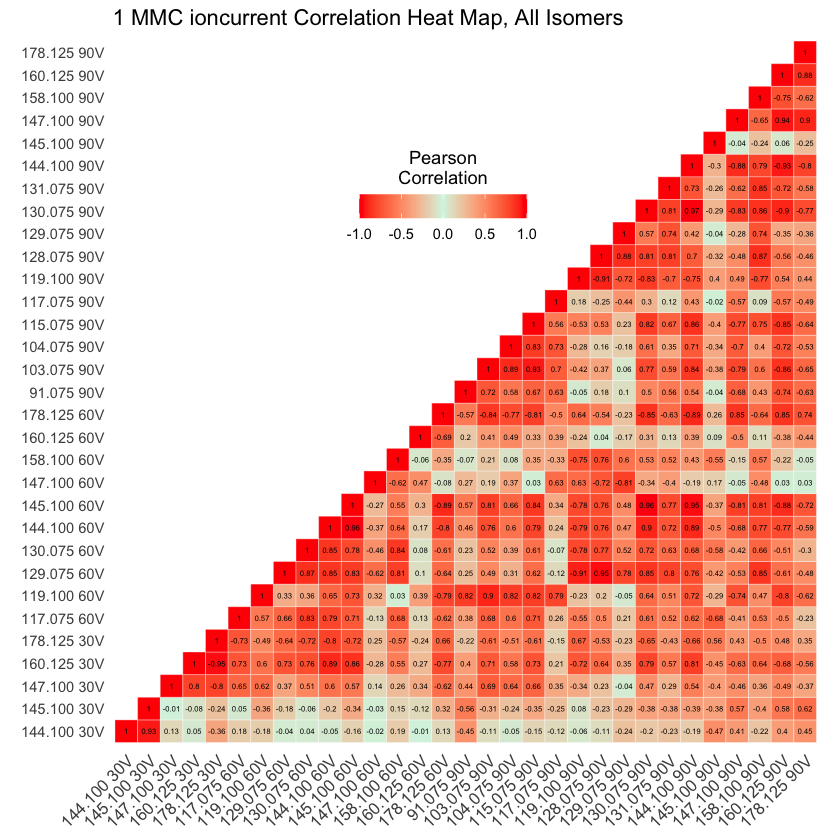


[[3]]


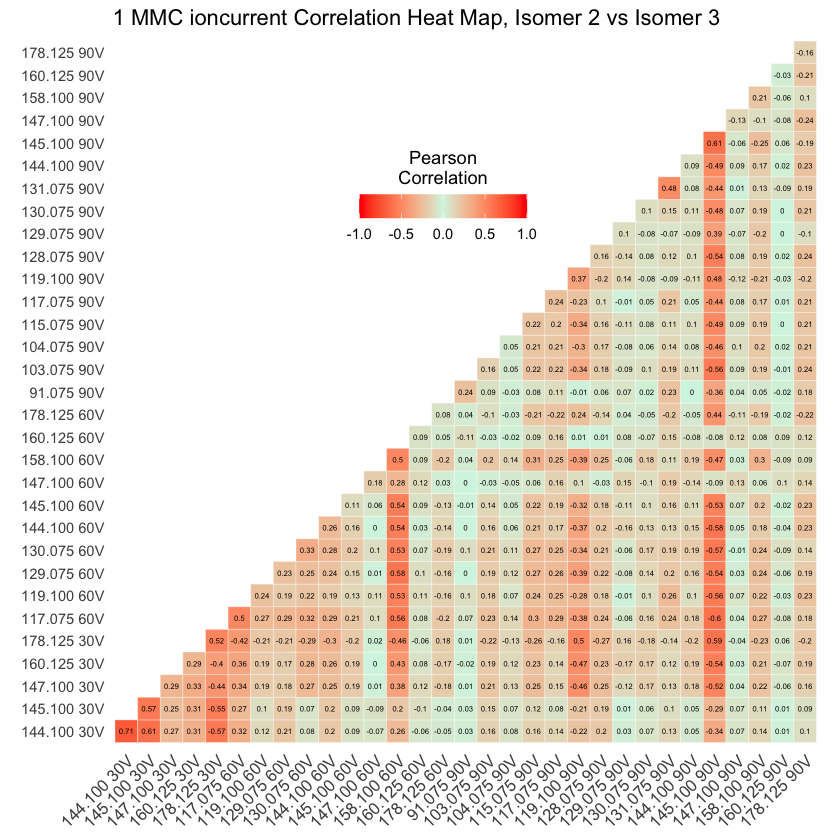


[[4]]



file saved to /Users/jenniferbonetti/Documents/UvA/Pub1_plots/Correlation/MMC-1-ioncurrent_all.pdf



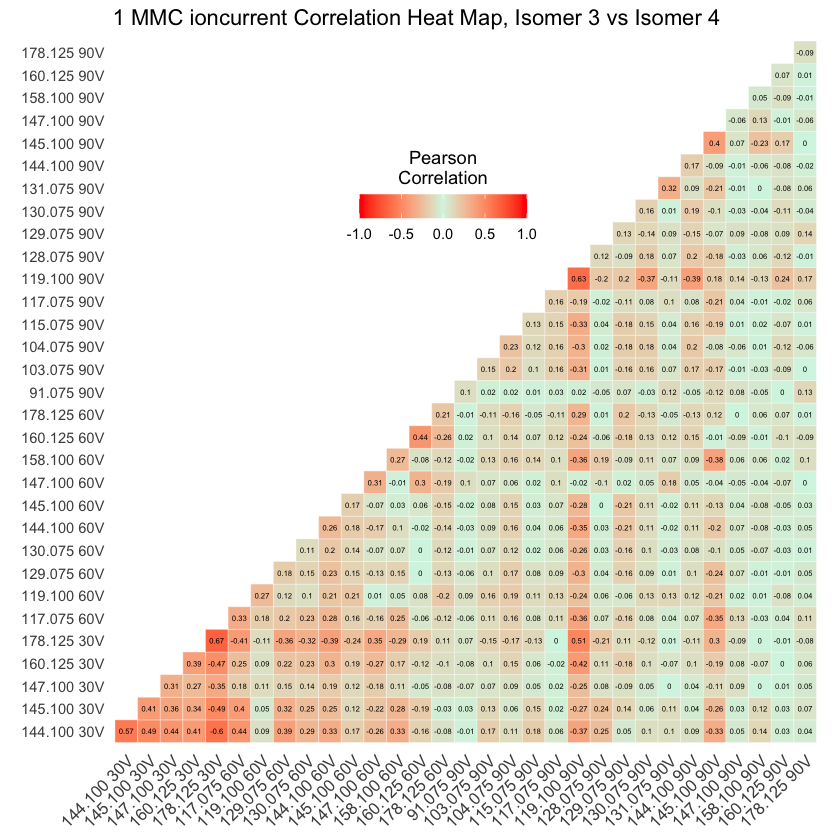

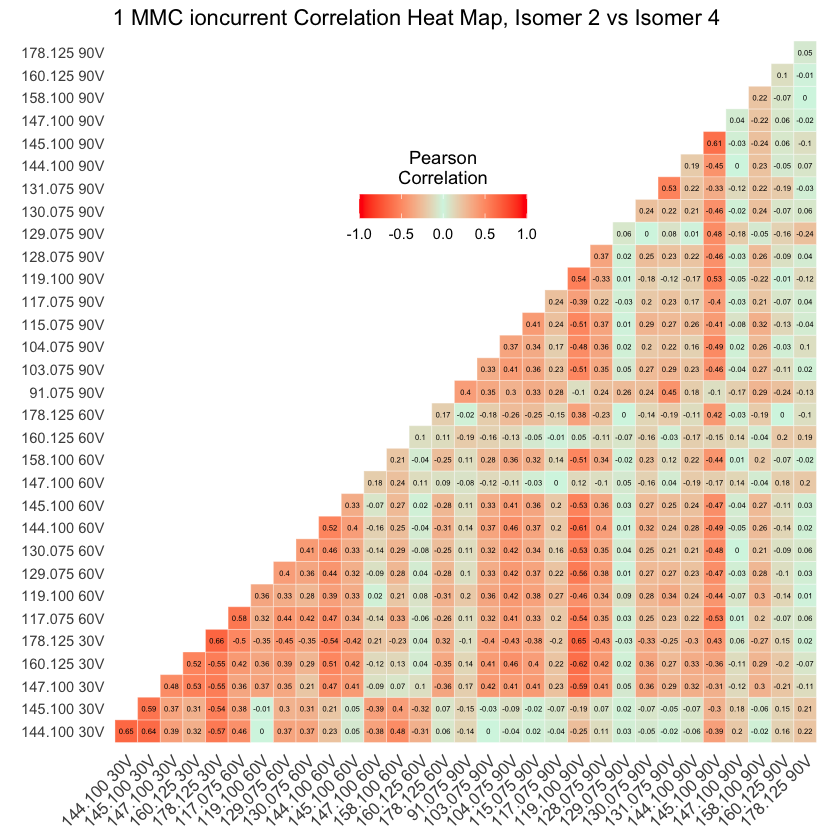

In [36]:
if(correlation){ #plot correlation heat maps

list_of_corr_plots <- vector("list", 4) #create empty list of plots
font_size <- (1/ncol(my_data))*50       #appropriate font size depends on # variables
cormat <- round(cor(my_data_test[,-1]),2) #create correlation matrix
    
get_upper_tri <- function(cormat){   #get upper triangle of the correlation matrix
    cormat[lower.tri(cormat)] <- NA   #put NAs in 
    return(cormat)
}
    
upper_tri <- get_upper_tri(cormat)   #get upper triangle of the correlation matrix
melted_cormat <- melt(upper_tri, na.rm = TRUE) #create melted correlation matrix for easy plotting, remove NAs
title <- paste0(ion_threshold, " ", type, " ", normal, " Correlation Heat Map, All Isomers") #assign plot title

corplot <- ggplot(data = melted_cormat, aes(x = Var2, y = Var1, fill = value)) +   #plot correlation heatmap
    geom_tile(color = "white") + #white background
    scale_fill_gradient2(low = "red", high = "red", mid = "#D5F5E3", midpoint = 0, limit = c(-1,1), space = "Lab", name = "Pearson\nCorrelation") + #set color scale for heatmap 
theme_minimal() + #set theme to minimal
labs(title = title) + #set plot title
theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 10, hjust = 1)) + #make x-axis font angled
coord_fixed() + #ensures that one unit on the x-axis is the same length as one unit on the y-axis
geom_text(aes(Var2, Var1, label = value), color = "black", size = font_size) + #add text of correlation coefficients to tiles
theme( #add additional theme elements
  axis.title.x = element_blank(), #no axis title space
  axis.title.y = element_blank(), #no axis title space
  panel.grid.major = element_blank(), #no major panel grid
  panel.border = element_blank(),     #no panel border
  panel.background = element_blank(), #no panel background
  axis.ticks = element_blank(),       #no axis ticks
  legend.justification = c(1, 0),     #set justification for legend
  legend.position = c(0.6, 0.7),      #set legend location
  legend.direction = "horizontal")+   #make legend horizontal
  guides(fill = guide_colorbar(barwidth = 7, barheight = 1, #adjust legend bar width and height
                title.position = "top", title.hjust = 0.5))
    
ggexport(corplot, filename = corr_file_full) #export plot alone

list_of_corr_plots[[1]] <- corplot #add to list of plots

#By isomer
if(nchar(as.character(my_data_test[1,1]))>1){ #remove"-type" information if present
    my_data_test[,1] <- substr(my_data_test[,1],1,1)
}

cormat_23 <- get_upper_tri(round(cor(my_data_test[my_data_test[,1]==2,-1], my_data_test[my_data_test[,1]==3,-1]),2)) #get upper triangle of correlation matrix between Isomers 2 and 3

melted_cormat <- melt(cormat_23, na.rm = TRUE)  #create melted correlation matrix for easy plotting, remove NAs
title <- paste0(ion_threshold, " ", type, " ", normal, " Correlation Heat Map, Isomer 2 vs Isomer 3") #assign plot title

corplot23 <- ggplot(data = melted_cormat, aes(x = Var2, y = Var1, fill = value)) +  #plot correlation heatmap for Isomer 2 vs Isomer 3
    geom_tile(color = "white") + #white background
    scale_fill_gradient2(low = "red", high = "red", mid = "#D5F5E3", midpoint = 0, limit = c(-1,1), space = "Lab", name = "Pearson\nCorrelation") + #set color scale for heatmap 
theme_minimal() + #set theme to minimal
labs(title = title) + #set plot title
theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 10, hjust = 1)) + #make x-axis font angled
coord_fixed() + #ensures that one unit on the x-axis is the same length as one unit on the y-axis
geom_text(aes(Var2, Var1, label = value), color = "black", size = font_size) + #add text of correlation coefficients to tiles
theme( #add additional theme elements
  axis.title.x = element_blank(), #no axis title space
  axis.title.y = element_blank(), #no axis title space
  panel.grid.major = element_blank(), #no major panel grid
  panel.border = element_blank(),     #no panel border
  panel.background = element_blank(), #no panel background
  axis.ticks = element_blank(),       #no axis ticks
  legend.justification = c(1, 0),     #set justification for legend
  legend.position = c(0.6, 0.7),      #set legend location
  legend.direction = "horizontal")+   #make legend horizontal
  guides(fill = guide_colorbar(barwidth = 7, barheight = 1, #adjust legend bar width and height
                title.position = "top", title.hjust = 0.5))

list_of_corr_plots[[2]] <- corplot23 #add to list of plots
    
#Isomer 3 vs Isomer 4    

cormat_34 <- get_upper_tri(round(cor(my_data_test[my_data_test[,1]==3,-1], my_data_test[my_data_test[,1]==4,-1]),2))#get upper triangle of correlation matrix between Isomers 3 and 4

melted_cormat <- melt(cormat_34, na.rm = TRUE)  #create melted correlation matrix for easy plotting, remove NAs
title <- paste0(ion_threshold, " ", type, " ", normal, " Correlation Heat Map, Isomer 3 vs Isomer 4") #assign plot title

corplot34 <- ggplot(data = melted_cormat, aes(x = Var2, y = Var1, fill = value)) + #plot correlation heatmap
    geom_tile(color = "white") + #white background
    scale_fill_gradient2(low = "red", high = "red", mid = "#D5F5E3", midpoint = 0, limit = c(-1,1), space = "Lab", name = "Pearson\nCorrelation") + #set color scale for heatmap 
theme_minimal() + #set theme to minimal
labs(title = title) + #set plot title
theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 10, hjust = 1)) + #make x-axis font angled
coord_fixed() + #ensures that one unit on the x-axis is the same length as one unit on the y-axis
geom_text(aes(Var2, Var1, label = value), color = "black", size = font_size) + #add text of correlation coefficients to tiles
theme( #add additional theme elements
  axis.title.x = element_blank(), #no axis title space
  axis.title.y = element_blank(), #no axis title space
  panel.grid.major = element_blank(), #no major panel grid
  panel.border = element_blank(),     #no panel border
  panel.background = element_blank(), #no panel background
  axis.ticks = element_blank(),       #no axis ticks
  legend.justification = c(1, 0),     #set justification for legend
  legend.position = c(0.6, 0.7),      #set legend location
  legend.direction = "horizontal")+   #make legend horizontal
  guides(fill = guide_colorbar(barwidth = 7, barheight = 1, #adjust legend bar width and height
                title.position = "top", title.hjust = 0.5))

list_of_corr_plots[[3]] <- corplot34 #add to list of plots
    
#Isomer 2 vs Isomer 4

cormat_24 <- get_upper_tri(round(cor(my_data_test[my_data_test[,1]==2,-1], my_data_test[my_data_test[,1]==4,-1]),2)) #get upper triangle of correlation matrix between Isomers 2 and 4

melted_cormat <- melt(cormat_24, na.rm = TRUE)             #create melted correlation matrix for easy plotting, remove NAs
title <- paste0(ion_threshold, " ", type, " ", normal, " Correlation Heat Map, Isomer 2 vs Isomer 4")

corplot24 <- ggplot(data = melted_cormat, aes(x = Var2, y = Var1, fill = value)) +   #plot correlation heatmap
    geom_tile(color = "white") + #white background
    scale_fill_gradient2(low = "red", high = "red", mid = "#D5F5E3", midpoint = 0, limit = c(-1,1), space = "Lab", name = "Pearson\nCorrelation") + #set color scale for heatmap 
theme_minimal() + #set theme to minimal
labs(title = title) + #set plot title
theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 10, hjust = 1)) + #make x-axis font angled
coord_fixed() + #ensures that one unit on the x-axis is the same length as one unit on the y-axis
geom_text(aes(Var2, Var1, label = value), color = "black", size = font_size) + #add text of correlation coefficients to tiles
theme( #add additional theme elements
  axis.title.x = element_blank(), #no axis title space
  axis.title.y = element_blank(), #no axis title space
  panel.grid.major = element_blank(), #no major panel grid
  panel.border = element_blank(),     #no panel border
  panel.background = element_blank(), #no panel background
  axis.ticks = element_blank(),       #no axis ticks
  legend.justification = c(1, 0),     #set justification for legend
  legend.position = c(0.6, 0.7),      #set legend location
  legend.direction = "horizontal")+   #make legend horizontal
  guides(fill = guide_colorbar(barwidth = 7, barheight = 1, #adjust legend bar width and height
                title.position = "top", title.hjust = 0.5))

list_of_corr_plots[[4]] <- corplot24 #add to list of plots
print(list_of_corr_plots) #print list of plots
ggexport(plotlist = list_of_corr_plots,filename = corr_file_all) #export list of plots
    }


## Random Forest cross-validation

In [37]:
if(rf_cv) { #if performing random forest cross-validation with decreasing variables
result <- rfcv(my_data_test[,-1], as.factor(my_data_test[,1]), cv.fold = 12) #rf cross-validation, 12-fold 
title <- paste0(ion_threshold, " ", type, " ", normal, " Random Forest Cross-validation (12 Folds)") #set plots title
to_plot <- cbind("error.cv" = result$error.cv, "n.var" = result$n.var) #set plot data and names
rfcv_plot <- ggplot(data = as.data.frame(to_plot), aes(x = n.var, y = error.cv)) + #plot error rate with changing # of variables
geom_point() + #scatterplot
geom_line() +  #connected by lines
labs(x = "Number of Variables", y = "CV Error Rate", title = title) + #label axes and title
scale_x_log10() + #scale x axis on log scale
theme(panel.background = element_rect(fill = "white")) + #white background
theme(plot.background = element_rect(color = "black")) + #black border
theme(text = element_text(size = 12)) #text size

ggexport(rfcv_plot, filename = rfcv_file) #export plot
    }

## Plot Comparing method variable importance

In [38]:
if(compare_methods && !sameday && !test_set){  #if comparing variable importance by method
    font_size <- (1/ncol(my_data))*126 #change font size based on number of variables
    
    list_of_comparison_plots <- vector("list", 4) #create empty list for comparison plots
    plot_data <- cbind(c(rep("t-test",ncol(compare_matrix)),rep("LD1",ncol(compare_matrix)),rep("LD2",ncol(compare_matrix)),rep("Random_Forest",ncol(compare_matrix))),rep(colnames(compare_matrix),4),c(compare_matrix[1,], compare_matrix[2,], compare_matrix[3,],compare_matrix[4,])) #make data frame of plotting data including one column of analysis method, and one column with results per method
    colnames(plot_data) <- c("Method", "Variable", "Importance") #column names of plotting data frame
    title = paste0("Comparison of Variable Importance per method, ", ion_threshold, " ", type, " ", normal) #set plot title
    
comparison_plot <- ggplot(as.data.frame(plot_data), aes(x = Variable, y = as.numeric(Importance), fill = Method)) + #plot Variable vs Importance, filled based on Method (too busy, not used)
    geom_bar(stat = "identity", position = position_dodge(), width = 0.8, color = "darkblue") + #bar grapht, color of outline of bars
    scale_fill_brewer(palette = "Set2") + #set color palette
    labs(title = title, y = "Importance") + #label y-axis and title
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)) + #change font/angle of x-axis
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black")) + #black border
    theme(text = element_text(size = 10)) +  #text size
    theme(legend.key.size = unit(7,"pt"))    #legend size

 
title = paste0("T-test Average Accuracy") #assign title
    ttest_comparison_plot <- ggplot(as.data.frame(plot_data[which(plot_data[,1]=="t-test"),]), aes(x = Variable, y = as.numeric(Importance))) + #plot Variable vs Average Accuracy for t-test
    geom_bar(stat = "identity", position = position_dodge(), width = 0.8) + #bar graph
    coord_cartesian(ylim=c(0.3,1.0)) + #adjust axis to make more comparable to other plots
    scale_x_discrete(limits = plot_data[which(plot_data[,1]=="t-test"),2]) + #set x-axis scale
    labs(title = title, y = "t-test Average Accuracy") + #label y-axis and title
    theme(axis.text.x = element_text(angle = 45, vjust = 1, size = font_size, hjust = 1)) + #set x-axis labels on angle, set font size
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black")) + #black border
    theme(text = element_text(size = 9))   #legend size
                                                        
list_of_comparison_plots[[1]] <- ttest_comparison_plot #put plot in position 1
    
title = paste0("Random Forest Variable Importance") #assign title
rf_comparison_plot <- ggplot(as.data.frame(plot_data[which(plot_data[,1]=="Random_Forest"),]), aes(x = Variable, y = as.numeric(Importance))) + #plot Variable vs mean decrease accuracy for Random Forest
    geom_bar(stat = "identity", position = position_dodge(), width = 0.8) + #bar graph
    scale_x_discrete(limits = plot_data[which(plot_data[,1]=="Random_Forest"),2]) + #set x-axis scale
    labs(title = title, y = "Mean Decrease Accuracy") + #label y-axis and title
    theme(axis.text.x = element_text(angle = 45, vjust = 1, size = font_size, hjust = 1)) +#set x-axis labels on angle, set font size
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black")) + #black border
    theme(text = element_text(size = 9))   #legend size 
                                                                                                            
list_of_comparison_plots[[2]] <- rf_comparison_plot  #put plot in position 2
    
#LD1 plot
    title = paste0("LD1 Scalings") #assign title
lda_comparison_plot1 <- ggplot(as.data.frame(plot_data[which(plot_data[,1]=="LD1"),]), aes(x = Variable, y = as.numeric(Importance))) + #plot Variable vs importance for LD1 function
    geom_bar(stat = "identity", position = position_dodge(), width = 0.8) + #bar graph
    scale_x_discrete(limits = plot_data[which(plot_data[,1]=="LD1"),2]) + #set x-axis scale
    labs(title = title, y = "LD1 Scalings") + #label y-axis and title
    theme(axis.text.x = element_text(angle = 45, vjust = 1, size = font_size, hjust = 1)) + #set x-axis labels on angle, set font size
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black")) + #black border
    theme(text = element_text(size = 9))   #legend size
                                                                                                         
list_of_comparison_plots[[3]] <- lda_comparison_plot1 #put plot in position 3
    
    title = paste0("LD2 Scalings")
lda_comparison_plot2 <- ggplot(as.data.frame(plot_data[which(plot_data[,1]=="LD2"),]), aes(x = Variable, y = as.numeric(Importance))) + #plot Variable vs importance for LD2 function
    geom_bar(stat = "identity", position = position_dodge(), width = 0.8) + #bar graph
    scale_x_discrete(limits = plot_data[which(plot_data[,1]=="LD2"),2]) +  #set x-axis scale
    labs(title = title, y = "LD2 Scalings") + #label y-axis and title
    theme(axis.text.x = element_text(angle = 45, vjust = 1, size = font_size, hjust = 1)) +#set x-axis labels on angle, set font size
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black")) + #black border
    theme(text = element_text(size = 9))   #legend size
                                                                                                                
list_of_comparison_plots[[4]] <- lda_comparison_plot2 #put plot in position 4
    
ggexport(plotlist = list_of_comparison_plots, ncol = 2, nrow = 2, filename = comparison_file)    #explort plots in 2x2 grid
}

## Comparison of Methods Plot

In [39]:
if(compare_plot) { #if making comparison plot
    
    compare_plot_data <- as.data.frame(compare_plot_data) #make compare plot data into a data frame
    compare_plot_data[,2] <- as.numeric(compare_plot_data[,2])#make Threshold data numeric
    compare_plot_data[,4] <- as.numeric(compare_plot_data[,4])#make rate numeric
    compare_plot_data[,1] <- factor(compare_plot_data[,1], levels = c("t-test", "LDA", "Random Forest")) #Make methods into ordered factors
    title <- paste0("Comparison of Results by Method for ", ion_threshold, "% ", type) #assign title
    if(sameday){ #if same day
     title <- paste0("Comparison of Results by Method for ", ion_threshold, "% ", type, " for Same day analysis")   #assign title
    }
    if(test_set){ #if test set
     title <- paste0("Comparison of Results by Method for ", ion_threshold, "% ", type, " for Test Set analysis")   #assign title
    }
    if(sameday && test_set){ #if both
     title <- paste0("Comparison of Results by Method for ", ion_threshold, "% ", type, " for Same day/Test Set analysis")  #assign title 
    }
compare_plot2 <- ggplot() + #create comparison plot
    geom_bar(data = compare_plot_data, aes(y= Rate, x = Method, fill = Result), stat = "identity", position = 'stack') + #stacked bar graph, separated by method
    theme_bw() +
    scale_fill_brewer(palette = "Pastel1") + #set color palette
    labs(title = title) + #label title
    theme(axis.text.x = element_text(angle = 45, vjust = 1, size = 8, hjust = 1)) + #make x-axis font angled
    theme(panel.background = element_rect(fill = "white")) + #white background
    theme(plot.background = element_rect(color = "black")) + #black border
    theme(legend.position="bottom", legend.key.size = unit(8,"pt")) + #set legend beneath plot, set text size
    facet_grid(~Threshold) #separate grid per threshold

print(compare_plot2)
if(!test_set){
ggexport(compare_plot2, filename = compare_plot_file) #export plot
    }
if(test_set){
ggexport(compare_plot2, filename = compare_plot_file_test) #export plot
}
    }